<!-- Google Fonts -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

<div style="
    border-radius: 15px; 
    border: 2px solid #8B4513; 
    padding: 20px; 
    background: linear-gradient(125deg, #d73027 7%, #fdae61 47%, #a6d96a 85%, #1a9850 100%);
    text-align: center; 
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);
">
    <h1 style="
        color: #fff; 
        text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); 
        font-weight: bold; 
        margin-bottom: 10px; 
        font-size: 36px; 
        font-family: 'Roboto', sans-serif;
        letter-spacing: 1px;
    ">
        🌾 Smart Fertilizer Ranker 🔢 MAP@3 | XGBoost 📊
    </h1>
</div>


### 📂 Dataset Overview

This project uses the **Fertilizer Prediction** dataset from the **Kaggle Playground Series – Season 5, Episode 6 (2025)**. The challenge is inspired by real-world agricultural decision-making, where the goal is to recommend the most suitable fertilizers based on environmental conditions, soil characteristics, and crop types.

### 🧾 Key Features

* **Climatic Attributes**
  `Temparature` (°C), `Humidity` (%), `Moisture` (%)

* **Soil & Crop Information**
  `Soil Type`, `Crop Type`

* **Soil Nutrients**
  `Nitrogen`, `Phosphorous`, `Potassium`

* **Target Variable**
  `Fertilizer Name` — a categorical label representing the recommended fertilizer (e.g., Urea, 14‑35‑14, etc.)

### 📁 Files Provided

* `train.csv` (750,000 samples): Contains features and the target fertilizer label.
* `test.csv` (250,000 samples): Requires predicting up to **three** fertilizer types per row.
* `Fertilizer Prediction.csv` (100,000 samples): The original dataset used to generate the synthetic competition data (sources: [IEEE DataPort](https://ieee-dataport.org/documents/soil-fertility-data-fertilizer-recommendation), [Kaggle Dataset](https://www.kaggle.com/datasets/irakozekelly/fertilizer-prediction/data)).

This dataset supports the development of **precision agriculture** models and serves as a valuable benchmark for multi-label classification, ranking strategies, and evaluation using top‑K metrics such as MAP\@3.

### 🎯 Project Objective

The primary objective of this notebook is to **build a robust machine learning model that predicts the top-3 most appropriate fertilizers** for a given combination of environmental and soil features.

Key components of the approach include:

* **🔍 Exploratory Data Analysis (EDA):** Understand feature distributions, relationships, and class imbalance.
* **⚙️ Feature Engineering:** Encode categorical variables and align schema across training and test data.
* **📈 Modeling with XGBoost:** Train an ensemble model with hyperparameters tuned using Optuna.
* **🔢 Multi-Label Prediction Strategy:** Generate ranked predictions for each test row.
* **🧪 Evaluation Framework:**

  * Cross-validated Out-of-Fold (OOF) predictions
  * Metrics: **Log Loss** and **Mean Average Precision @3 (MAP\@3)**

By combining structured learning with ranking optimization, this project aims to generate **data-driven fertilizer recommendations** that can improve crop yield, promote sustainable farming, and support informed agricultural practices.


<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

# <span style="color:transparent;">Import Libraries</span>

<div style="
    border-radius: 15px; 
    border: 2px solid #8B4513; 
    padding: 10px; 
    background: linear-gradient(135deg, #d73027, #fdae61 40%, #a6d96a 80%, #1a9850); 
    text-align: center; 
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);
">
    <h1 style="
        color: #FFFFFF; 
        text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); 
        font-weight: bold; 
        margin-bottom: 5px; 
        font-size: 28px; 
        font-family: 'Roboto', sans-serif;
        letter-spacing: 1px;
    ">
        Import Libraries
    </h1>
</div>


In [1]:
# Core data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Statistical functions
from scipy.stats import skew

# Display utilities for Jupyter notebooks
from IPython.display import display

# Machine learning preprocessing and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import log_loss, accuracy_score
import xgboost as xgb

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

# <span style="color:transparent;">Load Data</span>

<div style="
    border-radius: 15px; 
    border: 2px solid #8B4513; 
    padding: 10px; 
    background: linear-gradient(135deg, #d73027, #fdae61 40%, #a6d96a 80%, #1a9850); 
    text-align: center; 
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);
">
    <h1 style="
        color: #FFFFFF; 
        text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); 
        font-weight: bold; 
        margin-bottom: 5px; 
        font-size: 28px; 
        font-family: 'Roboto', sans-serif;
        letter-spacing: 1px;
    ">
        Load Data
    </h1>
</div>


In [2]:
# Load the datasets
train_data = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')
sample_data = pd.read_csv('/kaggle/input/playground-series-s5e6/sample_submission.csv')
original_data = pd.read_csv('/kaggle/input/fertilizer-prediction/Fertilizer Prediction.csv')

# Verify shapes
print("Train Data Shape:", train_data.shape)
print("\nOriginal Data Shape:", original_data.shape)
print("\nTest Data Shape:", test_data.shape)

Train Data Shape: (750000, 10)

Original Data Shape: (100000, 9)

Test Data Shape: (250000, 9)


<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

# <span style="color:transparent;">Data Preview and Info</span>

<div style="
    border-radius: 15px; 
    border: 2px solid #8B4513; 
    padding: 10px; 
    background: linear-gradient(135deg, #d73027, #fdae61 40%, #a6d96a 80%, #1a9850); 
    text-align: center; 
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);
">
    <h1 style="
        color: #FFFFFF; 
        text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); 
        font-weight: bold; 
        margin-bottom: 5px; 
        font-size: 28px; 
        font-family: 'Roboto', sans-serif;
        letter-spacing: 1px;
    ">
        Data Preview and Info
    </h1>
</div>


In [3]:
# Display few rows of each dataset
print("Train Data Preview:")
display(train_data.tail())

print("\nOriginal Data Preview:")
display(original_data.head())

print("\nTest Data Preview:")
display(test_data.head())

Train Data Preview:


id  Temparature  Humidity  Moisture Soil Type    Crop Type  \
749995  749995           25        69        30    Clayey        Maize   
749996  749996           37        64        58     Loamy    Sugarcane   
749997  749997           35        68        59     Sandy  Ground Nuts   
749998  749998           31        68        29       Red       Cotton   
749999  749999           33        55        29     Loamy       Cotton   

        Nitrogen  Potassium  Phosphorous Fertilizer Name  
749995         8         16            6           28-28  
749996        38          8           20        17-17-17  
749997         6         11           29        10-26-26  
749998         9         11           12           20-20  
749999         4         10            9            Urea


Original Data Preview:


Temparature  Humidity  Moisture Soil Type    Crop Type  Nitrogen  \
0           32        51        41       Red  Ground Nuts         7   
1           35        58        35     Black       Cotton         4   
2           27        55        43     Sandy    Sugarcane        28   
3           33        56        56     Loamy  Ground Nuts        37   
4           32        70        60       Red  Ground Nuts         4   

   Potassium  Phosphorous Fertilizer Name  
0          3           19        14-35-14  
1         14           16            Urea  
2          0           17           20-20  
3          5           24           28-28  
4          6            9        14-35-14


Test Data Preview:


id  Temparature  Humidity  Moisture Soil Type    Crop Type  Nitrogen  \
0  750000           31        70        52     Sandy        Wheat        34   
1  750001           27        62        45       Red    Sugarcane        30   
2  750002           28        72        28    Clayey  Ground Nuts        14   
3  750003           37        53        57     Black  Ground Nuts        18   
4  750004           31        55        32       Red       Pulses        13   

   Potassium  Phosphorous  
0         11           24  
1         14           15  
2         15            4  
3         17           36  
4         19           14

In [4]:
# Display information about the DataFrames
print("Train Data Info:")
train_data.info()

print("\nOriginal Data Info:")
original_data.info()

print("\nTest Data Info:")
test_data.info()

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB

Original Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      100000 non-null  int64 
 

#### Insights from Initial Data Exploration

**Dataset Size and Structure**  
   - The **training dataset** contains 750,000 samples with 10 columns, including the target variable `Fertilizer Name`.  
   - The **original dataset** has 100,000 samples and 9 columns, similar in structure but smaller in size.  
   - The **test dataset** includes 250,000 samples with 9 columns (without the target), ready for prediction.

**Feature Overview**  
   - Both datasets include important environmental and soil attributes:  
     - **Numerical features:** Temperature, Humidity, Moisture, Nitrogen, Potassium, Phosphorous  
     - **Categorical features:** Soil Type, Crop Type  
   - The target variable is categorical, representing different fertilizer names.

**Data Consistency and Completeness**  
   - All datasets have **no missing values**, which simplifies preprocessing and modeling.  
   - Data types are appropriate: numerical features are integers, and categorical features are objects (strings).

**Differences Between Datasets**  
   - The training data has an additional `id` column, which uniquely identifies each sample.  
   - The original dataset excludes the `id` column but contains the same features and target.


In [5]:
# Exclude 'id' and display descriptive statistics for each dataset

# Train Data
train_desc = train_data.drop(columns=['id'], errors='ignore').describe().T
print("Train Data Describe:")
display(train_desc.style.background_gradient(cmap='RdYlGn'))

# Original Data
original_desc = original_data.describe().T
print("\nOriginal Data Describe:")
display(original_desc.style.background_gradient(cmap='RdYlGn'))

# Test Data
test_desc = test_data.drop(columns=['id'], errors='ignore').describe().T
print("\nTest Data Describe:")
display(test_desc.style.background_gradient(cmap='RdYlGn'))


Train Data Describe:



Original Data Describe:



Test Data Describe:


#### Descriptive Insights from Dataset Statistics

After excluding the `id` column, we examined the summary statistics of the numerical features across the **train**, **original**, and **test** datasets. The statistics include count, mean, standard deviation, minimum, quartiles, and maximum values.

**Feature Distribution Consistency**

- The **train**, **original**, and **test** datasets show remarkably consistent distributions for all numerical features, indicating that the synthetic training data closely mimics the original data distribution, and the test data follows the same pattern.
- For example, the mean temperature is around 31.5°C across all datasets, with a similar range from 25°C to 38°C.
- Humidity, moisture, and soil nutrient levels (Nitrogen, Potassium, Phosphorous) also maintain similar means and spread, suggesting the datasets are well-aligned and suitable for training and testing models without major domain shifts.

**Temperature**

- The temperature ranges from 25 to 38 degrees Celsius, with a mean around 31.5°C and a standard deviation of approximately 4.0.
- The interquartile range (IQR) between 28°C (25th percentile) and 35°C (75th percentile) indicates moderate variability in environmental conditions.

**Humidity**

- Humidity values range from 50% to 72%, with a mean near 61% and a standard deviation around 6.6.
- The IQR (55% to 67%) suggests moderate variation in moisture content in the air, which could influence fertilizer effectiveness.

**Soil Moisture**

- Soil moisture spans from 25 to 65, with an average around 45 and a standard deviation close to 11.8.
- This wide range reflects diverse soil water content conditions across samples, which is critical for fertilizer absorption.

**Soil Nutrients (Nitrogen, Potassium, Phosphorous)**

- **Nitrogen** levels vary from 4 to 42 units, averaging about 23 with a standard deviation of ~11.2.  
- **Potassium** ranges from 0 to 19, with a mean near 9.5 and a standard deviation of ~5.7.  
- **Phosphorous** varies from 0 to 42, averaging around 21 with a standard deviation of ~12.3.  

These nutrient levels show considerable variability, highlighting the need for tailored fertilizer recommendations based on precise soil composition.


In [6]:
def print_unique_values(df, categorical_columns, dataset_name="Dataset"):
    print("\n" + "=" * 50)
    print(f"Unique values in {dataset_name} categorical features")
    print("=" * 50)
    for col in categorical_columns:
        unique_vals = sorted(df[col].unique())
        value_counts = df[col].value_counts()
        top_value = value_counts.index[0]
        top_freq = value_counts.iloc[0]
        print(f"{col} - Number of unique values: {len(unique_vals)}")
        print(f"Unique values: {unique_vals}")
        print(f"Top value: '{top_value}' (Frequency: {top_freq})\n")

train_cat_cols = ['Soil Type', 'Crop Type', 'Fertilizer Name']
original_cat_cols = ['Soil Type', 'Crop Type', 'Fertilizer Name']
test_cat_cols = ['Soil Type', 'Crop Type']

print_unique_values(train_data, train_cat_cols, "Train Data")
print_unique_values(original_data, original_cat_cols, "Original Data")
print_unique_values(test_data, test_cat_cols, "Test Data")


Unique values in Train Data categorical features
Soil Type - Number of unique values: 5
Unique values: ['Black', 'Clayey', 'Loamy', 'Red', 'Sandy']
Top value: 'Sandy' (Frequency: 156710)

Crop Type - Number of unique values: 11
Unique values: ['Barley', 'Cotton', 'Ground Nuts', 'Maize', 'Millets', 'Oil seeds', 'Paddy', 'Pulses', 'Sugarcane', 'Tobacco', 'Wheat']
Top value: 'Paddy' (Frequency: 85754)

Fertilizer Name - Number of unique values: 7
Unique values: ['10-26-26', '14-35-14', '17-17-17', '20-20', '28-28', 'DAP', 'Urea']
Top value: '14-35-14' (Frequency: 114436)


Unique values in Original Data categorical features
Soil Type - Number of unique values: 5
Unique values: ['Black', 'Clayey', 'Loamy', 'Red', 'Sandy']
Top value: 'Black' (Frequency: 20100)

Crop Type - Number of unique values: 11
Unique values: ['Barley', 'Cotton', 'Ground Nuts', 'Maize', 'Millets', 'Oil seeds', 'Paddy', 'Pulses', 'Sugarcane', 'Tobacco', 'Wheat']
Top value: 'Sugarcane' (Frequency: 9267)

Fertilizer Nam

#### Insights on Categorical Features

**Consistency of Categories Across Datasets**

- The **categorical features** — *Soil Type*, *Crop Type*, and *Fertilizer Name* (target) — have consistent unique values across the **train**, **original**, and **test** datasets.  
- Each dataset contains exactly **5 unique soil types**, **11 unique crop types**, and **7 unique fertilizer types** (except the test set which does not have fertilizer labels).  
- This consistency indicates that the synthetic training data and the test data are well-aligned with the original dataset, reducing concerns about unseen categories during prediction.

**Soil Type**

- The five soil types are: `Clayey`, `Sandy`, `Red`, `Loamy`, and `Black`.    
- The original dataset shows *Black* soil as the most common, while the test set again has *Sandy* as the dominant soil type.  
- These differences in dominant soil types across datasets may reflect sampling variations but overall distribution is stable.

**Crop Type**

- The datasets share 11 crop types, including common crops like `Paddy`, `Sugarcane`, `Wheat`, `Cotton`, `Maize`, and `Pulses`.  
- *Paddy* is the most frequent crop in the training and test datasets, whereas *Sugarcane* leads in the original dataset.  
- The presence of all crop types in both train and test sets ensures the model can learn and predict across the full range of crops.

**Fertilizer Name**

- The target variable has 7 distinct fertilizer types such as `14-35-14`, `Urea`, `DAP`, and `17-17-17`.  
- The most common fertilizer in both train and original datasets is `14-35-14`, indicating it might be the default or most widely used fertilizer for many conditions.  
- Understanding the distribution of fertilizer types will help in addressing class imbalance during model training.


<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

# <span style="color:transparent;">Data Quality Checks</span>

<div style="
    border-radius: 15px; 
    border: 2px solid #8B4513; 
    padding: 10px; 
    background: linear-gradient(135deg, #d73027, #fdae61 40%, #a6d96a 80%, #1a9850); 
    text-align: center; 
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);
">
    <h1 style="
        color: #FFFFFF; 
        text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); 
        font-weight: bold; 
        margin-bottom: 5px; 
        font-size: 28px; 
        font-family: 'Roboto', sans-serif;
        letter-spacing: 1px;
    ">
        Data Quality Checks
    </h1>
</div>


In [7]:
def missing_values_report(df, dataset_name):
    missing_count = df.isnull().sum().sum()
    rows = len(df)
    
    print("=" * 40)
    print(f"{dataset_name} Missing Value Analysis")
    print("=" * 40)
    
    if missing_count == 0:
        print(f"✅ No missing values detected in {rows:,} rows")
    else:
        print(f"⚠️  {missing_count} missing values found in {rows:,} rows")

datasets = {
    "Training Data": train_data,
    "Test Data": test_data,
    "Original Data": original_data
}

for name, data in datasets.items():
    missing_values_report(data, name)
    print()  


Training Data Missing Value Analysis
✅ No missing values detected in 750,000 rows

Test Data Missing Value Analysis
✅ No missing values detected in 250,000 rows

Original Data Missing Value Analysis
✅ No missing values detected in 100,000 rows



In [8]:
def check_duplicates_report(df, dataset_name):
    duplicates_count = df.duplicated().sum()
    total_rows = len(df)
    
    print("=" * 40)
    print(f"🔍 {dataset_name} Duplicate Analysis")
    print("=" * 40)
    
    if duplicates_count == 0:
        print(f"✅ No duplicates found in {total_rows:,} rows")
    else:
        print(f"⚠️  {duplicates_count} duplicates found ({duplicates_count/total_rows:.2%})")
        print(f"    Total rows affected: {duplicates_count:,}/{total_rows:,}")

datasets = {
    "Training Data": train_data,
    "Test Data": test_data,
    "Original Data": original_data
}

duplicate_summary = {}
for name, data in datasets.items():
    check_duplicates_report(data, name)
    duplicate_summary[name] = {
        'duplicates': data.duplicated().sum(),
        'total_rows': len(data)
    }
    print()


🔍 Training Data Duplicate Analysis
✅ No duplicates found in 750,000 rows

🔍 Test Data Duplicate Analysis
✅ No duplicates found in 250,000 rows

🔍 Original Data Duplicate Analysis
✅ No duplicates found in 100,000 rows



#### Data Quality Insights: Missing Values and Duplicates

**Missing Values Analysis**

- We conducted a thorough check for missing values across the **training**, **test**, and **original** datasets.  
- **No missing values** were detected in any of the datasets, including:  
  - Training Data: 750,000 rows  
  - Test Data: 250,000 rows  
  - Original Data: 100,000 rows  
- This completeness of data simplifies preprocessing since we do not need to perform imputation or remove incomplete records.

**Duplicate Records Analysis**

- We also examined the datasets for duplicate rows that could bias the model or inflate performance metrics.  
- **No duplicate records** were found in any dataset, confirming the uniqueness and integrity of each sample:  
  - Training Data: 0 duplicates out of 750,000 rows  
  - Test Data: 0 duplicates out of 250,000 rows  
  - Original Data: 0 duplicates out of 100,000 rows  
- The absence of duplicates ensures that the model will not be trained or evaluated on repeated data points, which helps maintain the reliability of results.


<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

# <span style="color:transparent;">Exploratory Data Analysis (EDA)</span>

<div style="
    border-radius: 15px; 
    border: 2px solid #8B4513; 
    padding: 10px; 
    background: linear-gradient(135deg, #d73027, #fdae61 40%, #a6d96a 80%, #1a9850); 
    text-align: center; 
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);
">
    <h1 style="
        color: #FFFFFF; 
        text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); 
        font-weight: bold; 
        margin-bottom: 5px; 
        font-size: 28px; 
        font-family: 'Roboto', sans-serif;
        letter-spacing: 1px;
    ">
        Exploratory Data Analysis (EDA)
    </h1>
</div>


## Fertilizer Classes Distribution

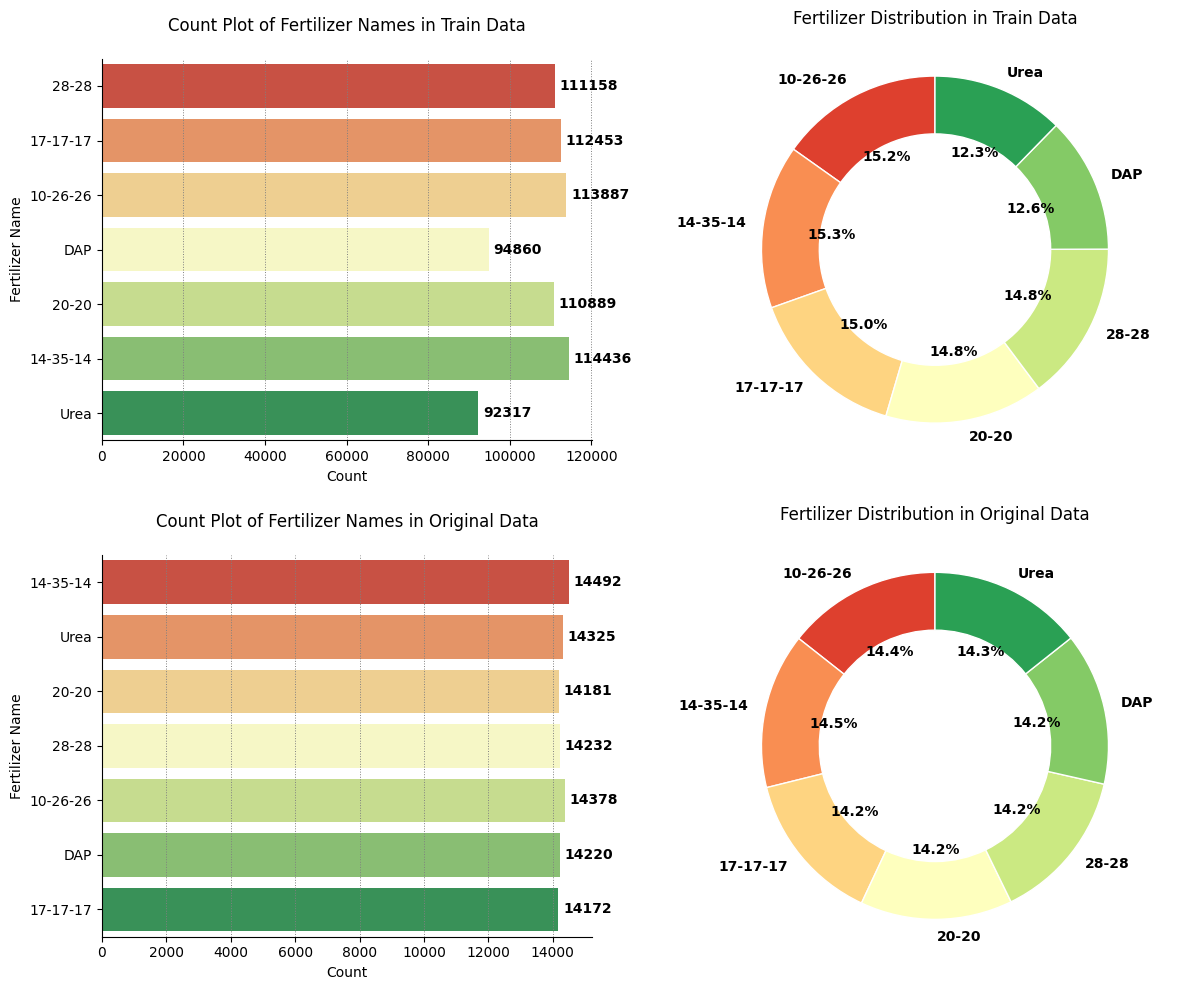

In [9]:
# Set target variable
target_variable = 'Fertilizer Name'

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
datasets = [('Train Data', train_data), ('Original Data', original_data)]

for i, (title, data) in enumerate(datasets):
    ax = axes[i, 0]
    sns.countplot(y=target_variable, data=data, ax=ax, palette='RdYlGn')
    ax.set_title(f'Count Plot of Fertilizer Names in {title}', pad=20)
    ax.set_ylabel('Fertilizer Name')
    ax.set_xlabel('Count')
    ax.grid(axis='x', color='gray', linestyle=':', linewidth=0.7)

    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.text(width + max(data[target_variable].value_counts())*0.01, y,
                f'{int(width)}', 
                ha='left', va='center', fontsize=10, fontweight='bold', color='black')

    fertilizer_counts = data[target_variable].value_counts().sort_index()
    wedges, texts, autotexts = axes[i, 1].pie(
        fertilizer_counts,
        labels=fertilizer_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("RdYlGn", len(fertilizer_counts)),
        wedgeprops=dict(width=0.4, edgecolor='w'),
        radius=1.2
    )
    
    for text in texts + autotexts:
        text.set_fontsize(10)
        text.set_fontweight('bold')
    
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    axes[i, 1].add_artist(centre_circle)
    axes[i, 1].set_title(f'Fertilizer Distribution in {title}', pad=25)
    axes[i, 1].axis('equal') 

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()


#### Insights into Fertilizer Name Distribution

**Frequency of Fertilizer Names**

- The count plots reveal the absolute counts of each fertilizer name in the two datasets.
- **Training Data:**  
  - `14-35-14` is the most frequent fertilizer, with 114,436 occurrences, accounting for approximately 15.26% of the dataset.  
  - `10-26-26` is also highly prevalent, with 113,887 counts (~15.18%).  
  - `Urea` has the lowest count at 92,317, representing 12.31% of the dataset.  
- **Original Data:**  
  - Similar to the training data, `14-35-14` is most common with 14,492 instances (~14.49%).  
  - All other fertilizers are also relatively evenly distributed (around ~14%), suggesting balanced usage in the original data.

**Percentage Distribution**

- The donut charts provide a clear visualization of the percentage distribution of fertilizer names.
- **Training Data:**  
  - The proportions of `14-35-14`, `10-26-26`, `17-17-17`, `28-28`, and `20-20` are nearly uniform (14.79% to 15.26%), indicating that these fertilizers are similarly represented in the dataset.  
  - `DAP` and `Urea` have slightly lower percentages, reflecting their relatively lower frequency as also evident from the count plot.  
- **Original Data:**  
  - The percentage distribution is much more balanced, with each fertilizer type accounting for roughly 14% of the data. This might suggest better balance and diversity in the original dataset compared to the synthetic training data.


***The synthetic training data exhibits some class imbalance, with certain fertilizers (`14-35-14` and `10-26-26`) being slightly more frequent than others (`Urea` and `DAP`). The original data exhibits a more balanced distribution, which may be beneficial for model training as it provides more equal representation of each class. The fact that `14-35-14` is consistently the most common fertilizer in both datasets could indicate that it is a general-purpose fertilizer, widely applicable across different soil and crop conditions.***



## Numerical Feature Distributions

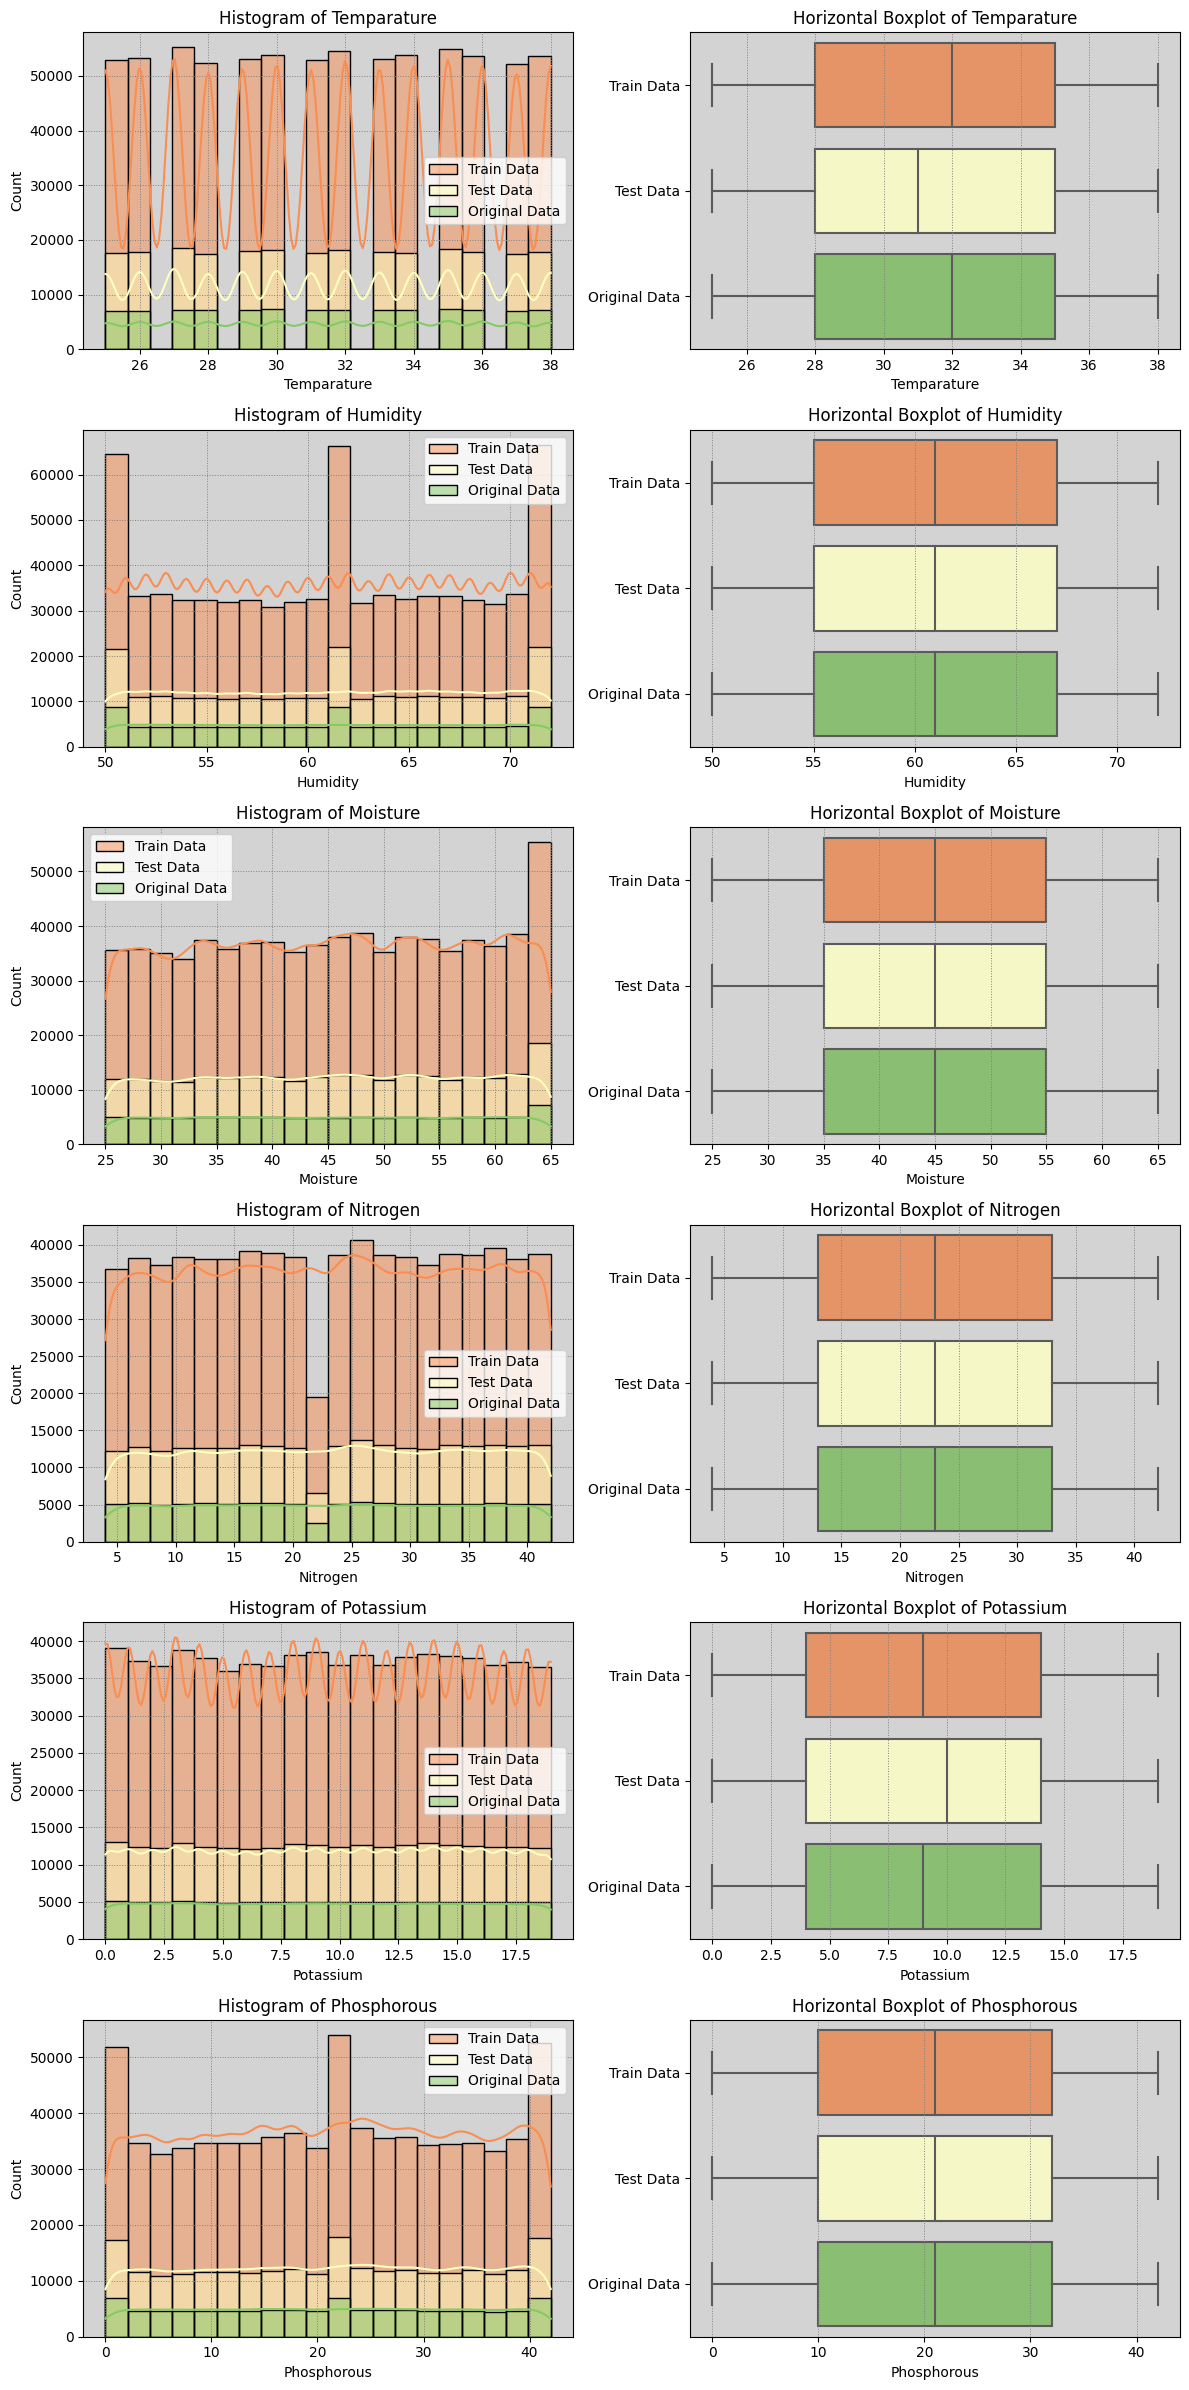

In [10]:
def plot_numerical_features(train_data, test_data, original_data, numerical_features):
    colors = sns.color_palette('RdYlGn', 3)
    fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, len(numerical_features)*4))
    axes = np.atleast_2d(axes)

    for i, feature in enumerate(numerical_features):
        sns.histplot(train_data[feature], color=colors[0], label='Train Data', bins=20, kde=True, ax=axes[i, 0])
        sns.histplot(test_data[feature], color=colors[1], label='Test Data', bins=20, kde=True, ax=axes[i, 0])
        sns.histplot(original_data[feature], color=colors[2], label='Original Data', bins=20, kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Histogram of {feature}')
        axes[i, 0].legend()
        axes[i, 0].set_facecolor("lightgray")
        axes[i, 0].grid(color='gray', linestyle=':', linewidth=0.7)

        sns.boxplot(data=[train_data[feature], test_data[feature], original_data[feature]],
                    palette=colors, orient='h', ax=axes[i, 1])
        axes[i, 1].set_title(f'Horizontal Boxplot of {feature}')
        axes[i, 1].set_yticklabels(['Train Data', 'Test Data', 'Original Data'])
        axes[i, 1].set_xlabel(feature)
        axes[i, 1].set_facecolor("lightgray")
        axes[i, 1].grid(axis='x', color='gray', linestyle=':', linewidth=0.7)

    plt.tight_layout()
    plt.show()

numerical_features = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

plot_numerical_features(train_data, test_data, original_data, numerical_features)


In [11]:
def check_skewness(data, dataset_name, highlight=True, sort=True):
    skewness_dict = {}
    for feature in data.select_dtypes(include=[np.number]).columns:
        skew = data[feature].skew(skipna=True)
        skewness_dict[feature] = skew

    skew_df = pd.DataFrame.from_dict(skewness_dict, orient='index', columns=['Skewness'])
    if sort:
        skew_df = skew_df.reindex(skew_df['Skewness'].abs().sort_values(ascending=False).index)
    
    print(f"\n🔍 Skewness for {dataset_name}:")
    print("-"*55)
    print(f"{'Feature':<18} | {'Skewness':<10} | {'Remark'}")
    print("-"*55)
    for feature, row in skew_df.iterrows():
        skew = row['Skewness']
        abs_skew = abs(skew)
        if abs_skew > 1:
            remark = "Highly skewed"
            color = '\033[91m'  
        elif abs_skew > 0.5:
            remark = "Moderately skewed"
            color = '\033[93m'  
        else:
            remark = "Approximately symmetric"
            color = ''
        endc = '\033[0m' if color else ''
        if highlight and color:
            print(f"{color}{feature:<18} | {skew:>+9.4f} | {remark}{endc}")
        else:
            print(f"{feature:<18} | {skew:>+9.4f} | {remark}")
    print("-"*55)
    return skew_df

skew_original = check_skewness(original_data, "Original Data")
skew_train = check_skewness(train_data, "Train Data")
skew_test = check_skewness(test_data, "Test Data")



🔍 Skewness for Original Data:
-------------------------------------------------------
Feature            | Skewness   | Remark
-------------------------------------------------------
Potassium          |   +0.0034 | Approximately symmetric
Phosphorous        |   -0.0034 | Approximately symmetric
Nitrogen           |   +0.0029 | Approximately symmetric
Humidity           |   +0.0026 | Approximately symmetric
Temparature        |   -0.0021 | Approximately symmetric
Moisture           |   +0.0006 | Approximately symmetric
-------------------------------------------------------

🔍 Skewness for Train Data:
-------------------------------------------------------
Feature            | Skewness   | Remark
-------------------------------------------------------
Moisture           |   -0.0182 | Approximately symmetric
Phosphorous        |   -0.0095 | Approximately symmetric
Humidity           |   -0.0081 | Approximately symmetric
Nitrogen           |   -0.0061 | Approximately symmetric
Potassium

#### Insights on Numerical Feature Distributions

**Distribution Consistency Across Datasets**

- **Histograms** and **boxplots** for all numerical features (`Temparature`, `Humidity`, `Moisture`, `Nitrogen`, `Potassium`, `Phosphorous`) show that the **train**, **test**, and **original** datasets have nearly identical distributions.
- This consistency suggests that the synthetic train/test data generation process closely matched the original data, reducing the risk of distributional shift and supporting reliable model generalization.

**Shape and Spread of Distributions**

- **Histograms** reveal that all features are distributed fairly evenly across their respective ranges, with no significant outliers or heavy tails.
- **Boxplots** confirm that the central 50% of values (the interquartile range) is similarly placed for all datasets, and the whiskers (showing the range) are nearly identical, further supporting the conclusion of consistent data generation.

**Skewness Analysis**

- The **skewness values** for all numerical features in each dataset are extremely close to zero, indicating that the distributions are **approximately symmetric**.
- No feature exhibits moderate or high skewness (|skewness| > 0.5), which means:
  - There is no need for transformations like log or Box-Cox to normalize these features.
  - Most machine learning algorithms will be able to handle these features without bias due to skewed distributions.

**Feature-Specific Observations**

- **Temperature, Humidity, and Moisture:**  
  - These environmental features are well-distributed, with no evidence of clustering or gaps in the data.
- **Nitrogen, Potassium, Phosphorous:**  
  - Soil nutrient levels also show a uniform spread, ensuring that the model can learn from a wide variety of soil conditions.



## Correlation Analysis of Numerical Features

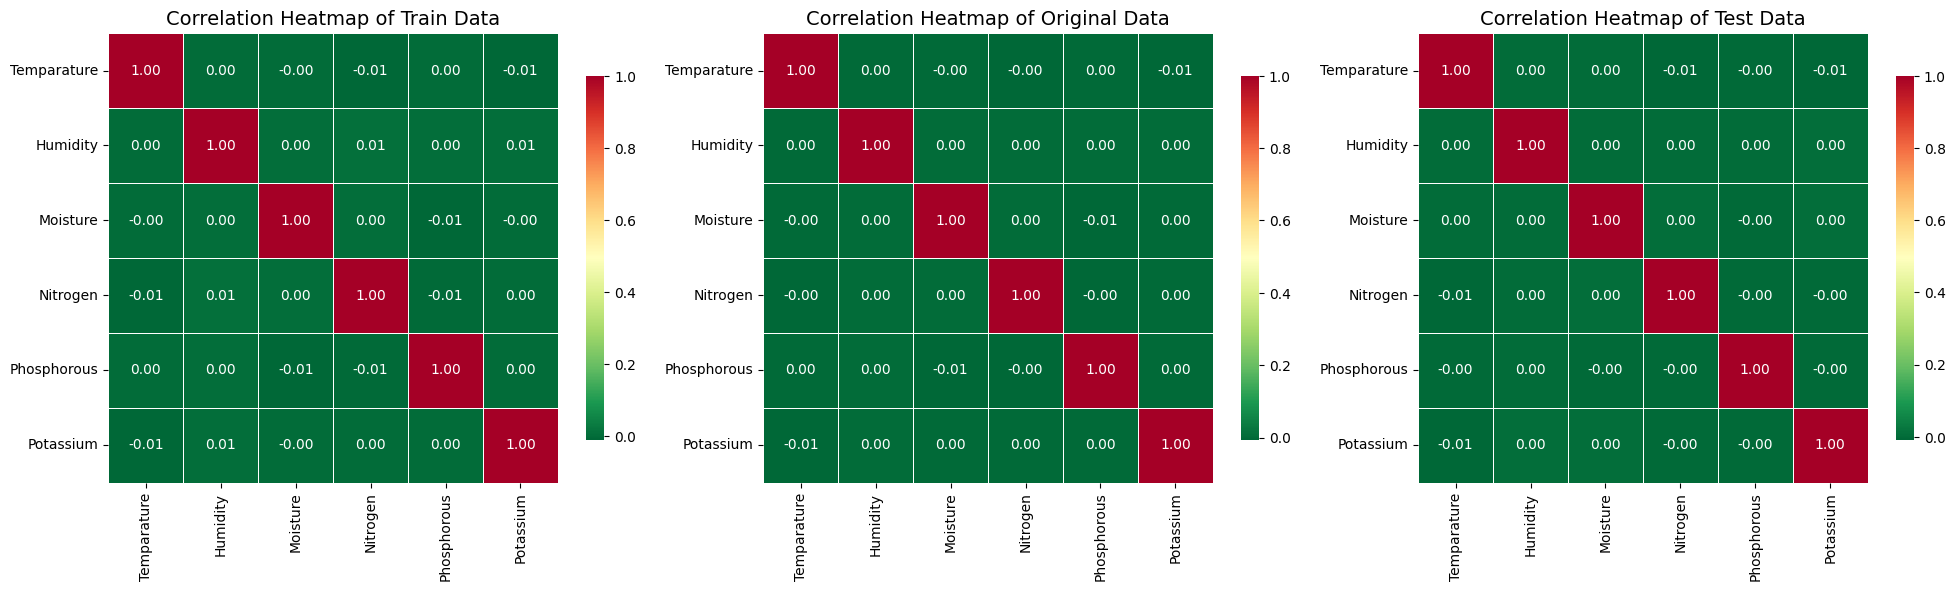

In [12]:
numerical_features = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Phosphorous', 'Potassium']

datasets = {
    "Train Data": train_data,
    "Original Data": original_data,
    "Test Data": test_data
}

fig, axes = plt.subplots(ncols=3, figsize=(20, 6))  
axs = axes.ravel() 

for i, (name, df) in enumerate(datasets.items()):
    available_features = [f for f in numerical_features if f in df.columns]
    df_subset = df[available_features]
    
    corr = df_subset.corr()
    
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="RdYlGn_r",   
        linewidths=0.5,
        square=True,
        cbar_kws={"shrink": .7},
        ax=axs[i]
    )
    axs[i].set_title(f'Correlation Heatmap of {name}', fontsize=14)

plt.tight_layout()
plt.show()


#### Insights from Correlation Analysis of Numerical Features

**Overall Weak Correlations**

- The correlation matrices for the **train**, **original**, and **test** datasets consistently show very weak correlations among the numerical features.  
- Most correlation coefficients are close to zero, indicating **little to no linear relationship** between pairs of features such as Temperature, Humidity, Moisture, Nitrogen, Phosphorous, and Potassium.

**Feature Independence**

- Features like **Temperature, Humidity, and Moisture** are essentially uncorrelated with each other and with soil nutrient levels (Nitrogen, Phosphorous, Potassium).  
- Similarly, the soil nutrients themselves show near-zero correlations, suggesting that their levels vary independently within the dataset.

**Implications for Modeling**

- The near-zero correlations imply that each numerical feature provides **unique, non-redundant information** for predicting the optimal fertilizer.  
- This independence is beneficial because it reduces multicollinearity issues in models, allowing algorithms to learn the distinct impact of each feature without confounding effects.  
- However, the lack of strong linear relationships suggests that **complex or non-linear models** (e.g., tree-based methods, neural networks) might better capture interactions or subtle patterns that linear correlation does not reveal.


## Categorical Feature Distributions

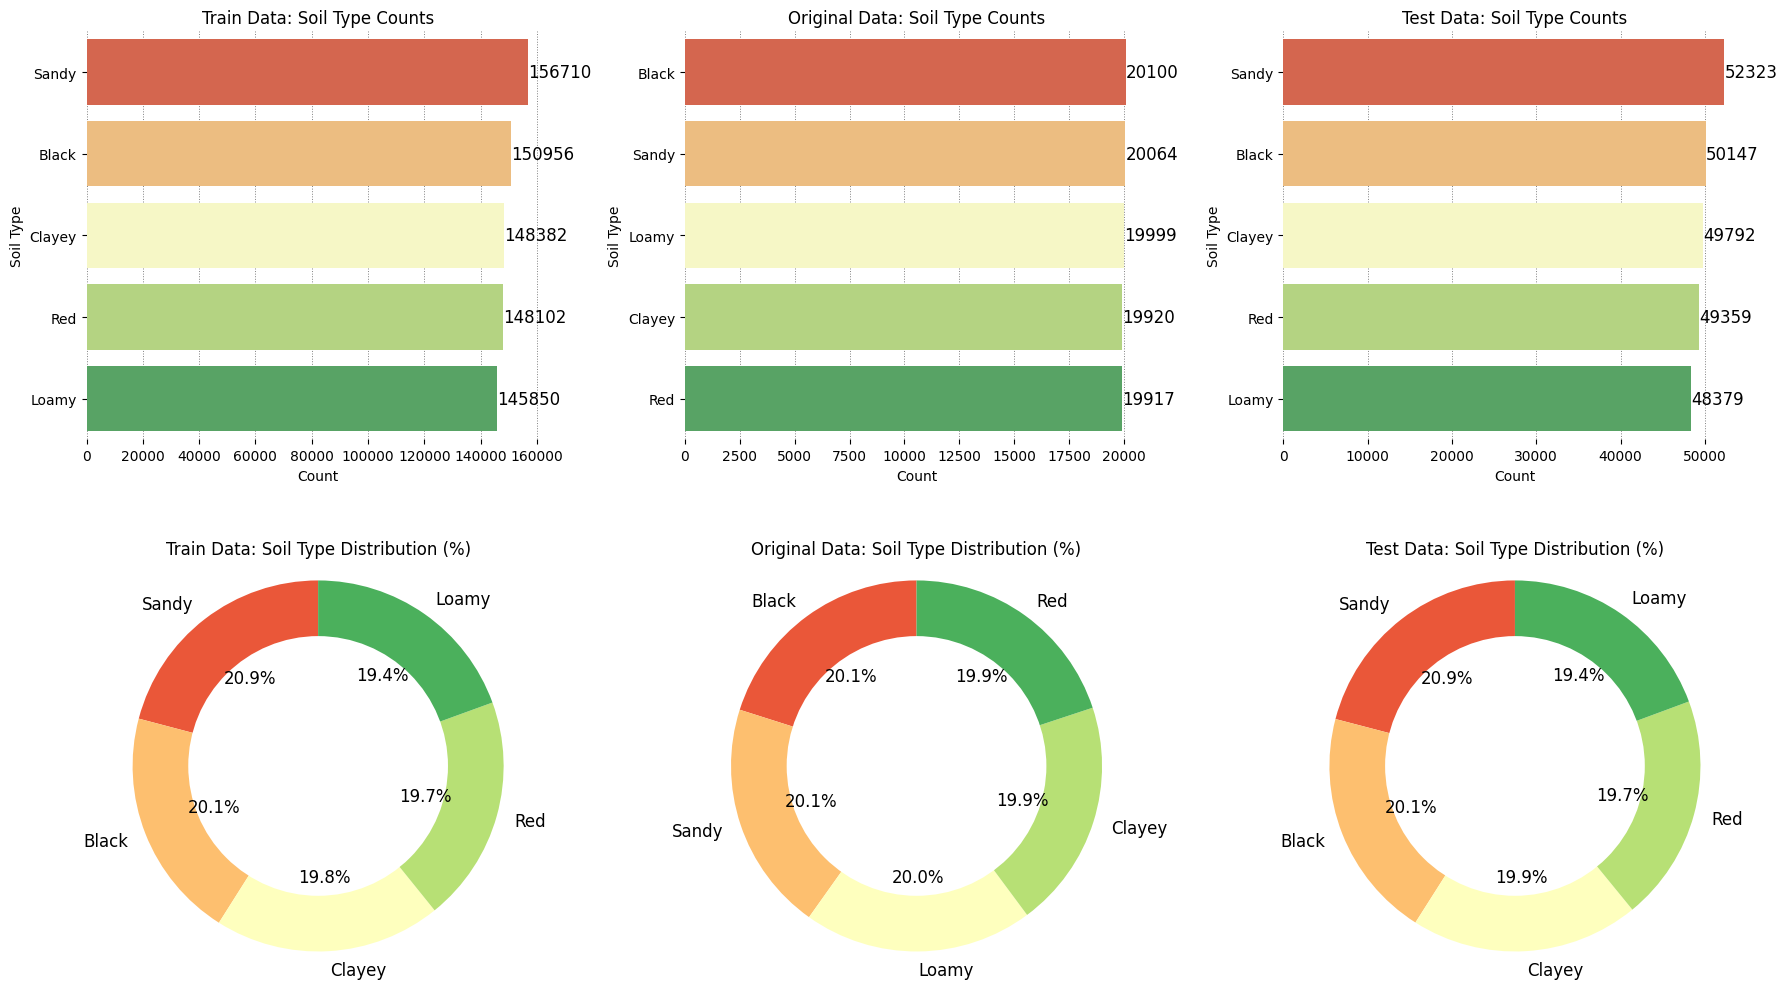

In [13]:
def plot_categorical_distribution_across_datasets(train_data, original_data, test_data, feature):
    custom_palette = sns.color_palette("RdYlGn", n_colors=train_data[feature].nunique())
    dataset_names = ['Train', 'Original', 'Test']
    datasets = [train_data, original_data, test_data]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    for i, (data, name) in enumerate(zip(datasets, dataset_names)):
        order = data[feature].value_counts().index
        sns.countplot(y=feature, data=data, ax=axes[0, i], palette=custom_palette, order=order)
        axes[0, i].set_title(f'{name} Data: {feature} Counts')
        axes[0, i].set_xlabel('Count')
        axes[0, i].set_ylabel(feature)
        
        for p in axes[0, i].patches:
            axes[0, i].annotate(f'{int(p.get_width())}', 
                               (p.get_width(), p.get_y() + p.get_height() / 2), 
                               ha='left', va='center', 
                               color='black', fontsize=12)
        axes[0, i].set_axisbelow(True)
        axes[0, i].grid(axis='x', color='gray', linestyle=':', linewidth=0.7)
        sns.despine(left=True, bottom=True, ax=axes[0, i])

    for i, (data, name) in enumerate(zip(datasets, dataset_names)):
        counts = data[feature].value_counts()
        wedges, texts, autotexts = axes[1, i].pie(
            counts,
            labels=counts.index,
            autopct='%1.1f%%',
            startangle=90,
            colors=custom_palette,
            textprops={'fontsize': 12}
        )
        centre_circle = plt.Circle((0, 0), 0.70, fc='white')
        axes[1, i].add_artist(centre_circle)
        axes[1, i].set_title(f'{name} Data: {feature} Distribution (%)')
        axes[1, i].axis('equal')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)  
    plt.show()


plot_categorical_distribution_across_datasets(train_data, original_data, test_data, 'Soil Type')


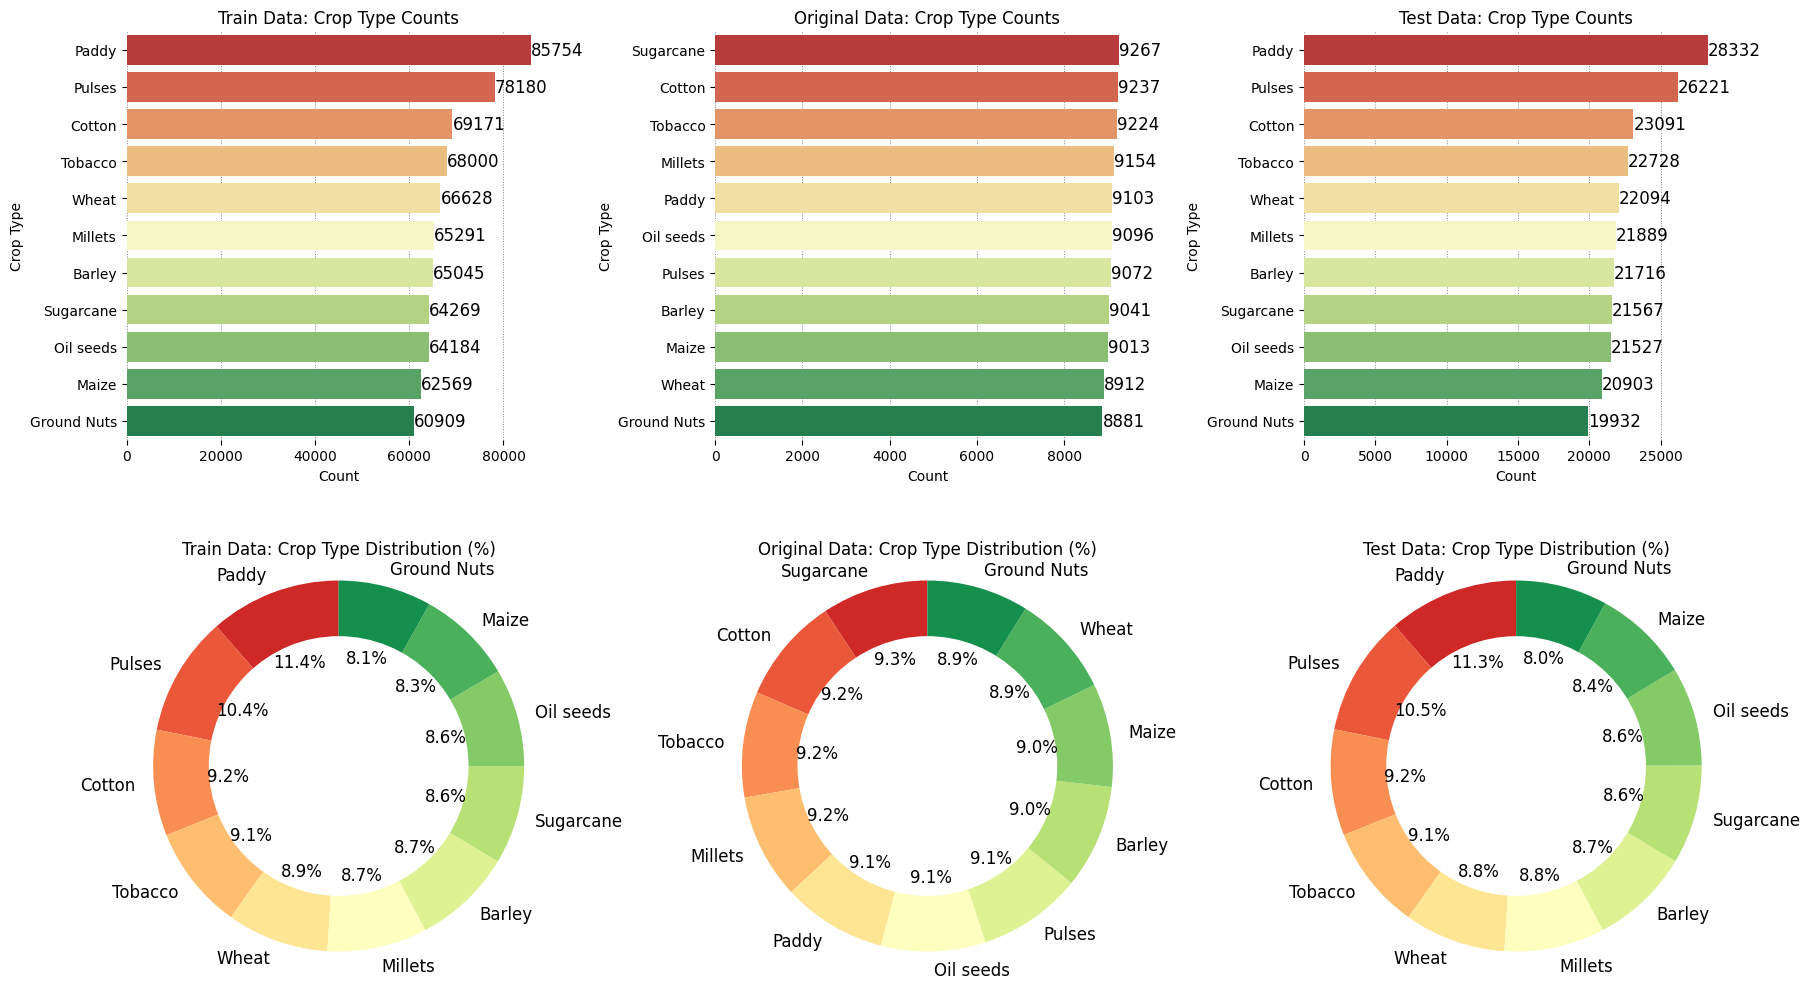

In [14]:
plot_categorical_distribution_across_datasets(train_data, original_data, test_data, 'Crop Type')


#### Insights on Soil Type and Crop Type Distributions

**Soil Type Distribution**

- The dataset contains five distinct soil types: **Sandy, Black, Clayey, Red, and Loamy**.  
- Across all datasets (Train, Original, Test), the distribution of these soil types is remarkably balanced, with each type representing roughly **19-21%** of the samples.  
- For example, in the training data, *Sandy* soil accounts for about 20.9%, and *Black* soil about 20.1%, with other types closely following.  
- This balanced representation ensures that the model will learn fertilizer recommendations across diverse soil conditions, improving its generalization.

***Different soil types have unique physical and chemical properties that affect water retention, nutrient availability, and crop suitability.***  


**Crop Type Distribution**

- The dataset includes 11 crop types, such as **Paddy, Pulses, Cotton, Tobacco, Wheat, Millets, Barley, Sugarcane, Oil seeds, Maize, and Ground Nuts**.  
- The crop distribution is fairly uniform, with no single crop dominating the dataset. For example, *Paddy* is the most frequent in train and test data (\~11.4% and \~11.3% respectively), while *Sugarcane* leads slightly in the original data (\~9.3%). 
- This diversity in crop types allows the model to learn fertilizer recommendations tailored to a wide variety of crops, which is critical since nutrient needs vary significantly by crop species.

***Crop suitability depends heavily on soil type and nutrient availability. For example, *Paddy* thrives in water-retentive soils like clay or loam, while *Millets* and *Barley* are better suited for lighter, sandy soils.  
Understanding the interaction between crop type and soil characteristics is essential for precision fertilizer recommendations that optimize yield and sustainability.***



## Feature Grouping for Fertilizer Prediction

| Group                | Features                                      | Rationale / Focus                                                                                     |
|----------------------|-----------------------------------------------|-----------------------------------------------------------------------------------------------------|
| **Climatic / Environmental** | Temperature, Humidity, Soil Moisture         | These features capture the environmental conditions influencing crop growth and fertilizer needs. Soil moisture, though related to soil, is dynamic and heavily influenced by weather and irrigation, so it fits well here. |
| **Soil Characteristics**    | Soil Type                                    | Represents the physical and chemical properties of soil that affect nutrient retention and fertilizer effectiveness. Soil type is generally static and distinct from environmental conditions. |
| **Crop Information**        | Crop Type                                    | Different crops have varying nutrient requirements and fertilizer responses, so analyzing crop type separately helps tailor recommendations. |
| **Soil Nutrients**          | Nitrogen (N), Phosphorus (P), Potassium (K) | Core macronutrients critical for plant growth; their levels directly impact fertilizer choice and dosage. These are key predictors in fertilizer recommendation models. |

#### Explanation and Justification

- **Environmental Group**:  
  Temperature, humidity, and soil moisture collectively represent the dynamic environmental context affecting nutrient uptake and fertilizer efficiency. Soil moisture is included here because it fluctuates with weather and irrigation, influencing nutrient availability and crop stress.

- **Soil Characteristics**:  
  Soil type influences water retention, aeration, and nutrient holding capacity. It is a categorical feature capturing inherent soil properties, distinct from transient environmental variables.

- **Crop Information**:  
  Crop type affects fertilizer needs due to different nutrient uptake patterns and growth cycles. Grouping it separately allows focused analysis on crop-specific fertilizer optimization.

- **Soil Nutrients**:  
  Nitrogen, phosphorus, and potassium are the primary macronutrients targeted by fertilizers. Their measured levels provide direct signals for fertilizer recommendations.

In [15]:
# Define feature groups

env_features = ['Temparature', 'Humidity', 'Moisture']
soil_feature = 'Soil Type'
crop_feature = 'Crop Type'
nutrient_features = ['Nitrogen', 'Phosphorous', 'Potassium']

## Environmental Feature Levels by Fertilizer Classes

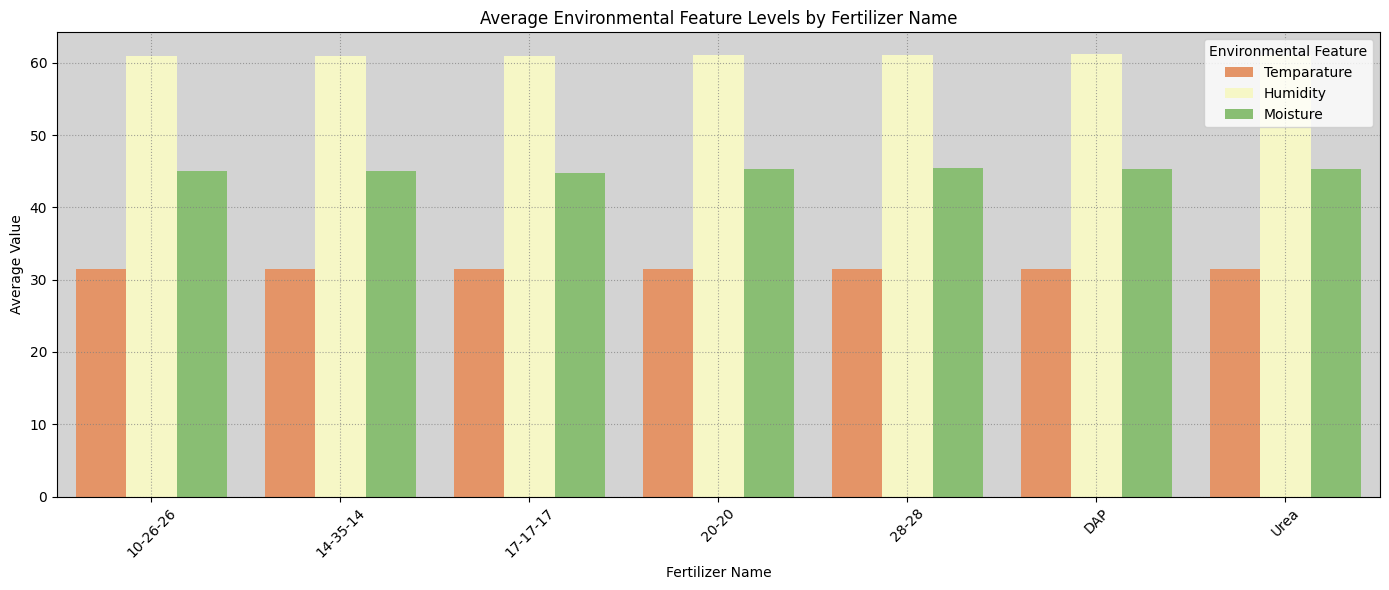

In [16]:
mean_env = train_data.groupby(target_variable)[env_features].mean().reset_index()
mean_env_melted = mean_env.melt(id_vars=target_variable, var_name='Environmental Feature', value_name='Mean Value')

fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=mean_env_melted, x=target_variable, y='Mean Value', hue='Environmental Feature', palette='RdYlGn', ax=ax)
ax.set_title(f'Average Environmental Feature Levels by {target_variable}')
ax.set_xlabel(target_variable)
ax.set_ylabel('Average Value')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Environmental Feature')
ax.set_facecolor('lightgray') 
ax.grid(color='gray', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()


In [17]:
def env_summary_by_fertilizer(df, target_variable, env_features):
    print("=" * 65)
    print(f"Summary Statistics of Environmental Features by {target_variable}")
    print("=" * 65)
    
    for feature in env_features:
        summary_stats = df.groupby(target_variable)[feature].describe().round(2)
        print(f"\n--- {feature} ---\n")
        display(summary_stats)

env_summary_by_fertilizer(train_data, 'Fertilizer Name', env_features)


Summary Statistics of Environmental Features by Fertilizer Name

--- Temparature ---



count   mean   std   min   25%   50%   75%   max
Fertilizer Name                                                     
10-26-26         113887.0  31.47  4.04  25.0  28.0  32.0  35.0  38.0
14-35-14         114436.0  31.54  4.00  25.0  28.0  32.0  35.0  38.0
17-17-17         112453.0  31.46  4.03  25.0  28.0  31.0  35.0  38.0
20-20            110889.0  31.51  4.03  25.0  28.0  31.0  35.0  38.0
28-28            111158.0  31.52  4.03  25.0  28.0  32.0  35.0  38.0
DAP               94860.0  31.51  4.05  25.0  28.0  32.0  35.0  38.0
Urea              92317.0  31.51  4.00  25.0  28.0  32.0  35.0  38.0


--- Humidity ---



count   mean   std   min   25%   50%   75%   max
Fertilizer Name                                                     
10-26-26         113887.0  60.94  6.64  50.0  55.0  61.0  67.0  72.0
14-35-14         114436.0  60.96  6.64  50.0  55.0  61.0  67.0  72.0
17-17-17         112453.0  61.00  6.61  50.0  55.0  61.0  67.0  72.0
20-20            110889.0  61.10  6.66  50.0  55.0  61.0  67.0  72.0
28-28            111158.0  61.01  6.65  50.0  55.0  61.0  67.0  72.0
DAP               94860.0  61.16  6.67  50.0  55.0  61.0  67.0  72.0
Urea              92317.0  61.14  6.65  50.0  55.0  61.0  67.0  72.0


--- Moisture ---



count   mean    std   min   25%   50%   75%   max
Fertilizer Name                                                      
10-26-26         113887.0  45.08  11.79  25.0  35.0  45.0  55.0  65.0
14-35-14         114436.0  45.10  11.79  25.0  35.0  45.0  55.0  65.0
17-17-17         112453.0  44.74  11.76  25.0  35.0  45.0  55.0  65.0
20-20            110889.0  45.32  11.77  25.0  35.0  45.0  55.0  65.0
28-28            111158.0  45.50  11.85  25.0  35.0  46.0  56.0  65.0
DAP               94860.0  45.26  11.86  25.0  35.0  46.0  55.0  65.0
Urea              92317.0  45.34  11.73  25.0  35.0  46.0  56.0  65.0

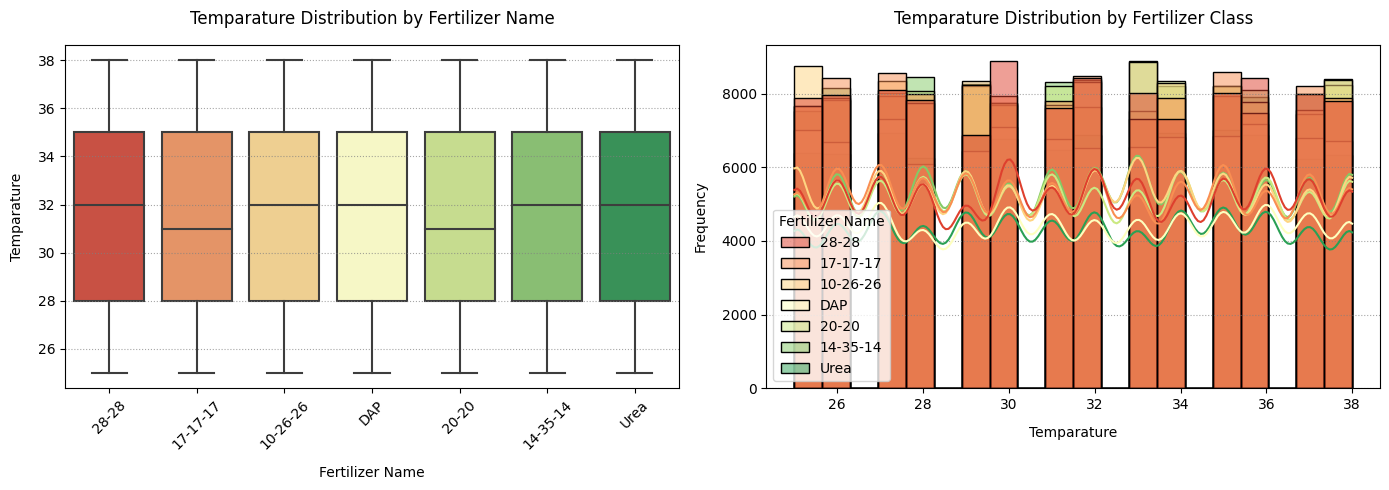

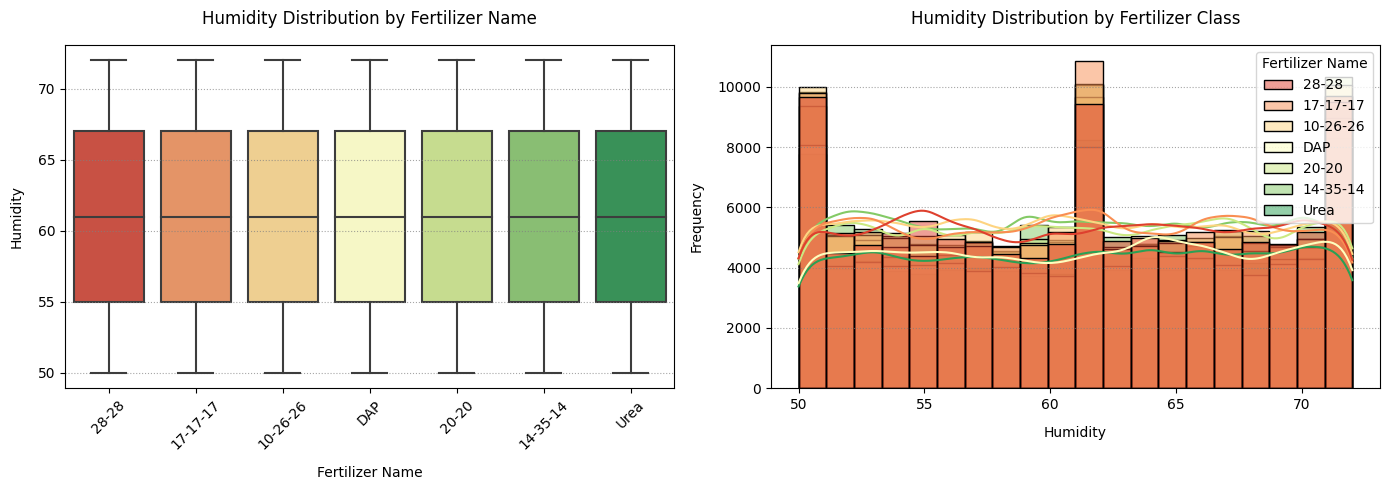

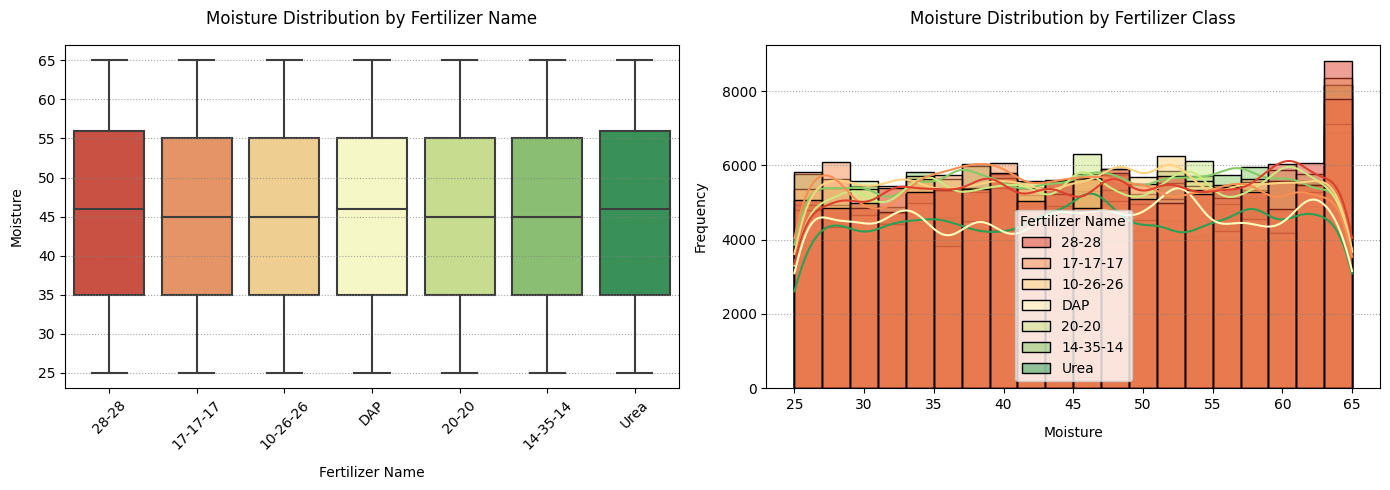

In [18]:
custom_palette = sns.color_palette("RdYlGn", len(train_data[target_variable].unique()))

for feature in env_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.boxplot(x=target_variable, y=feature, data=train_data, 
                palette=custom_palette, ax=axes[0])
    axes[0].set_title(f'{feature} Distribution by Fertilizer Name', pad=15)
    axes[0].set_xlabel('Fertilizer Name', labelpad=10)
    axes[0].set_ylabel(feature, labelpad=10)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', color='gray', linestyle=':', alpha=0.7)
    
    sns.histplot(data=train_data, x=feature, hue=target_variable, 
                 bins=20, palette=custom_palette, ax=axes[1], kde=True)
    axes[1].set_title(f'{feature} Distribution by Fertilizer Class', pad=15)
    axes[1].set_xlabel(feature, labelpad=10)
    axes[1].set_ylabel('Frequency', labelpad=10)
    axes[1].grid(axis='y', color='gray', linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


#### Insights on Environmental Feature Levels by Fertilizer Type

**Overview of Environmental Conditions Across Fertilizers**

- The average levels of key environmental features—**Temperature, Humidity, and Soil Moisture**—were analyzed for each fertilizer type in the training dataset.  
- The barplot visualization shows that these environmental variables have **very similar mean values across all fertilizer classes**, indicating that fertilizers are applied under broadly comparable environmental conditions.

**Detailed Summary Statistics**

- The summary statistics confirm that for **Temperature**, the mean values for all fertilizer types hover around **31.5°C**, with minimum and maximum values spanning from 25°C to 38°C.  
- **Humidity** averages range narrowly between approximately **60.9% and 61.2%**, with a consistent spread across fertilizers.  
- **Soil Moisture** shows slightly more variation, with mean values between **44.7 and 45.5**, but overall the distributions are quite close.  
- The standard deviations and quartiles for these features are also similar across fertilizer types, suggesting uniform environmental conditions during fertilizer application.

**Distribution Patterns**

- The boxplots and histograms further illustrate that the distributions of temperature, humidity, and moisture overlap substantially among fertilizer classes.  
- This implies that environmental factors alone do not strongly differentiate fertilizer usage in this dataset, and other factors such as soil nutrients and crop type likely play a more decisive role in fertilizer selection.



## Soil Type Distribution Across Fertilizer Classes

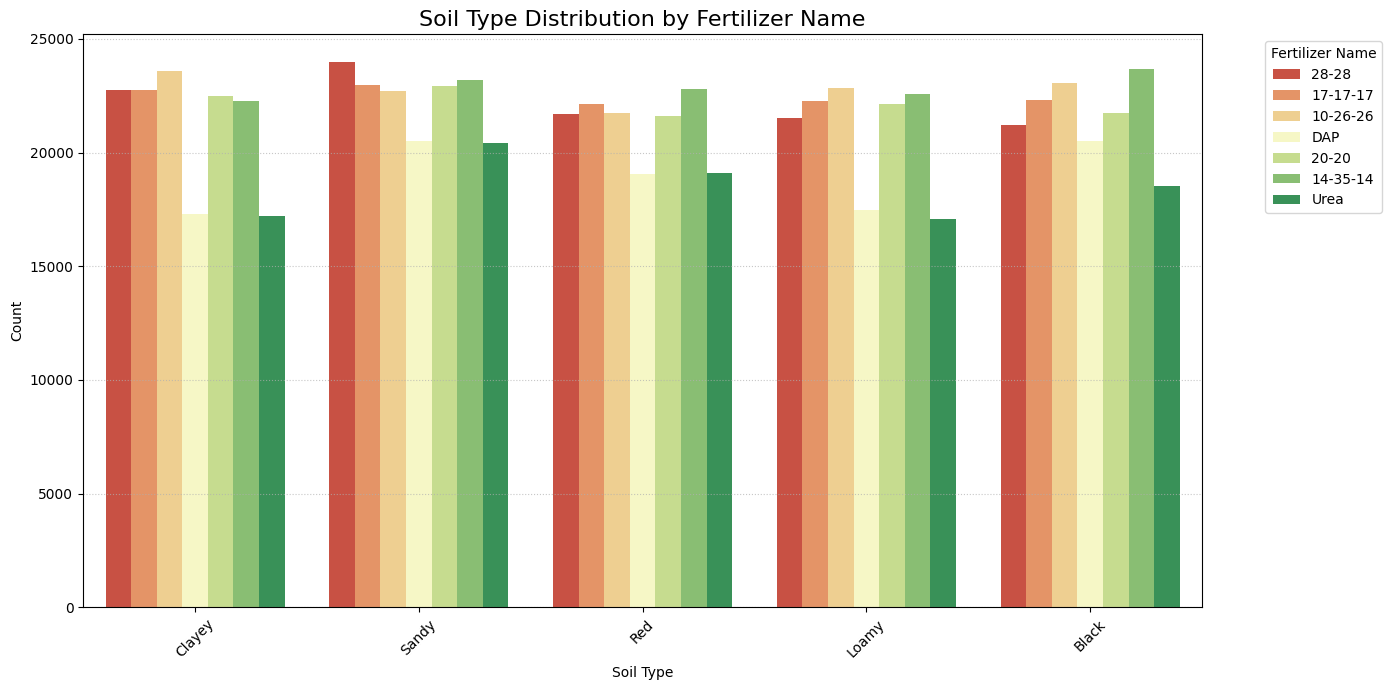

In [19]:
custom_palette = sns.color_palette("RdYlGn", n_colors=train_data[target_variable].nunique())

def plot_categorical_vs_target(data, category_feature, target_feature, palette):
    plt.figure(figsize=(14, 7))
    ax = sns.countplot(x=category_feature, hue=target_feature, data=data, palette=palette)
    plt.title(f'{category_feature} Distribution by {target_feature}', fontsize=16)
    plt.xlabel(category_feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    
    plt.legend(title=target_feature, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot Soil Type vs Fertilizer Name
plot_categorical_vs_target(train_data, soil_feature, target_variable, custom_palette)

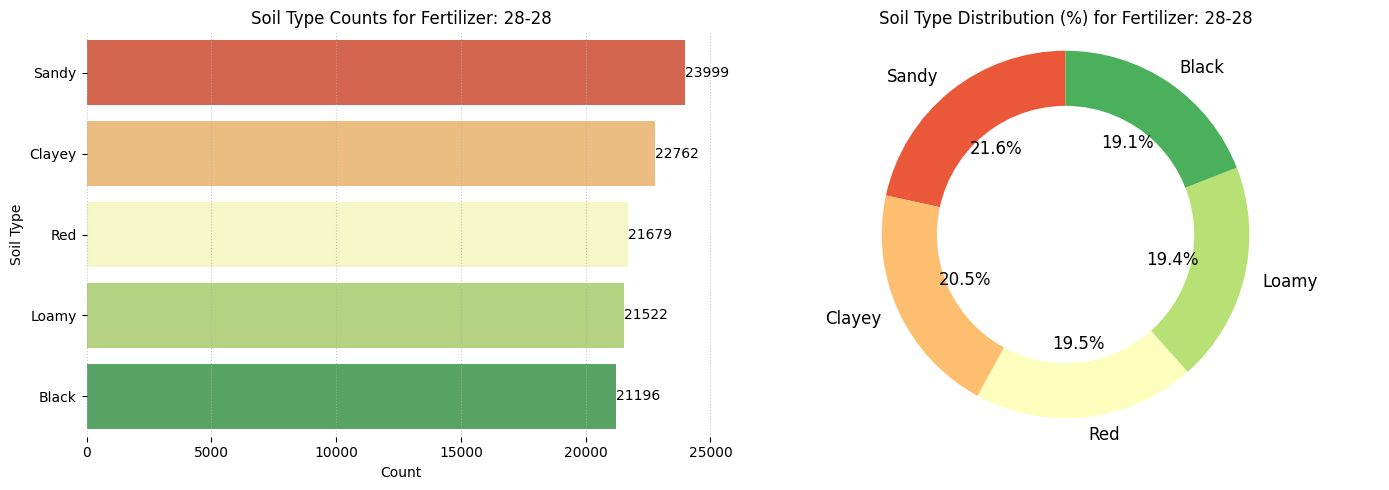

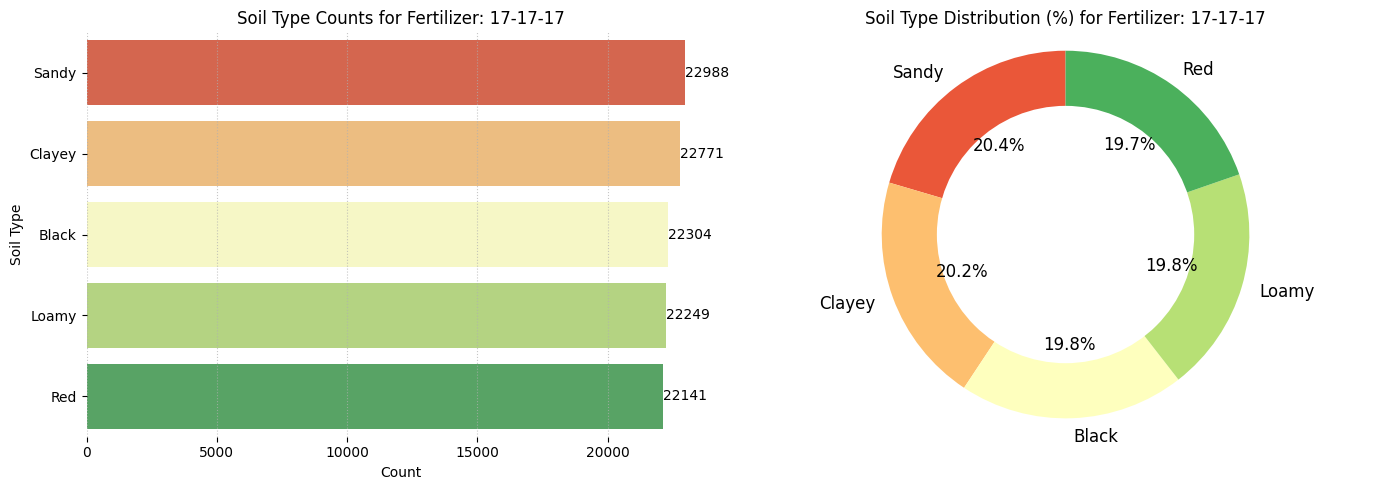

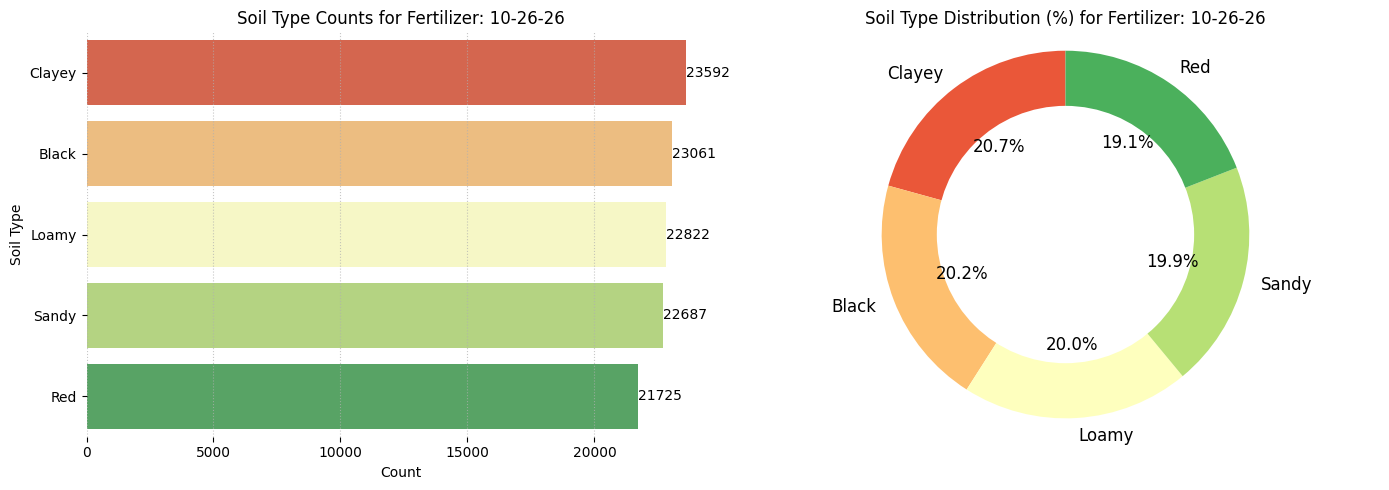

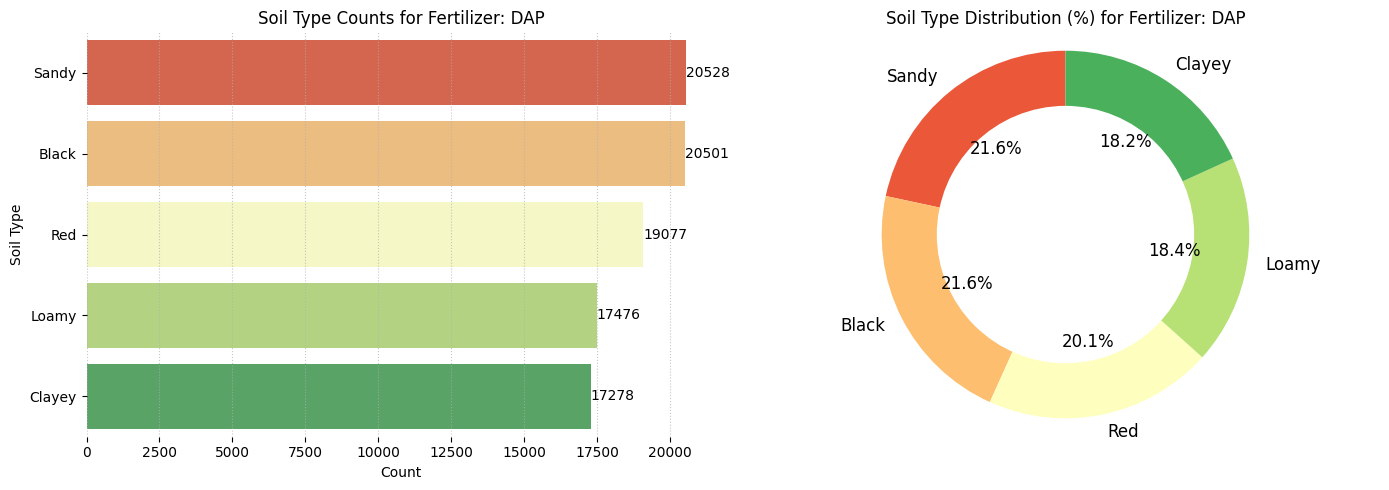

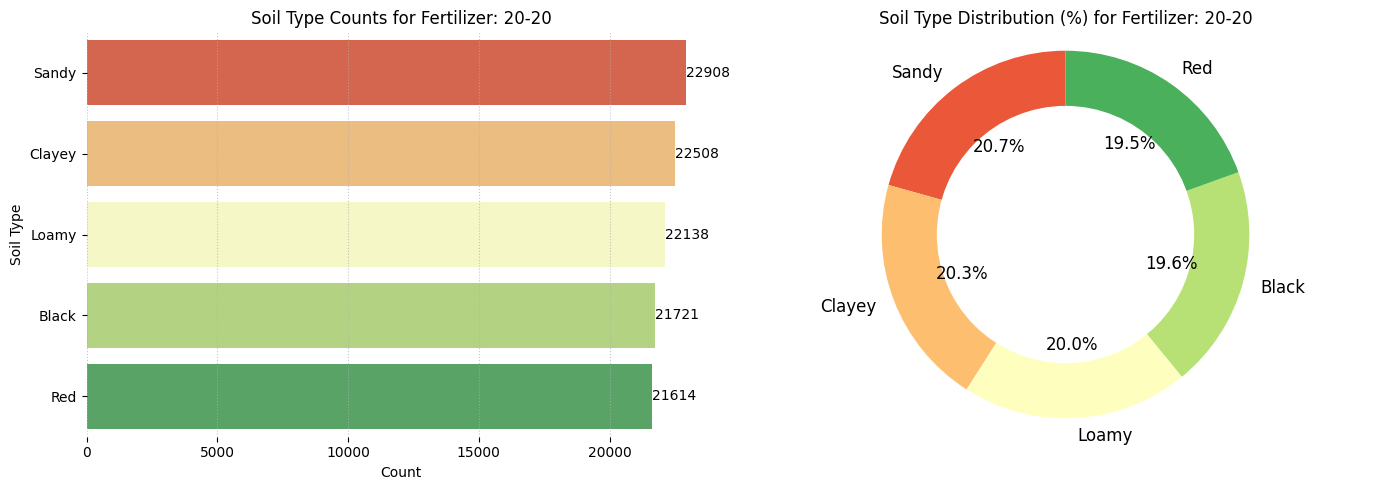

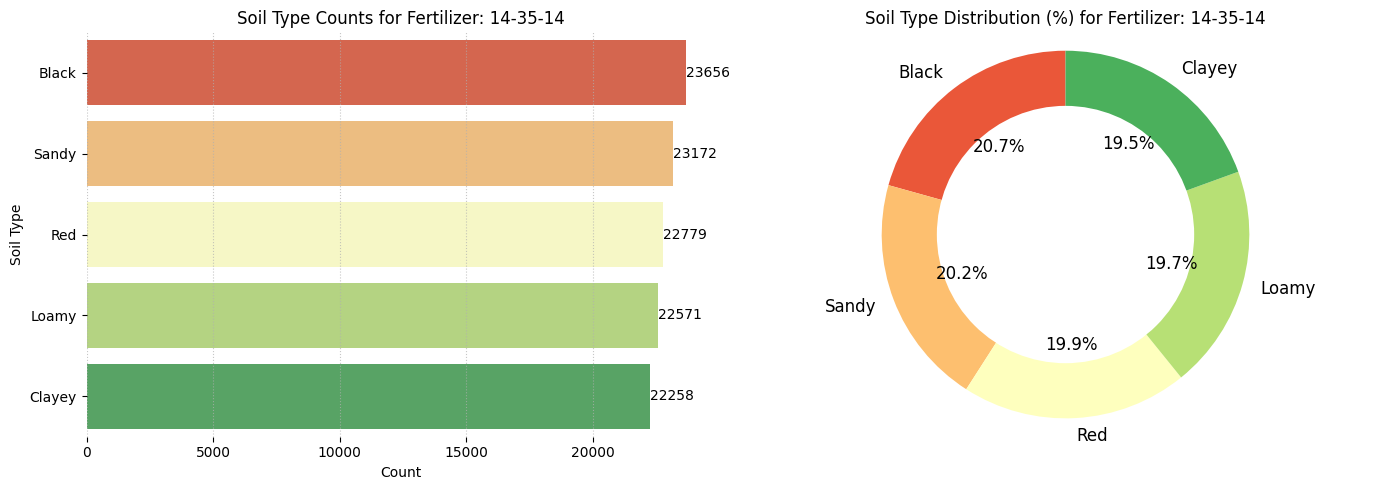

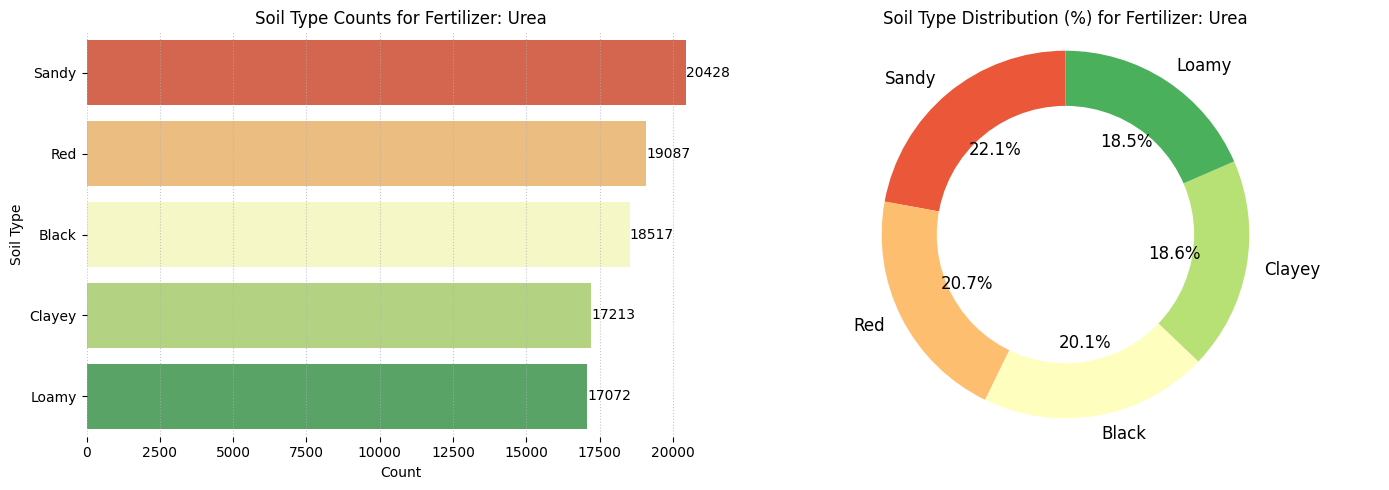

In [20]:
def plot_soil_type_distribution_by_fertilizer(data, fertilizer_class):
    filtered_data = data[data['Fertilizer Name'] == fertilizer_class]
    
    soil_order = filtered_data['Soil Type'].value_counts().index.tolist()
    
    palette = sns.color_palette("RdYlGn", n_colors=len(soil_order))
    color_mapping = dict(zip(soil_order, palette))
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.countplot(y='Soil Type', data=filtered_data, order=soil_order, 
                  palette=color_mapping, ax=ax[0])
    ax[0].set_title(f'Soil Type Counts for Fertilizer: {fertilizer_class}')
    ax[0].set_xlabel('Count')
    ax[0].set_ylabel('Soil Type')
    
    for p in ax[0].patches:
        ax[0].annotate(f'{int(p.get_width())}',
                       (p.get_width(), p.get_y() + p.get_height() / 2),
                       ha='left', va='center',
                       fontsize=10, color='black')
    ax[0].grid(axis='x', linestyle=':', alpha=0.7)
    sns.despine(left=True, bottom=True, ax=ax[0])
    
    soil_counts = filtered_data['Soil Type'].value_counts().reindex(soil_order)
    wedges, texts, autotexts = ax[1].pie(
        soil_counts,
        labels=soil_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=[color_mapping[soil] for soil in soil_counts.index],
        textprops={'fontsize': 12}
    )
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax[1].add_artist(centre_circle)
    ax[1].set_title(f'Soil Type Distribution (%) for Fertilizer: {fertilizer_class}')
    ax[1].axis('equal')
    
    plt.tight_layout()
    plt.show()

unique_fertilizers = train_data['Fertilizer Name'].unique()
for fertilizer in unique_fertilizers:
    plot_soil_type_distribution_by_fertilizer(train_data, fertilizer)

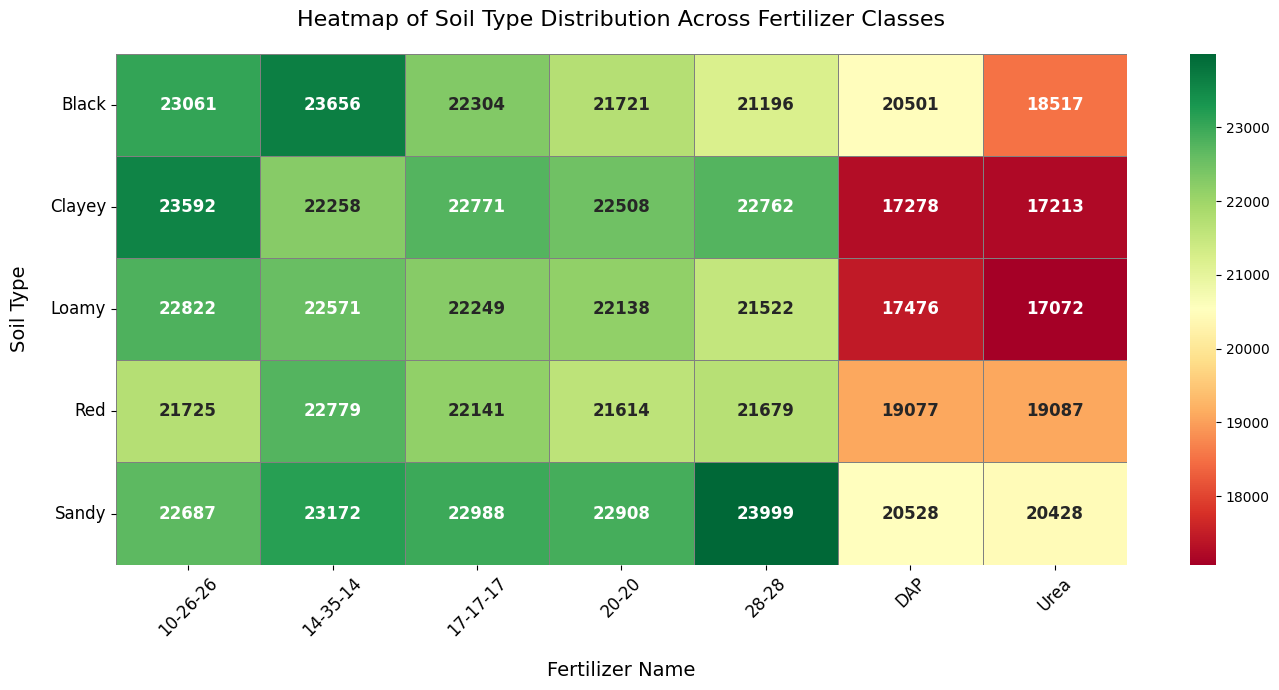

In [21]:
# Calculate cross tabulation of Soil Type vs Fertilizer Name
soil_fertilizer_crosstab = pd.crosstab(train_data['Soil Type'], train_data['Fertilizer Name'])

plt.figure(figsize=(14, 7))

heatmap = sns.heatmap(
    soil_fertilizer_crosstab,
    annot=True,
    fmt='d',
    cmap='RdYlGn',
    linewidths=0.5,
    linecolor='gray',
    annot_kws={"size": 12, "weight": "bold"}  
)

heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=12, rotation=45)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=12, rotation=0)

plt.title('Heatmap of Soil Type Distribution Across Fertilizer Classes', fontsize=16, pad=20)
plt.xlabel('Fertilizer Name', fontsize=14, labelpad=15)
plt.ylabel('Soil Type', fontsize=14, labelpad=15)

plt.tight_layout()
plt.show()


#### Insights on Soil Type Distribution Across Fertilizer Classes

**Soil Type Distribution by Fertilizer**

- The distribution of soil types within each fertilizer class is relatively balanced, with all five soil types—**Sandy, Black, Clayey, Red, and Loamy**—represented in similar proportions.  
- For example, for the fertilizer **Urea**, *Sandy* soil accounts for about 22.1% of the samples, followed closely by *Red* (20.7%), *Black* (20.1%), *Clayey* (18.7%), and *Loamy* (18.5%).  
- Similar balanced distributions are observed across other fertilizer classes such as `28-28`, `17-17-17`, `10-26-26`, `DAP`, `20-20`, and `14-35-14`.

**Cross-Tabulation and Heatmap Analysis**

- The cross-tabulation of **Soil Type vs Fertilizer Name** confirms that no single soil type overwhelmingly dominates any fertilizer class.  
- The heatmap visualization further illustrates this balanced distribution, with counts fairly evenly spread across soil-fertilizer pairs, indicating that fertilizer recommendations are not restricted to specific soil types alone.

**Agronomic Interpretation**

- This balanced soil distribution across fertilizer classes suggests that fertilizer recommendations are tailored considering multiple factors beyond just soil type, such as crop type, nutrient levels, and environmental conditions.  
- Different soil types have distinct physical and chemical properties affecting nutrient availability and fertilizer effectiveness. For instance:  
  - *Sandy* soils drain quickly and may require more frequent fertilization.  
  - *Clayey* soils retain nutrients longer but may limit root penetration.  
  - *Loamy* soils are generally fertile and well-balanced.  
- The presence of all soil types across fertilizers reflects a comprehensive approach to fertilizer application that considers diverse soil conditions.

## Fertilizer Usage Across Crop Types

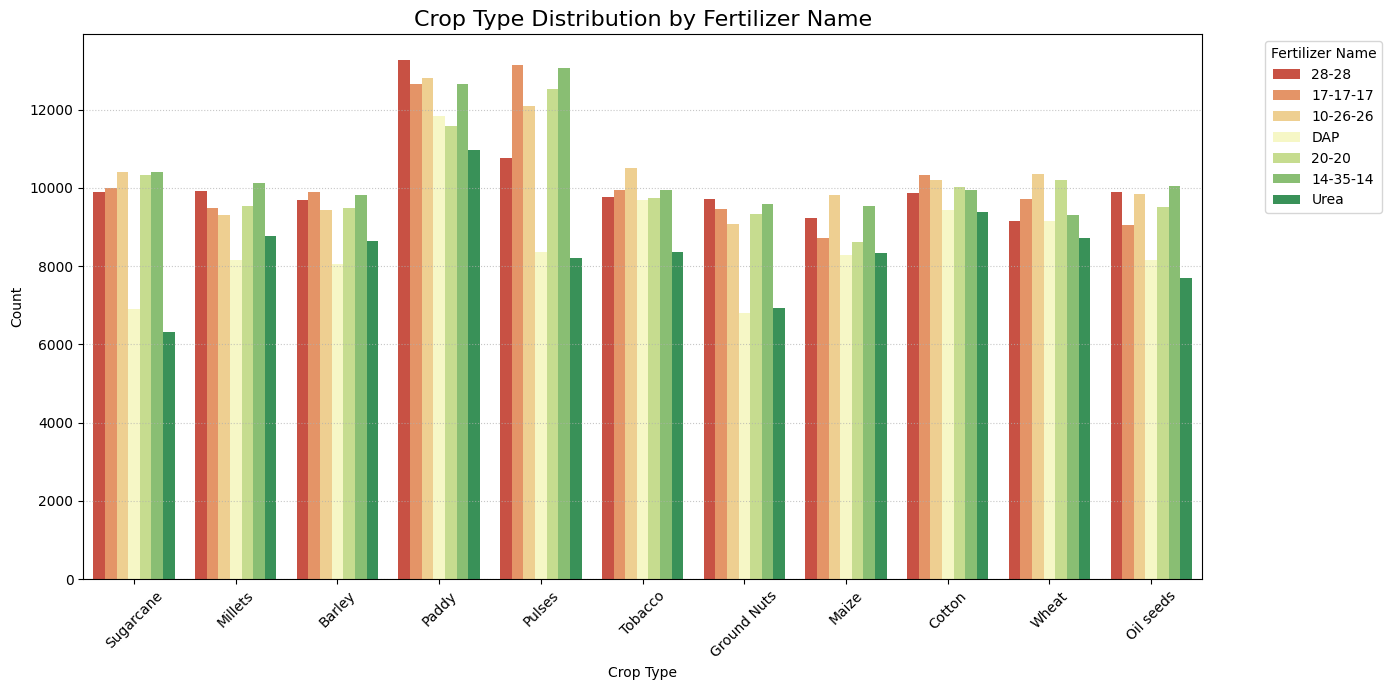

In [22]:
# Plot Crop Type vs Fertilizer Name
plot_categorical_vs_target(train_data, crop_feature, target_variable, custom_palette)


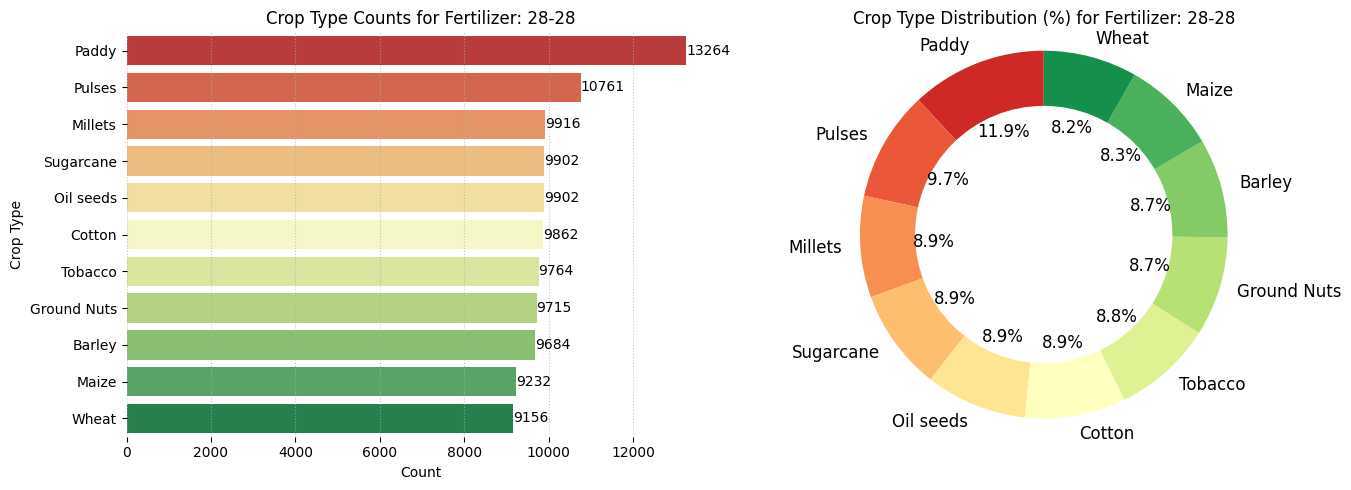

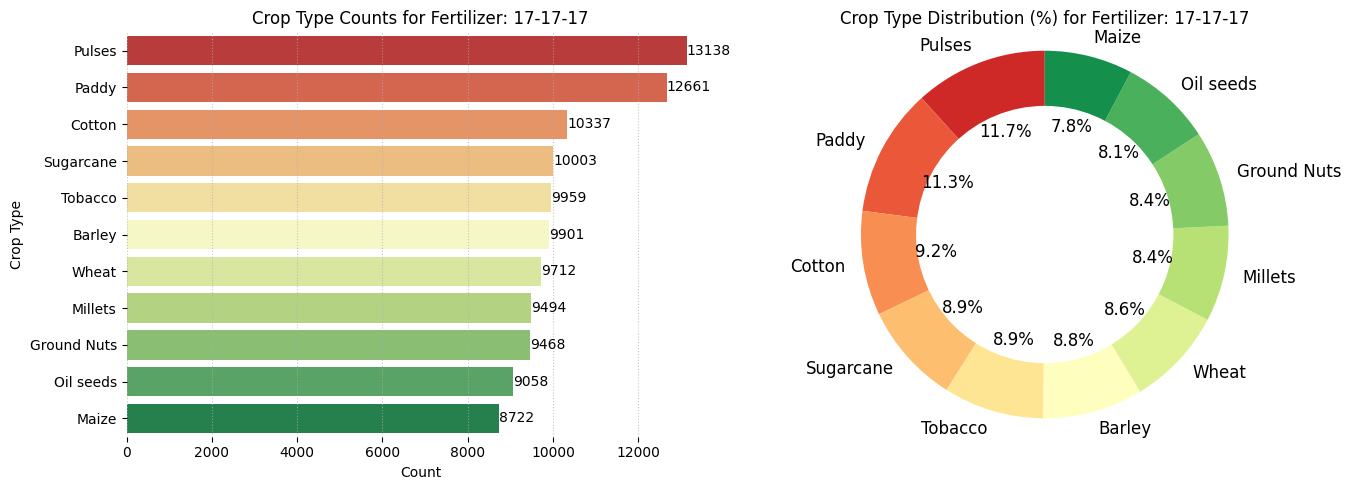

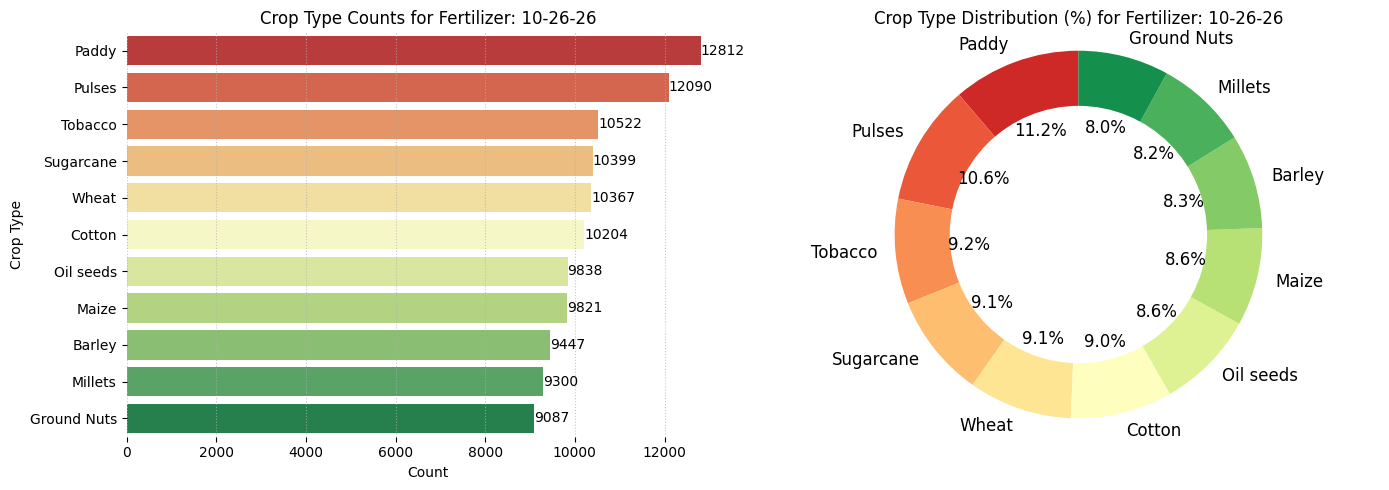

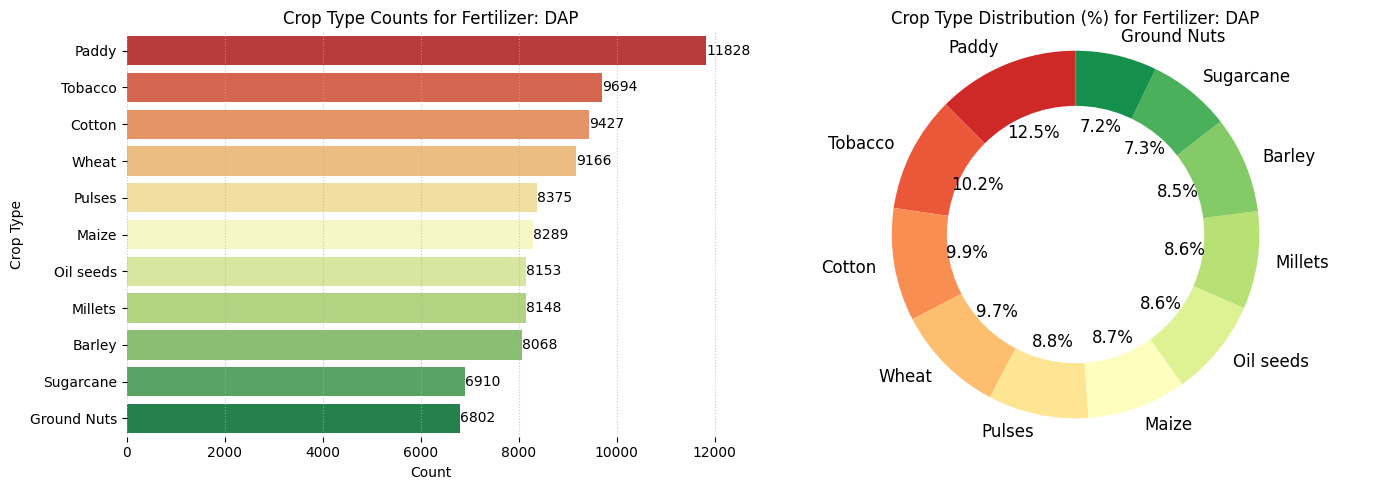

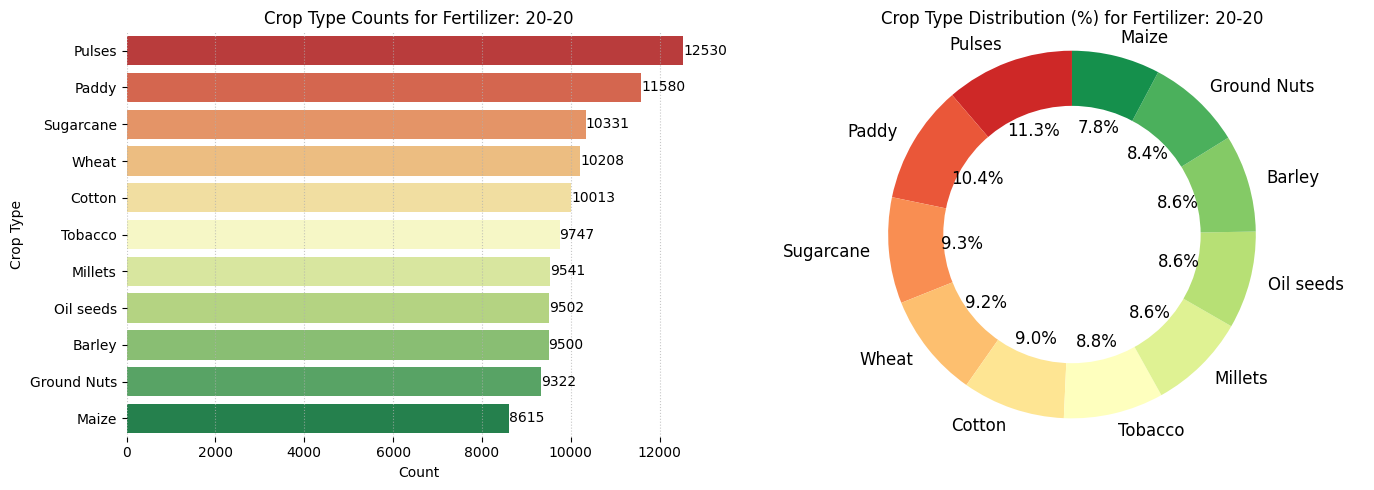

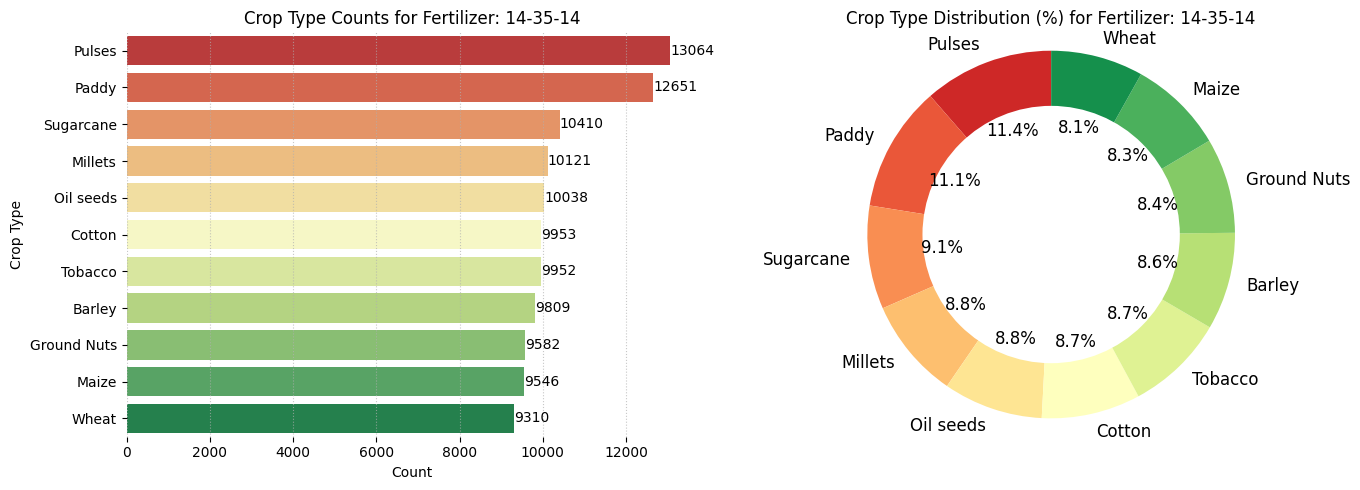

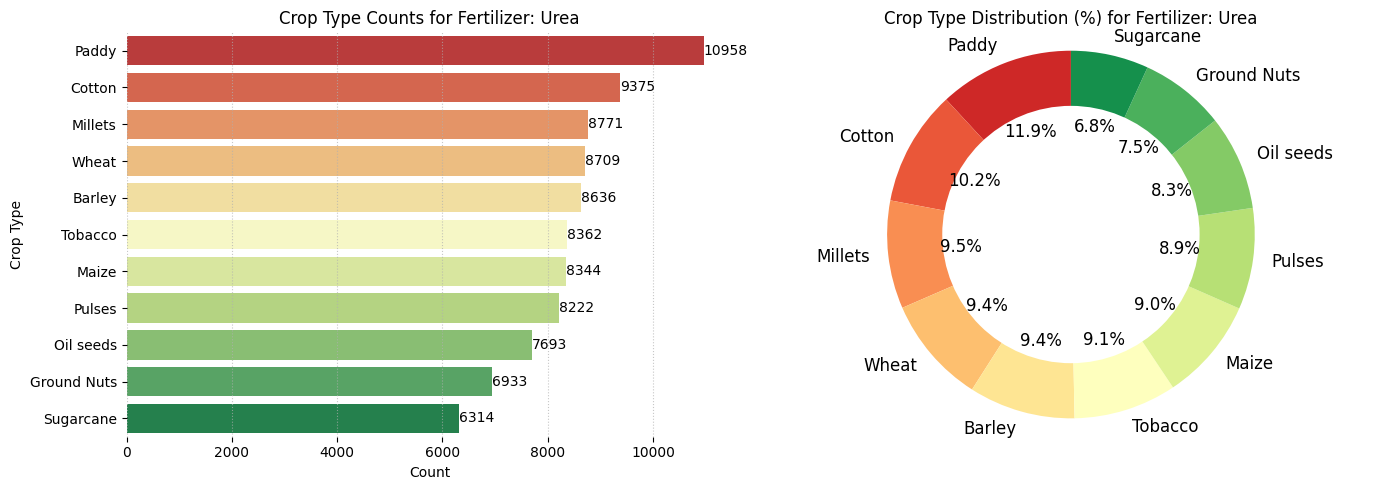

In [23]:
def plot_crop_type_distribution_by_fertilizer(data, fertilizer_class):
    filtered_data = data[data['Fertilizer Name'] == fertilizer_class]
    
    crop_order = filtered_data['Crop Type'].value_counts().index.tolist()
    
    palette = sns.color_palette("RdYlGn", n_colors=len(crop_order))
    color_mapping = dict(zip(crop_order, palette))
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.countplot(y='Crop Type', data=filtered_data, order=crop_order, 
                  palette=color_mapping, ax=ax[0])
    ax[0].set_title(f'Crop Type Counts for Fertilizer: {fertilizer_class}')
    ax[0].set_xlabel('Count')
    ax[0].set_ylabel('Crop Type')
    
    for p in ax[0].patches:
        ax[0].annotate(f'{int(p.get_width())}',
                       (p.get_width(), p.get_y() + p.get_height() / 2),
                       ha='left', va='center',
                       fontsize=10, color='black')
    ax[0].grid(axis='x', linestyle=':', alpha=0.7)
    sns.despine(left=True, bottom=True, ax=ax[0])
    
    crop_counts = filtered_data['Crop Type'].value_counts().reindex(crop_order)
    wedges, texts, autotexts = ax[1].pie(
        crop_counts,
        labels=crop_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=[color_mapping[crop] for crop in crop_counts.index],
        textprops={'fontsize': 12}
    )
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax[1].add_artist(centre_circle)
    ax[1].set_title(f'Crop Type Distribution (%) for Fertilizer: {fertilizer_class}')
    ax[1].axis('equal')
    
    plt.tight_layout()
    plt.show()

unique_fertilizers = train_data['Fertilizer Name'].unique()
for fertilizer in unique_fertilizers:
    plot_crop_type_distribution_by_fertilizer(train_data, fertilizer)


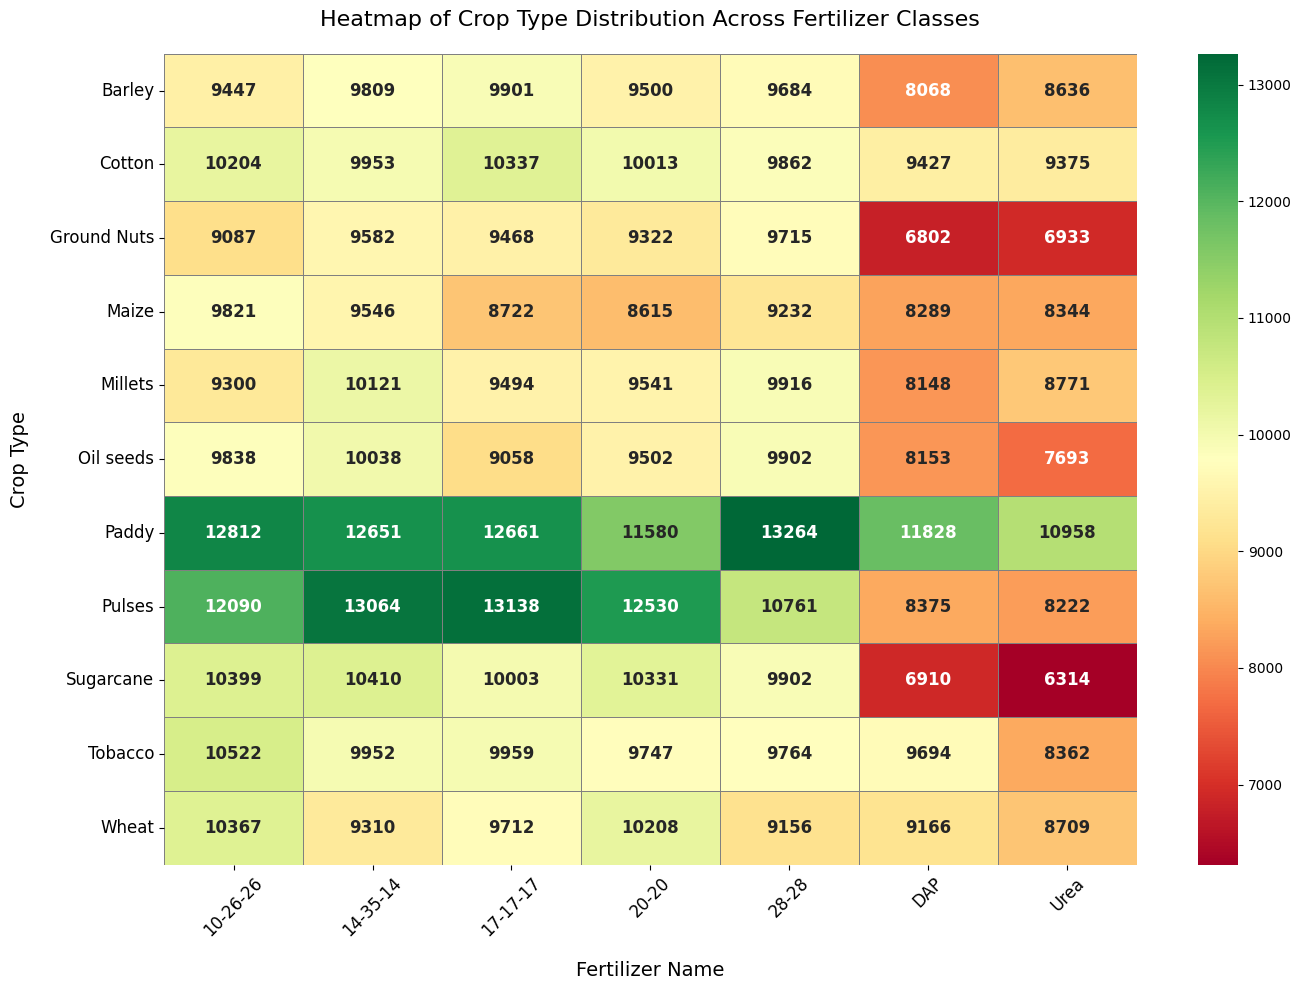

In [24]:
# Calculate cross tabulation of Crop Type vs Fertilizer Name
crop_fertilizer_crosstab = pd.crosstab(train_data['Crop Type'], train_data['Fertilizer Name'])

plt.figure(figsize=(14, 10))

heatmap = sns.heatmap(
    crop_fertilizer_crosstab,
    annot=True,
    fmt='d',
    cmap='RdYlGn',
    linewidths=0.5,
    linecolor='gray',
    annot_kws={"size": 12, "weight": "bold"}  
)

heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=12, rotation=45)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=12, rotation=0)

plt.title('Heatmap of Crop Type Distribution Across Fertilizer Classes', fontsize=16, pad=20)
plt.xlabel('Fertilizer Name', fontsize=14, labelpad=15)
plt.ylabel('Crop Type', fontsize=14, labelpad=15)

plt.tight_layout()
plt.show()


#### Insights on Fertilizer Usage Across Crop Types

**Distribution of Fertilizer Types by Crop**

- The dataset reveals that fertilizer application is broadly distributed across the 11 crop types, with no single fertilizer dominating any particular crop category.  
- For major crops like **Paddy**, **Pulses**, **Cotton**, **Tobacco**, and **Wheat**, all seven fertilizer types are used in substantial quantities, reflecting diverse fertilizer management practices tailored to crop needs.  
- For example, *Paddy* shows the highest counts for fertilizers such as `28-28` (13,264), `17-17-17` (12,661), and `10-26-26` (12,812), indicating its significant nutrient demands and varied fertilization strategies.

**Crop-Specific Fertilizer Preferences**

- While fertilizer usage is fairly balanced, some subtle preferences emerge:  
  - **Pulses** tend to have a slightly higher proportion of `17-17-17` and `14-35-14` fertilizers, which may relate to their nitrogen-fixing properties and nutrient requirements.  
  - **Sugarcane** and **Tobacco** show consistent use across fertilizers but with slightly lower counts for `Urea`, possibly reflecting crop-specific nitrogen management.  
  - **Maize** and **Ground Nuts** have relatively lower fertilizer counts overall, which might be due to crop rotation practices or soil fertility considerations.



## Soil Nutrient Levels by Fertilizer Classes

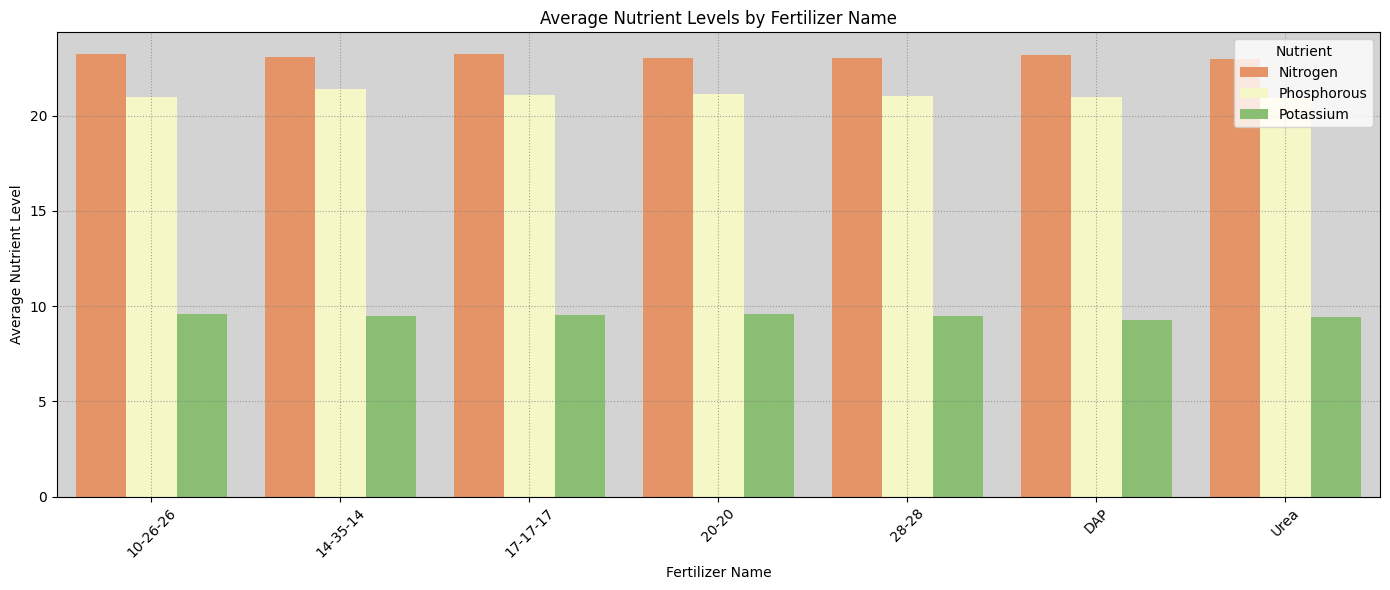

In [25]:
mean_nutrients = train_data.groupby(target_variable)[nutrient_features].mean().reset_index()
mean_nutrients_melted = mean_nutrients.melt(id_vars=target_variable, var_name='Nutrient', value_name='Mean Level')

fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=mean_nutrients_melted, x=target_variable, y='Mean Level', hue='Nutrient', palette='RdYlGn', ax=ax)
ax.set_title(f'Average Nutrient Levels by {target_variable}')
ax.set_xlabel(target_variable)
ax.set_ylabel('Average Nutrient Level')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Nutrient')
ax.set_facecolor('lightgray')
ax.grid(color='gray', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()


In [26]:
def nutrient_summary_by_target(df, target_variable, nutrient_features):
    print("=" * 60)
    print(f"Summary Statistics of Nutrients by {target_variable}")
    print("=" * 60)
    
    for feature in nutrient_features:
        summary_stats = df.groupby(target_variable)[feature].describe().round(2)
        print(f"\n--- {feature} ---\n")
        display(summary_stats)

nutrient_summary_by_target(train_data, target_variable, nutrient_features)


Summary Statistics of Nutrients by Fertilizer Name

--- Nitrogen ---



count   mean    std  min   25%   50%   75%   max
Fertilizer Name                                                     
10-26-26         113887.0  23.20  11.24  4.0  14.0  23.0  33.0  42.0
14-35-14         114436.0  23.08  11.11  4.0  14.0  23.0  33.0  42.0
17-17-17         112453.0  23.21  11.19  4.0  14.0  23.0  33.0  42.0
20-20            110889.0  23.01  11.25  4.0  13.0  23.0  33.0  42.0
28-28            111158.0  23.01  11.23  4.0  13.0  23.0  33.0  42.0
DAP               94860.0  23.16  11.27  4.0  13.0  23.0  33.0  42.0
Urea              92317.0  22.97  11.22  4.0  13.0  23.0  33.0  42.0


--- Phosphorous ---



count   mean    std  min   25%   50%   75%   max
Fertilizer Name                                                     
10-26-26         113887.0  20.98  12.39  0.0  10.0  21.0  32.0  42.0
14-35-14         114436.0  21.41  12.38  0.0  11.0  22.0  32.0  42.0
17-17-17         112453.0  21.05  12.34  0.0  11.0  21.0  32.0  42.0
20-20            110889.0  21.11  12.32  0.0  11.0  21.0  31.0  42.0
28-28            111158.0  21.02  12.40  0.0  10.0  21.0  32.0  42.0
DAP               94860.0  20.96  12.29  0.0  11.0  21.0  31.0  42.0
Urea              92317.0  20.93  12.28  0.0  10.0  21.0  32.0  42.0


--- Potassium ---



count  mean   std  min  25%   50%   75%   max
Fertilizer Name                                                  
10-26-26         113887.0  9.56  5.79  0.0  4.0  10.0  15.0  19.0
14-35-14         114436.0  9.48  5.73  0.0  5.0   9.0  14.0  19.0
17-17-17         112453.0  9.52  5.78  0.0  5.0  10.0  15.0  19.0
20-20            110889.0  9.59  5.81  0.0  5.0  10.0  15.0  19.0
28-28            111158.0  9.48  5.72  0.0  4.0   9.0  14.0  19.0
DAP               94860.0  9.25  5.77  0.0  4.0   9.0  14.0  19.0
Urea              92317.0  9.42  5.76  0.0  4.0   9.0  14.0  19.0

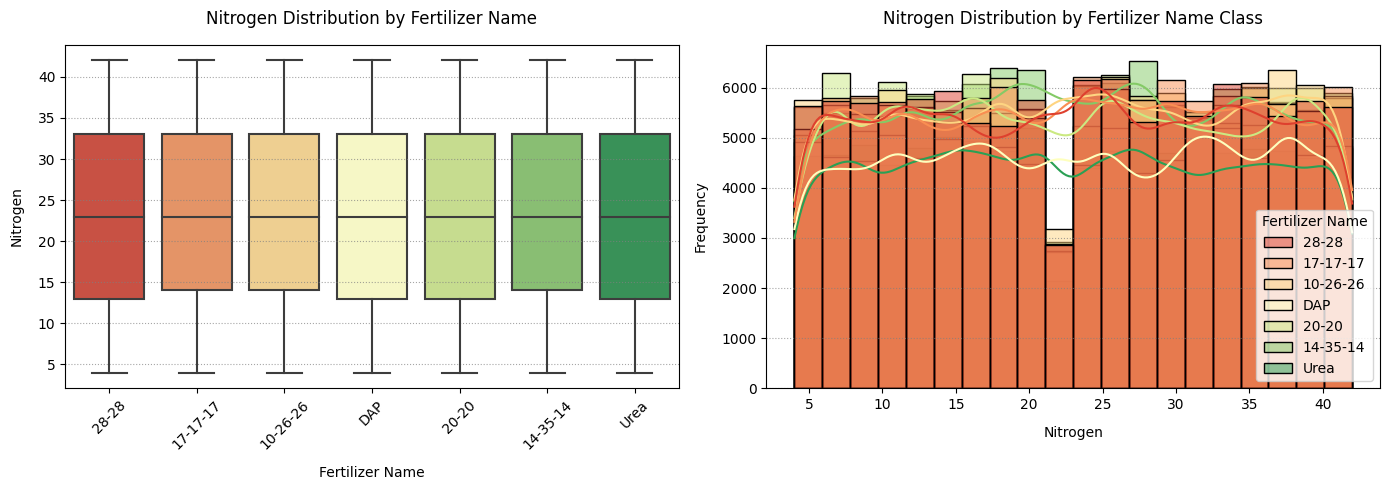

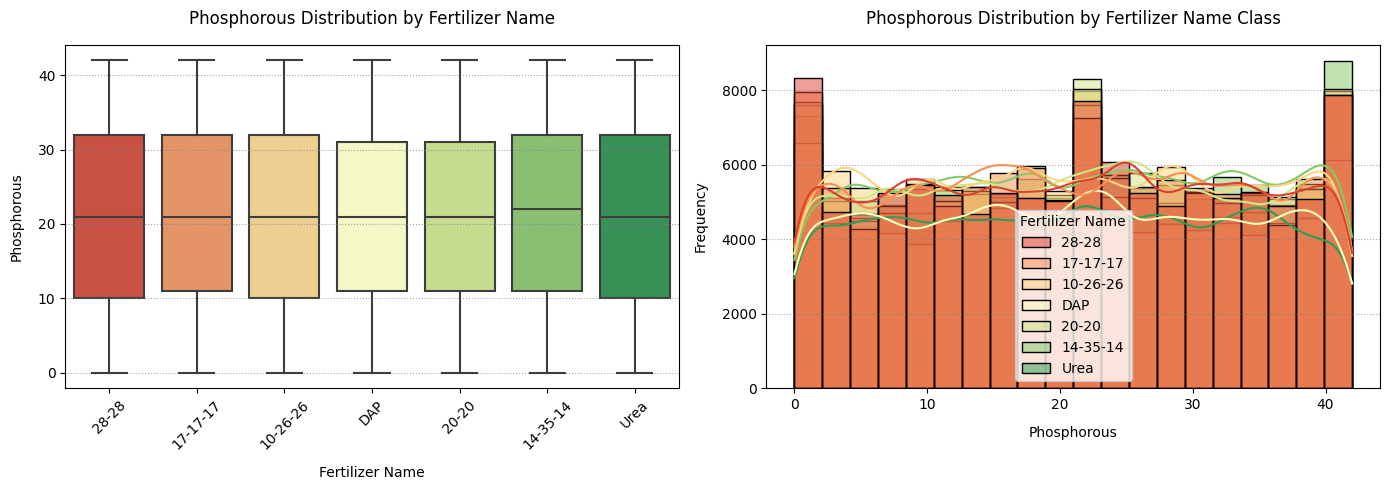

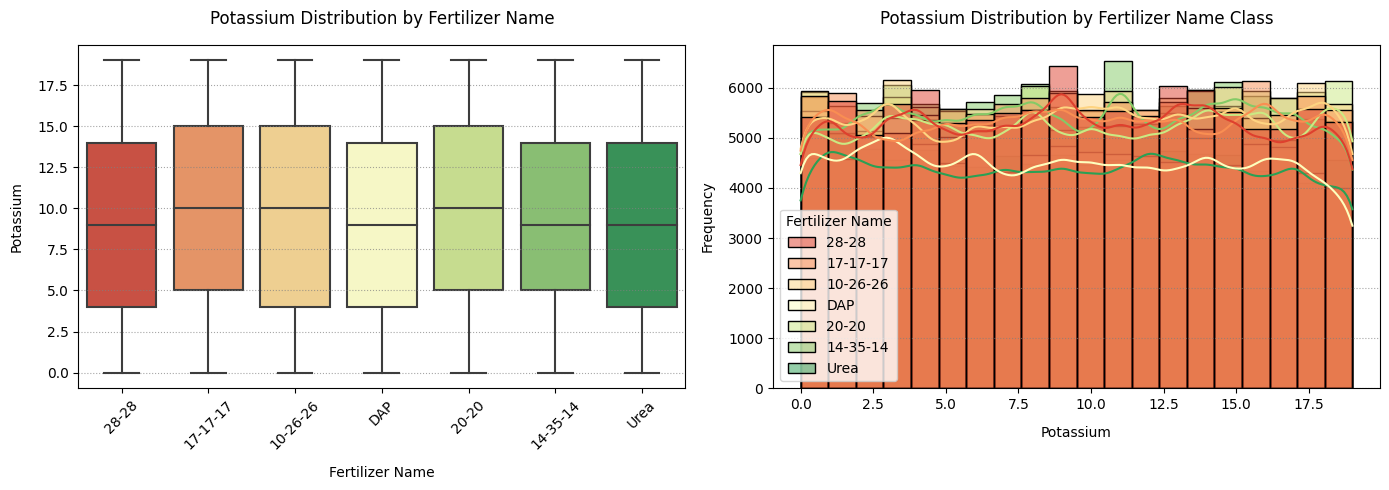

In [27]:
custom_palette = sns.color_palette("RdYlGn", len(train_data[target_variable].unique()))

for feature in nutrient_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.boxplot(x=target_variable, y=feature, data=train_data, 
                palette=custom_palette, ax=axes[0])
    axes[0].set_title(f'{feature} Distribution by {target_variable}', pad=15)
    axes[0].set_xlabel(target_variable, labelpad=10)
    axes[0].set_ylabel(feature, labelpad=10)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', color='gray', linestyle=':', alpha=0.7)
    
    sns.histplot(data=train_data, x=feature, hue=target_variable, 
                 bins=20, palette=custom_palette, ax=axes[1], kde=True)
    axes[1].set_title(f'{feature} Distribution by {target_variable} Class', pad=15)
    axes[1].set_xlabel(feature, labelpad=10)
    axes[1].set_ylabel('Frequency', labelpad=10)
    axes[1].grid(axis='y', color='gray', linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


#### Insights on Soil Nutrient Levels by Fertilizer Type

**Average Nutrient Levels Across Fertilizers**

- The barplot displays the average levels of key soil nutrients—**Nitrogen (N), Phosphorous (P), and Potassium (K)**—grouped by fertilizer type.  
- Nutrient levels are generally similar across fertilizers, with mean nitrogen values around **23 units**, phosphorous near **21 units**, and potassium approximately **9.4 to 9.6 units**.  
- This suggests that the soil nutrient availability associated with each fertilizer class is fairly balanced, indicating that fertilizer choice is influenced by factors beyond just nutrient levels.

**Distribution and Variability of Nutrients**

- The boxplots and histograms reveal overlapping distributions of nutrient levels across fertilizer types, with no fertilizer showing extreme deviations.  
- For example, nitrogen levels range consistently from 4 to 42 units across fertilizers, with similar interquartile ranges.  
- Phosphorous and potassium also show stable distributions, reflecting balanced soil fertility conditions in the dataset.

***The dataset presents balanced soil nutrient profiles across fertilizer classes, providing a solid foundation for modeling fertilizer recommendations.  
Understanding nutrient distributions in relation to fertilizer types enhances model interpretability and supports environmentally responsible fertilization practices.***

## Soil Nutrient Levels by Soil Type

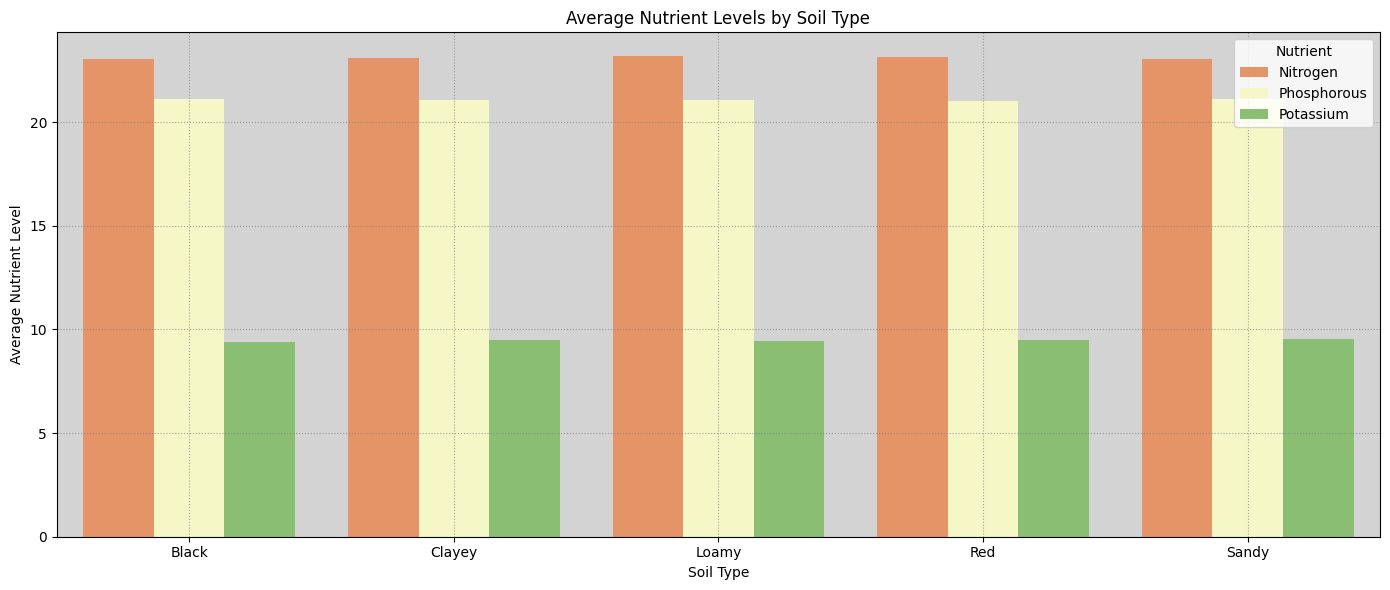

In [28]:
mean_nutrients = train_data.groupby('Soil Type')[nutrient_features].mean().reset_index()
mean_nutrients_melted = mean_nutrients.melt(id_vars='Soil Type', var_name='Nutrient', value_name='Mean Level')

fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=mean_nutrients_melted, x='Soil Type', y='Mean Level', hue='Nutrient', palette='RdYlGn', ax=ax)
ax.set_title('Average Nutrient Levels by Soil Type')
ax.set_xlabel('Soil Type')
ax.set_ylabel('Average Nutrient Level')
ax.legend(title='Nutrient')
ax.set_facecolor('lightgray')
ax.grid(color='gray', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()


In [29]:
def nutrient_summary_by_soil(df, soil_feature, nutrient_features):
    print("=" * 55)
    print(f"Summary Statistics of Nutrients by {soil_feature}")
    print("=" * 55)
    
    for nutrient in nutrient_features:
        summary_stats = df.groupby(soil_feature)[nutrient].describe().round(2)
        print(f"\n--- {nutrient} ---\n")
        display(summary_stats)

nutrient_summary_by_soil(train_data, soil_feature, nutrient_features)


Summary Statistics of Nutrients by Soil Type

--- Nitrogen ---



count   mean    std  min   25%   50%   75%   max
Soil Type                                                     
Black      150956.0  23.05  11.31  4.0  13.0  23.0  33.0  42.0
Clayey     148382.0  23.11  11.22  4.0  13.0  23.0  33.0  42.0
Loamy      145850.0  23.17  11.20  4.0  14.0  23.0  33.0  42.0
Red        148102.0  23.12  11.21  4.0  13.0  23.0  33.0  42.0
Sandy      156710.0  23.03  11.14  4.0  13.0  23.0  33.0  42.0


--- Phosphorous ---



count   mean    std  min   25%   50%   75%   max
Soil Type                                                     
Black      150956.0  21.09  12.37  0.0  10.0  21.0  32.0  42.0
Clayey     148382.0  21.08  12.37  0.0  11.0  21.0  32.0  42.0
Loamy      145850.0  21.07  12.29  0.0  10.0  21.0  32.0  42.0
Red        148102.0  21.02  12.30  0.0  11.0  21.0  32.0  42.0
Sandy      156710.0  21.10  12.40  0.0  11.0  21.0  32.0  42.0


--- Potassium ---



count  mean   std  min  25%   50%   75%   max
Soil Type                                                  
Black      150956.0  9.41  5.77  0.0  4.0   9.0  14.0  19.0
Clayey     148382.0  9.50  5.77  0.0  4.0   9.0  15.0  19.0
Loamy      145850.0  9.46  5.80  0.0  4.0   9.0  15.0  19.0
Red        148102.0  9.49  5.76  0.0  4.0   9.0  14.0  19.0
Sandy      156710.0  9.53  5.73  0.0  5.0  10.0  14.0  19.0

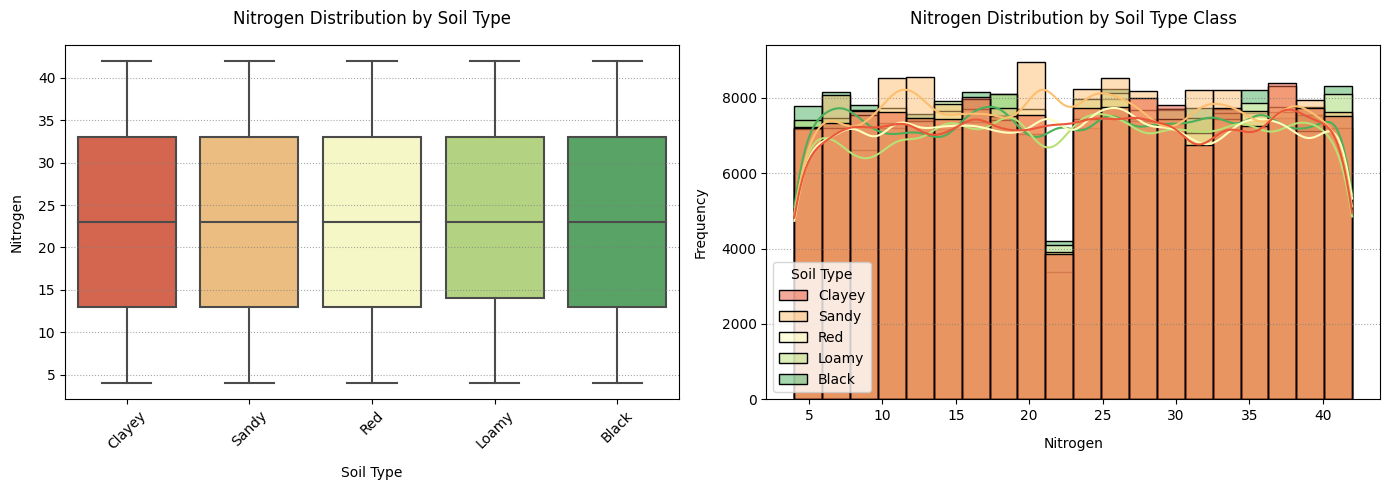

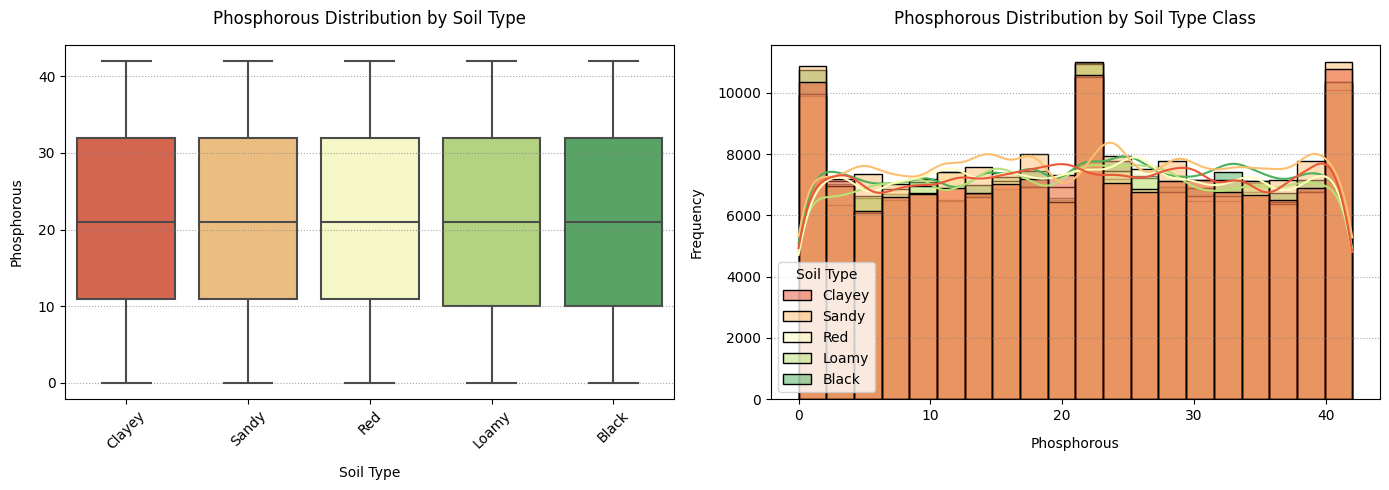

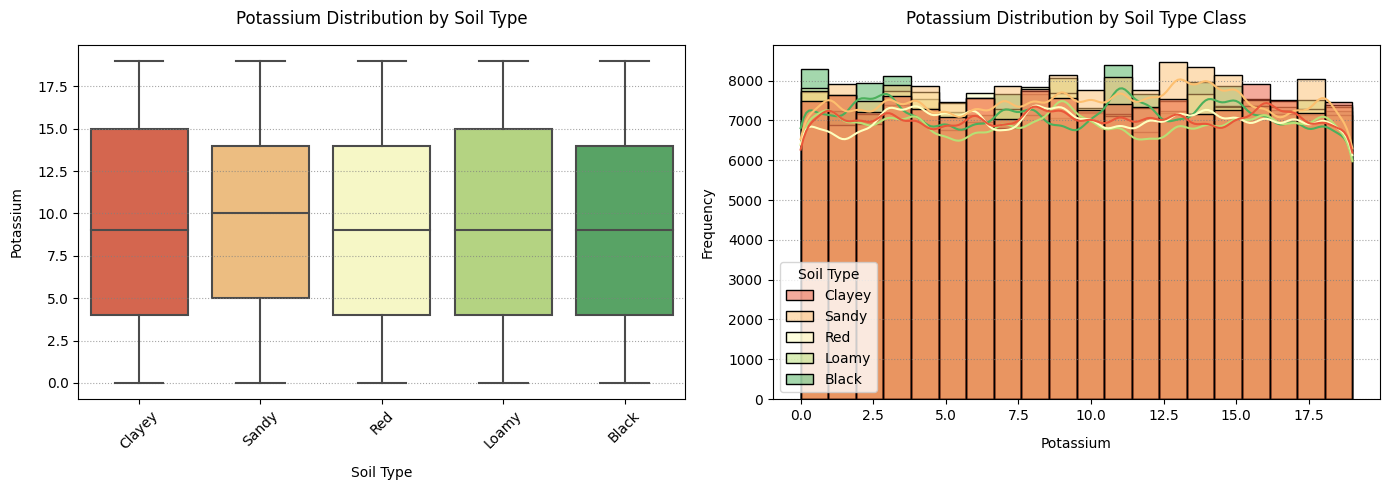

In [30]:
custom_palette_soil = sns.color_palette("RdYlGn", len(train_data[soil_feature].unique()))

for feature in nutrient_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.boxplot(x=soil_feature, y=feature, data=train_data, 
                palette=custom_palette_soil, ax=axes[0])
    axes[0].set_title(f'{feature} Distribution by {soil_feature}', pad=15)
    axes[0].set_xlabel(soil_feature, labelpad=10)
    axes[0].set_ylabel(feature, labelpad=10)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', color='gray', linestyle=':', alpha=0.7)

    sns.histplot(data=train_data, x=feature, hue=soil_feature, 
                 bins=20, palette=custom_palette_soil, ax=axes[1], kde=True)
    axes[1].set_title(f'{feature} Distribution by {soil_feature} Class', pad=15)
    axes[1].set_xlabel(feature, labelpad=10)
    axes[1].set_ylabel('Frequency', labelpad=10)
    axes[1].grid(axis='y', color='gray', linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


#### Insights on Soil Nutrient Levels by Soil Type

**Average Nutrient Levels Across Soil Types**

- The barplot shows the average levels of key soil nutrients—**Nitrogen (N), Phosphorous (P), and Potassium (K)**—across the five soil types: *Black, Clayey, Loamy, Red,* and *Sandy*.  
- Nutrient levels are remarkably consistent across soil types, with mean nitrogen values around **23 units**, phosphorous around **21 units**, and potassium near **9.4 to 9.5 units**.  
- This uniformity suggests that nutrient availability is fairly balanced across the soil types represented in the dataset.

**Distribution and Variability of Nutrients**

- The boxplots and histograms reveal that while mean nutrient levels are similar, there is some variation in nutrient distributions within soil types.  
- For example, potassium shows slightly higher variability in *Clayey* and *Loamy* soils, with interquartile ranges extending a bit further compared to *Black* and *Sandy* soils.  
- The nutrient ranges (min to max) are consistent across soil types, indicating similar nutrient availability extremes.

***The dataset provides a balanced representation of soil nutrient levels across major soil types, offering a solid foundation for modeling fertilizer recommendations.***


## Soil Nutrient Levels by Crop Type

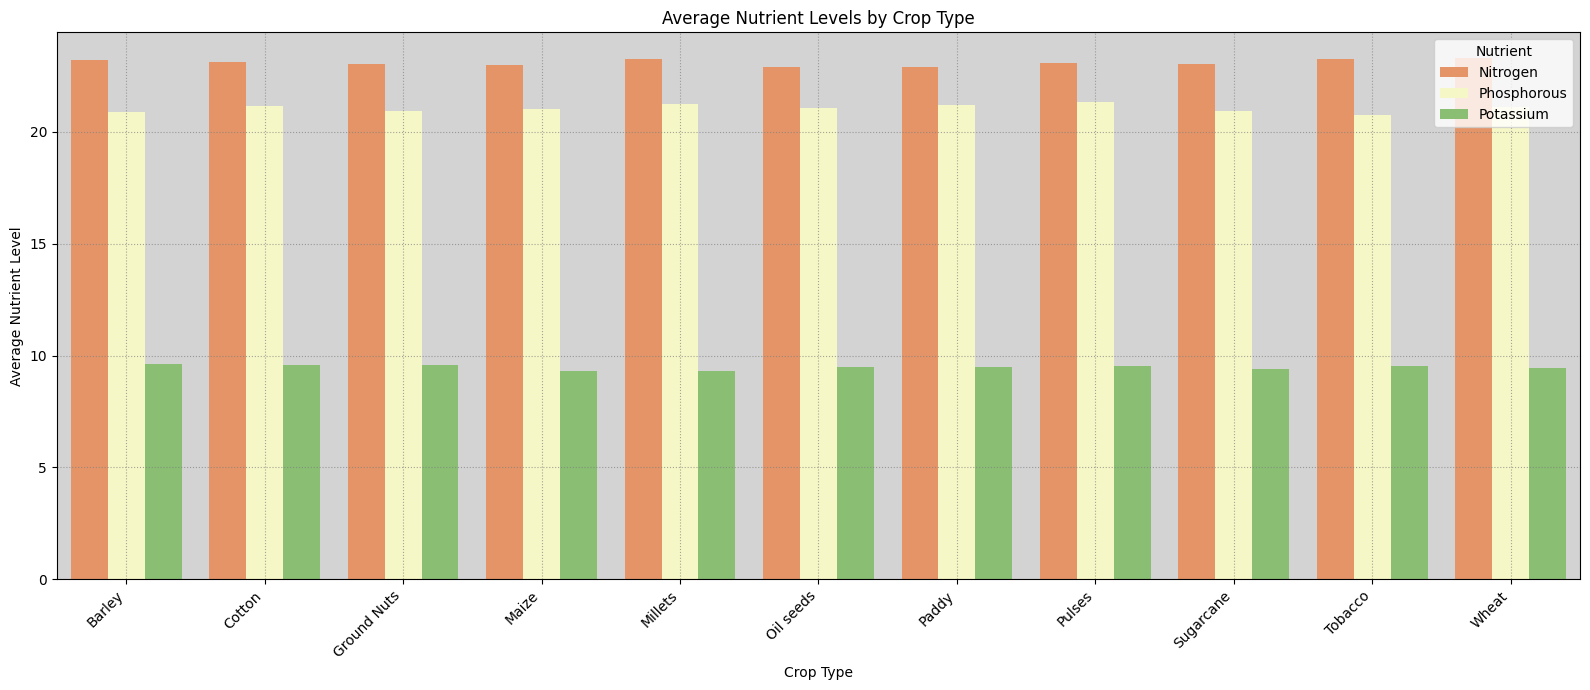

In [31]:
mean_nutrients_crop = train_data.groupby('Crop Type')[nutrient_features].mean().reset_index()
mean_nutrients_crop_melted = mean_nutrients_crop.melt(id_vars='Crop Type', var_name='Nutrient', value_name='Mean Level')

fig, ax = plt.subplots(figsize=(16, 7))
sns.barplot(data=mean_nutrients_crop_melted, x='Crop Type', y='Mean Level', hue='Nutrient', palette='RdYlGn', ax=ax)
ax.set_title('Average Nutrient Levels by Crop Type')
ax.set_xlabel('Crop Type')
ax.set_ylabel('Average Nutrient Level')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Nutrient')
ax.set_facecolor('lightgray')
ax.grid(color='gray', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()


In [32]:
def nutrient_summary_by_crop(df, crop_feature, nutrient_features):
    print("=" * 55)
    print(f"Summary Statistics of Nutrients by {crop_feature}")
    print("=" * 55)
    
    for nutrient in nutrient_features:
        summary_stats = df.groupby(crop_feature)[nutrient].describe().round(2)
        print(f"\n--- {nutrient} ---\n")
        display(summary_stats)

nutrient_summary_by_crop(train_data, crop_feature, nutrient_features)


Summary Statistics of Nutrients by Crop Type

--- Nitrogen ---



count   mean    std  min   25%   50%   75%   max
Crop Type                                                      
Barley       65045.0  23.24  11.01  4.0  14.0  23.0  32.0  42.0
Cotton       69171.0  23.11  11.26  4.0  13.0  23.0  33.0  42.0
Ground Nuts  60909.0  23.01  11.13  4.0  13.0  23.0  33.0  42.0
Maize        62569.0  23.00  11.13  4.0  14.0  23.0  32.0  42.0
Millets      65291.0  23.25  11.26  4.0  13.0  23.0  33.0  42.0
Oil seeds    64184.0  22.91  11.24  4.0  13.0  23.0  33.0  42.0
Paddy        85754.0  22.92  11.33  4.0  13.0  23.0  33.0  42.0
Pulses       78180.0  23.06  11.22  4.0  13.0  23.0  33.0  42.0
Sugarcane    64269.0  23.02  11.16  4.0  14.0  23.0  33.0  42.0
Tobacco      68000.0  23.26  11.38  4.0  13.0  24.0  33.0  42.0
Wheat        66628.0  23.29  11.17  4.0  14.0  24.0  33.0  42.0


--- Phosphorous ---



count   mean    std  min   25%   50%   75%   max
Crop Type                                                      
Barley       65045.0  20.89  12.45  0.0  10.0  21.0  32.0  42.0
Cotton       69171.0  21.14  12.23  0.0  11.0  22.0  32.0  42.0
Ground Nuts  60909.0  20.93  12.28  0.0  11.0  21.0  31.0  42.0
Maize        62569.0  21.04  12.30  0.0  11.0  21.0  32.0  42.0
Millets      65291.0  21.27  12.25  0.0  11.0  22.0  32.0  42.0
Oil seeds    64184.0  21.06  12.37  0.0  11.0  21.0  32.0  42.0
Paddy        85754.0  21.20  12.37  0.0  11.0  21.0  32.0  42.0
Pulses       78180.0  21.35  12.45  0.0  11.0  22.0  32.0  42.0
Sugarcane    64269.0  20.95  12.43  0.0  10.0  21.0  32.0  42.0
Tobacco      68000.0  20.77  12.34  0.0  10.0  21.0  31.0  42.0
Wheat        66628.0  21.10  12.32  0.0  10.0  21.0  32.0  42.0


--- Potassium ---



count  mean   std  min  25%   50%   75%   max
Crop Type                                                   
Barley       65045.0  9.60  5.73  0.0  5.0  10.0  15.0  19.0
Cotton       69171.0  9.56  5.75  0.0  5.0  10.0  15.0  19.0
Ground Nuts  60909.0  9.57  5.73  0.0  5.0   9.0  15.0  19.0
Maize        62569.0  9.31  5.77  0.0  4.0   9.0  14.0  19.0
Millets      65291.0  9.30  5.75  0.0  4.0   9.0  14.0  19.0
Oil seeds    64184.0  9.48  5.82  0.0  4.0   9.0  15.0  19.0
Paddy        85754.0  9.50  5.78  0.0  4.0   9.0  15.0  19.0
Pulses       78180.0  9.55  5.76  0.0  5.0  10.0  15.0  19.0
Sugarcane    64269.0  9.40  5.74  0.0  4.0   9.0  14.0  19.0
Tobacco      68000.0  9.54  5.79  0.0  4.0  10.0  14.0  19.0
Wheat        66628.0  9.43  5.78  0.0  4.0   9.0  14.0  19.0

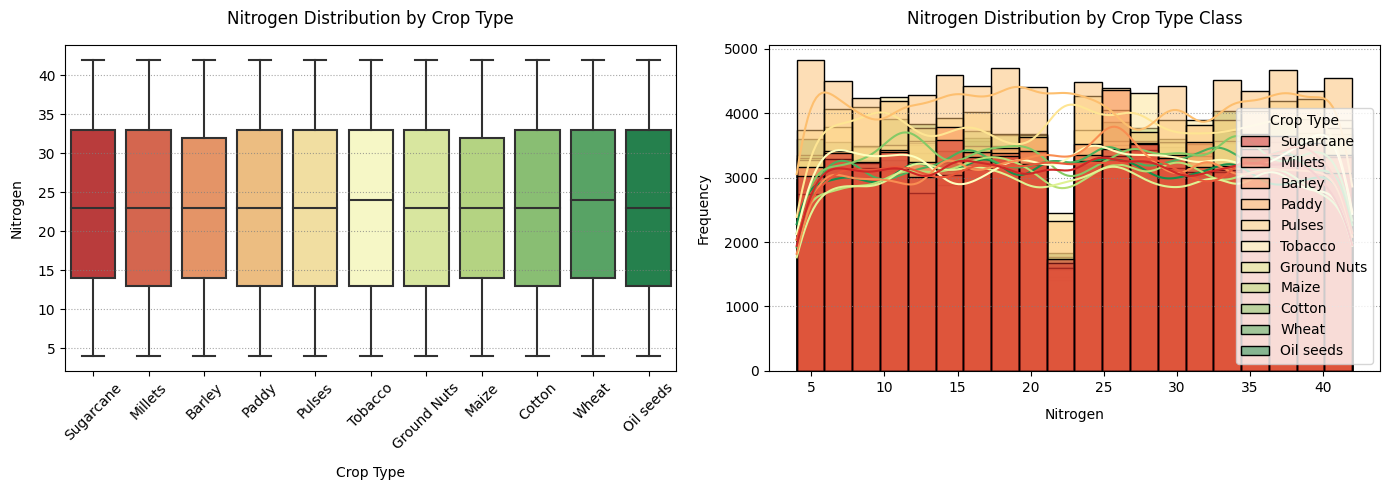

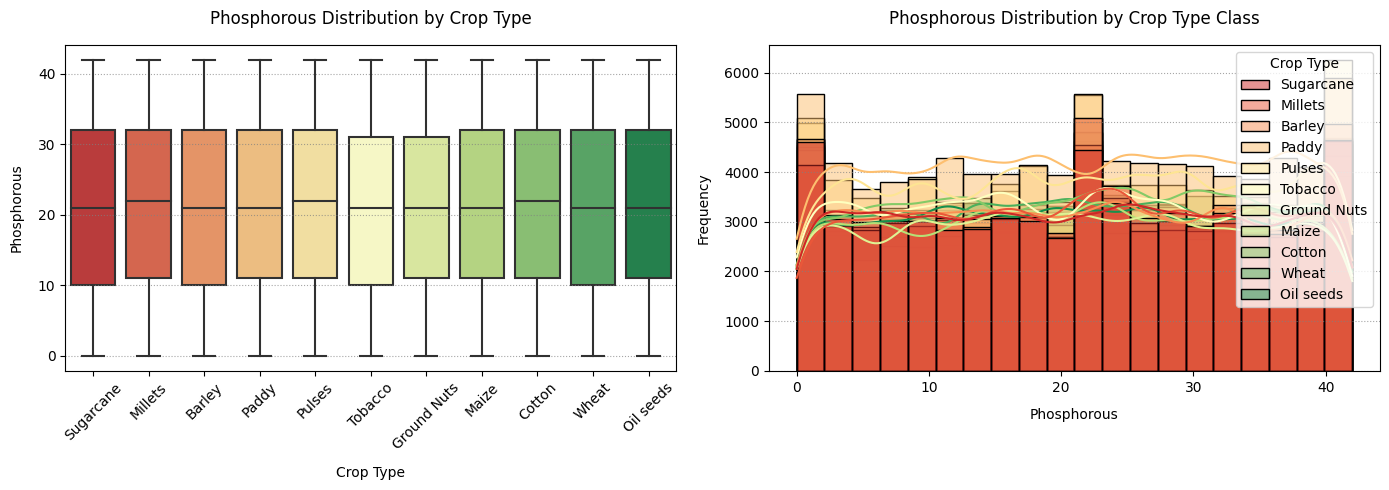

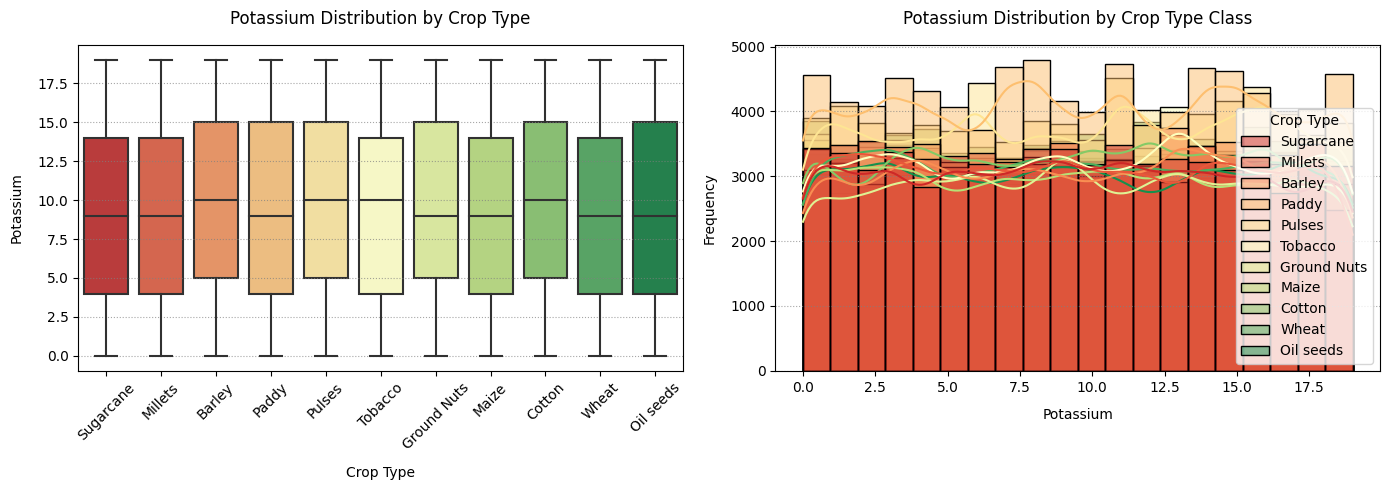

In [33]:
custom_palette_crop = sns.color_palette("RdYlGn", len(train_data[crop_feature].unique()))

for feature in nutrient_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.boxplot(x=crop_feature, y=feature, data=train_data, 
                palette=custom_palette_crop, ax=axes[0])
    axes[0].set_title(f'{feature} Distribution by {crop_feature}', pad=15)
    axes[0].set_xlabel(crop_feature, labelpad=10)
    axes[0].set_ylabel(feature, labelpad=10)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', color='gray', linestyle=':', alpha=0.7)

    sns.histplot(data=train_data, x=feature, hue=crop_feature, 
                 bins=20, palette=custom_palette_crop, ax=axes[1], kde=True)
    axes[1].set_title(f'{feature} Distribution by {crop_feature} Class', pad=15)
    axes[1].set_xlabel(feature, labelpad=10)
    axes[1].set_ylabel('Frequency', labelpad=10)
    axes[1].grid(axis='y', color='gray', linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

#### Insights on Soil Nutrient Levels by Crop Type

**Average Nutrient Levels Across Crop Types**

- The barplot illustrates the average levels of key soil nutrients—**Nitrogen (N), Phosphorous (P), and Potassium (K)**—across the 11 crop types in the dataset.  
- Nutrient levels are generally consistent across crops, with mean nitrogen values around **23 units**, phosphorous near **21 units**, and potassium roughly **9.3 to 9.6 units**.  
- This suggests that the soil nutrient availability is relatively uniform across the different cropping systems represented.

**Distribution and Variability of Nutrients**

- Boxplots and histograms reveal some variation in nutrient distributions within crop types, reflecting differences in nutrient uptake, fertilization practices, and soil conditions associated with each crop.  
- For example, nitrogen levels show slight variation with crops like **Barley**, **Millets**, and **Tobacco** having marginally higher means (\~23.2 to 23.3), while **Paddy** and **Oil seeds** are slightly lower (\~22.9).  
- Phosphorous and potassium levels remain fairly stable across crops, indicating balanced nutrient management.

***The dataset presents a comprehensive profile of soil nutrient availability across diverse crop types, providing a strong basis for fertilizer recommendation modeling.***

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

# <span style="color:transparent;">Data Preprocessing</span>

<div style="
    border-radius: 15px; 
    border: 2px solid #8B4513; 
    padding: 10px; 
    background: linear-gradient(135deg, #d73027, #fdae61 40%, #a6d96a 80%, #1a9850); 
    text-align: center; 
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);
">
    <h1 style="
        color: #FFFFFF; 
        text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); 
        font-weight: bold; 
        margin-bottom: 5px; 
        font-size: 28px; 
        font-family: 'Roboto', sans-serif;
        letter-spacing: 1px;
    ">
        Data Preprocessing
    </h1>
</div>


## Combine Datasets

In [34]:
# Drop 'id' column from train_data to align columns
train_data_aligned = train_data.drop(columns=['id'])

# Concatenate train_data_aligned and original_data
combined_data = pd.concat([train_data_aligned, original_data], ignore_index=True)

print(f"Combined dataset shape: {combined_data.shape}")


Combined dataset shape: (850000, 9)


- To leverage all available information, the synthetic **training data** and the **original dataset** were combined after aligning their columns by dropping the `id` column from the training data.  
- This resulted in a comprehensive dataset of **850,000 samples and 9 features**, enhancing data volume.

## Label Encoding for Target and Categorical Features

In [35]:
# target_variable = 'Fertilizer Name'
categorical_features = ['Soil Type', 'Crop Type']

# Encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    combined_data[col + '_Encoded'] = le.fit_transform(combined_data[col])
    label_encoders[col] = le
    
    test_data[col + '_Encoded'] = test_data[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

    print(f"\nEncoding mapping for {col}:")
    for cat, code in zip(le.classes_, le.transform(le.classes_)):
        print(f"  {cat} --> {code}")

# Encode target variable
target_le = LabelEncoder()
combined_data[target_variable + '_Encoded'] = target_le.fit_transform(combined_data[target_variable])

print("\nTarget encoding mapping:")
for cat, code in zip(target_le.classes_, target_le.transform(target_le.classes_)):
    print(f"  {cat} --> {code}")

# Drop original categorical columns after encoding
combined_data.drop(columns=categorical_features, inplace=True)
test_data.drop(columns=categorical_features, inplace=True)

# drop original target column 
combined_data.drop(columns=[target_variable], inplace=True)



Encoding mapping for Soil Type:
  Black --> 0
  Clayey --> 1
  Loamy --> 2
  Red --> 3
  Sandy --> 4

Encoding mapping for Crop Type:
  Barley --> 0
  Cotton --> 1
  Ground Nuts --> 2
  Maize --> 3
  Millets --> 4
  Oil seeds --> 5
  Paddy --> 6
  Pulses --> 7
  Sugarcane --> 8
  Tobacco --> 9
  Wheat --> 10

Target encoding mapping:
  10-26-26 --> 0
  14-35-14 --> 1
  17-17-17 --> 2
  20-20 --> 3
  28-28 --> 4
  DAP --> 5
  Urea --> 6


- Categorical variables, specifically **Soil Type** and **Crop Type**, were label encoded to convert textual categories into numerical codes compatible with machine learning algorithms.  
- The encoding mappings were consistent and comprehensive, covering all categories in the training and test datasets.  
- The target variable, **Fertilizer Name**, was also label encoded to facilitate model training on a numerical target.  
- Original categorical columns were dropped post-encoding to avoid redundancy.


### Removing Whitespaces in Feature Names

In [36]:
# Remove whitespaces in feature names for combined_data and test_data
combined_data.columns = combined_data.columns.str.replace(' ', '_', regex=True)
test_data.columns = test_data.columns.str.replace(' ', '_', regex=True)

print("Updated Feature Names in combined_data:")
print(combined_data.columns)

print("\nUpdated Feature Names in test_data:")
print(test_data.columns)

Updated Feature Names in combined_data:
Index(['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium',
       'Phosphorous', 'Soil_Type_Encoded', 'Crop_Type_Encoded',
       'Fertilizer_Name_Encoded'],
      dtype='object')

Updated Feature Names in test_data:
Index(['id', 'Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium',
       'Phosphorous', 'Soil_Type_Encoded', 'Crop_Type_Encoded'],
      dtype='object')


- Whitespaces in feature names were removed and replaced with underscores to ensure consistency and avoid errors during data processing and modeling.  
- This step improves code readability and compatibility across different libraries and environments.

## Verifying Data Types Across Datasets

In [37]:
combined_data_types = pd.DataFrame({
    'Column Name': combined_data.columns,
    'Combined Data Type': combined_data.dtypes.astype(str)  
})

test_data_types = pd.DataFrame({
    'Column Name': test_data.columns,
    'Test Data Type': test_data.dtypes.astype(str)
})

data_types_comparison = pd.merge(
    combined_data_types,
    test_data_types,
    on='Column Name',
    how='outer'  
)

print("Data Types Comparison of Combined and Test Datasets:\n")
display(data_types_comparison)


Data Types Comparison of Combined and Test Datasets:



Column Name Combined Data Type Test Data Type
0        Crop_Type_Encoded              int64          int64
1  Fertilizer_Name_Encoded              int64            NaN
2                 Humidity              int64          int64
3                 Moisture              int64          int64
4                 Nitrogen              int64          int64
5              Phosphorous              int64          int64
6                Potassium              int64          int64
7        Soil_Type_Encoded              int64          int64
8              Temparature              int64          int64
9                       id                NaN          int64

- Data types of features were verified across the combined training and test datasets to ensure consistency, particularly for encoded categorical features and numerical variables.  
- The target variable is present only in the combined training dataset, while the test dataset lacks it, as expected for prediction tasks.

## Correlation Analysis of Preprocessed Data

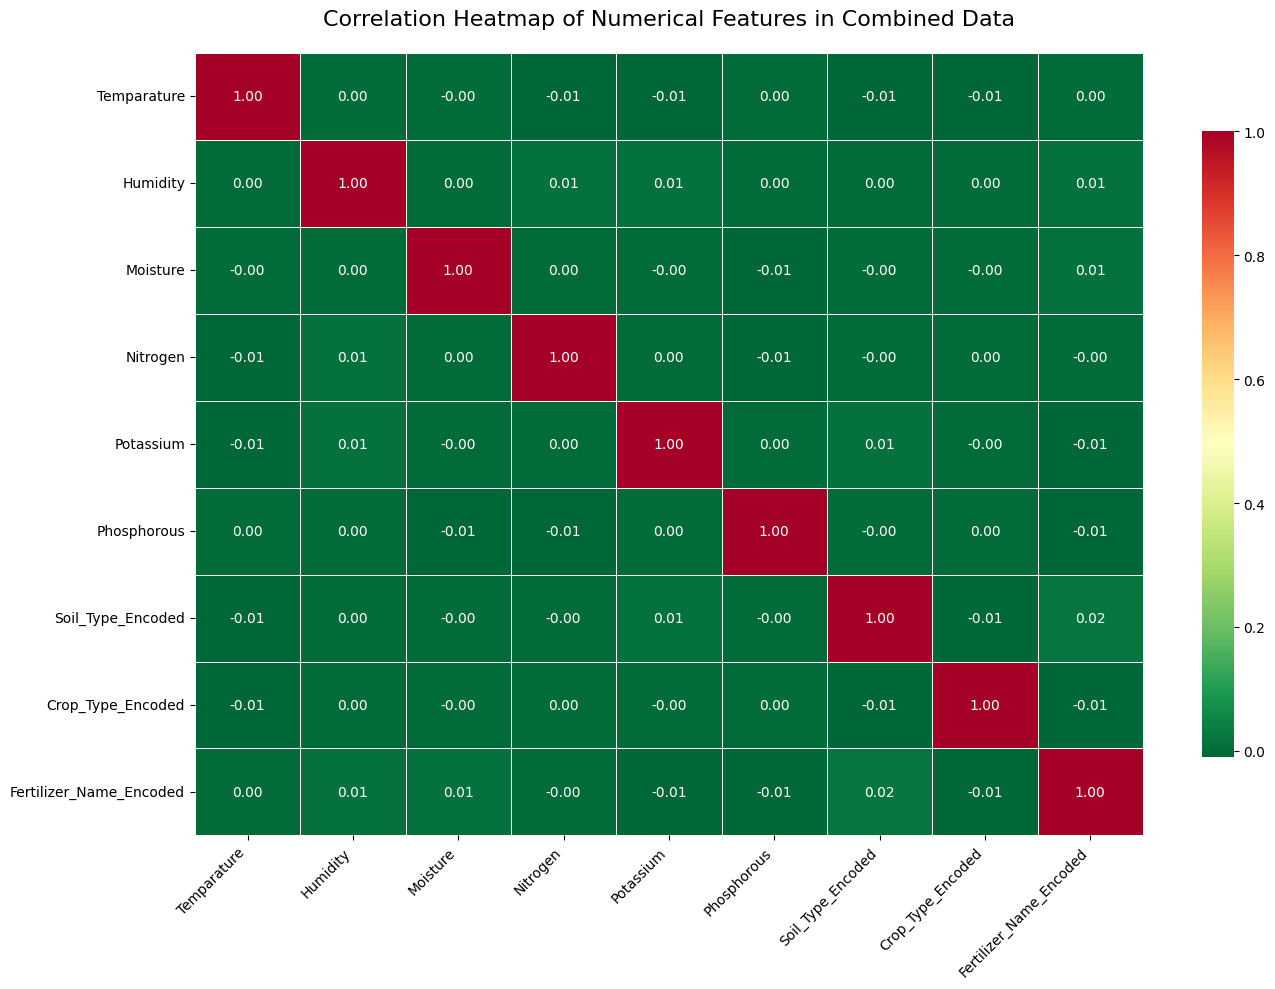

In [38]:
numerical_features = combined_data.select_dtypes(include=['int64']).columns.tolist()

corr_matrix = combined_data[numerical_features].corr().round(2)

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='RdYlGn_r',
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)

plt.title('Correlation Heatmap of Numerical Features in Combined Data', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


- A correlation heatmap of numerical features, including encoded categorical variables and the target, revealed very weak correlations among features and between features and the target.  
- This indicates that features provide mostly independent information, suggesting the need for models capable of capturing complex, possibly non-linear relationships.

## Separating Features and Target

In [39]:
# Select features and target
feature_columns = [
    'Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Phosphorous', 'Potassium',
    'Soil_Type_Encoded', 'Crop_Type_Encoded'
]
target_column = 'Fertilizer_Name_Encoded'

# Set Training and Test Dataset (no scaling)
X = combined_data[feature_columns]
y = combined_data[target_column]
test_X = test_data[feature_columns]

- The input features selected for model training include environmental variables (`Temparature`, `Humidity`, `Moisture`), soil nutrients (`Nitrogen`, `Phosphorous`, `Potassium`), and encoded categorical variables (`Soil_Type_Encoded`, `Crop_Type_Encoded`).  
- The target variable is the encoded fertilizer class (`Fertilizer_Name_Encoded`). 

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

# <span style="color:transparent;">Define MAP@3 Metric</span>

<div style="
    border-radius: 15px; 
    border: 2px solid #8B4513; 
    padding: 10px; 
    background: linear-gradient(135deg, #d73027, #fdae61 40%, #a6d96a 80%, #1a9850); 
    text-align: center; 
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);
">
    <h1 style="
        color: #FFFFFF; 
        text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); 
        font-weight: bold; 
        margin-bottom: 5px; 
        font-size: 28px; 
        font-family: 'Roboto', sans-serif;
        letter-spacing: 1px;
    ">
        Define MAP@3 Metric
    </h1>
</div>


In [40]:
# MAP@3 Metric
def mapk(actual, predicted, k=3):
    def apk(a, p, k):
        if len(p) > k:
            p = p[:k]
        score = 0.0
        num_hits = 0.0
        for i, pred in enumerate(p):
            if pred == a and pred not in p[:i]:
                num_hits += 1.0
                score += num_hits / (i + 1.0)
        return score
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

### Evaluation Metric: Mean Average Precision at 3 (MAP\@3)

In this competition, model performance is evaluated using the **Mean Average Precision at 3** (**MAP@3**) metric. This metric rewards models that correctly predict the fertilizer type and rank it as highly as possible among the top three predictions for each test sample.

#### 🔍 What is MAP\@3?

**MAP@3** measures how well the top three predicted fertilizer names match the true fertilizer for each test instance. The score is higher if the correct fertilizer appears earlier in the list of predictions.

#### 🧮 Mathematical Definition

The general formula for Mean Average Precision at K (MAP\@K) is:

$$
\text{MAP@K} = \frac{1}{U} \sum_{u=1}^{U} \sum_{k=1}^{\min(n, K)} P(k) \times \text{rel}(k)
$$

Where:

* $U$: total number of test samples
* $n$: number of predictions per sample (up to 3)
* $P(k)$: precision at rank $k$, defined as the number of correct items in the top $k$ predictions divided by $k$
* $\text{rel}(k)$: an indicator function, 1 if the prediction at rank $k$ is correct, 0 otherwise

For this competition, **K = 3**.


#### ⚙️ How MAP\@3 Works

* For each test sample, model can predict **up to 3 fertilizer names**, ranked by confidence.
* If the correct fertilizer is **1st prediction**, the score is **1.0**.
* If it's the **2nd**, the score is **0.5**.
* If it's the **3rd**, the score is **0.333...**.
* If the correct fertilizer isn’t in the top 3, the score is **0.0**.
* The **MAP\@3 score** is the average of these individual scores over all test samples.

#### 🧪 Example

Suppose the true fertilizer is `"Urea"`:

| Predictions          | AP\@3 Score |
| -------------------- | ----------- |
| `Urea 14-35-14 DAP`  | 1.0         |
| `14-35-14 Urea DAP`  | 0.5         |
| `14-35-14 DAP Urea`  | 0.333       |
| `14-35-14 DAP 20-20` | 0.0         |

#### 🌱 Why MAP\@3?

MAP\@3 is especially useful in real-world recommendation systems like this one, where multiple options can be suggested, but ranking the correct one near the top is critical. In agriculture, suggesting the right fertilizer within the top three helps support better decision-making and crop outcomes, even if the top prediction isn't always perfect.

**References:**

* [Kaggle S5E6 Evaluation Page](https://www.kaggle.com/competitions/playground-series-s5e6/overview/evaluation)


<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

# <span style="color:transparent;">Model Training</span>

<div style="
    border-radius: 15px; 
    border: 2px solid #8B4513; 
    padding: 10px; 
    background: linear-gradient(135deg, #d73027, #fdae61 40%, #a6d96a 80%, #1a9850); 
    text-align: center; 
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);
">
    <h1 style="
        color: #FFFFFF; 
        text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); 
        font-weight: bold; 
        margin-bottom: 5px; 
        font-size: 28px; 
        font-family: 'Roboto', sans-serif;
        letter-spacing: 1px;
    ">
        Model Training
    </h1>
</div>


## Best XGBoost Parameters from Optuna

In [41]:
# Best XGBoost parameters from previous Optuna run
best_params = {
    'max_depth': 7,
    'learning_rate': 0.05635134330984224,
    'subsample': 0.5605235929333594,
    'colsample_bytree': 0.5594578346445631,
    'min_child_weight': 6,
    'gamma': 0.35819323772520817,
    'reg_alpha': 0.9747714669120731,
    'reg_lambda': 0.7061465594372847,
    'objective': 'multi:softprob',
    'num_class': 7,
    'eval_metric': 'mlogloss',
    'tree_method': 'gpu_hist',
    'verbosity': 0,
    'n_estimators': 1000
}

- The model uses XGBoost, a powerful gradient boosting algorithm well-suited for tabular data and multi-class classification.  
- Hyperparameters were optimized using Optuna, resulting in parameters such as a max depth of 7, learning rate ~0.056, subsample and colsample_bytree around 0.56, and regularization terms to prevent overfitting.  
- These settings balance model complexity and generalization, leveraging GPU acceleration for efficient training.

## Cross-Validation Training with OOF & Test Predictions

In [42]:
# Training and predictions
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((X.shape[0], len(np.unique(y))))
test_preds = np.zeros((test_X.shape[0], len(np.unique(y))))
oof_true = []
oof_top3_preds = []

fold_loglosses = []
fold_map3s = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = xgb.XGBClassifier(**best_params, use_label_encoder=False)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=10,
        verbose=False
    )

    oof_preds[valid_idx] = model.predict_proba(X_valid)
    fold_logloss = log_loss(y_valid, oof_preds[valid_idx])
    fold_loglosses.append(fold_logloss)

    top3_preds = np.argsort(oof_preds[valid_idx], axis=1)[:, -3:][:, ::-1]
    fold_map3 = mapk(y_valid.tolist(), [list(p) for p in top3_preds], k=3)
    fold_map3s.append(fold_map3)

    print(f"  Fold {fold+1} Log Loss: {fold_logloss:.5f}")
    print(f"  Fold {fold+1} MAP@3: {fold_map3:.5f}")

    oof_true.extend(y_valid)
    oof_top3_preds.extend(top3_preds)
    test_preds += model.predict_proba(test_X) / skf.n_splits

# Overall MAP@3
map3_score = mapk(oof_true, [list(p) for p in oof_top3_preds], k=3)
print(f"\nOverall OOF MAP@3 Score: {map3_score:.5f}")

Fold 1
  Fold 1 Log Loss: 1.90473
  Fold 1 MAP@3: 0.35025
Fold 2
  Fold 2 Log Loss: 1.90547
  Fold 2 MAP@3: 0.34952
Fold 3
  Fold 3 Log Loss: 1.90488
  Fold 3 MAP@3: 0.35003
Fold 4
  Fold 4 Log Loss: 1.90514
  Fold 4 MAP@3: 0.34875
Fold 5
  Fold 5 Log Loss: 1.90603
  Fold 5 MAP@3: 0.34854

Overall OOF MAP@3 Score: 0.34942


- A stratified 5-fold cross-validation approach was employed to ensure robust model evaluation and prevent overfitting.  
- For each fold, the model was trained on 80% of the data and validated on 20%, with early stopping to avoid unnecessary training epochs.  
- Out-of-fold (OOF) predictions were collected to estimate generalization performance, and test set predictions were averaged across folds for final submission.

## Fold Performance

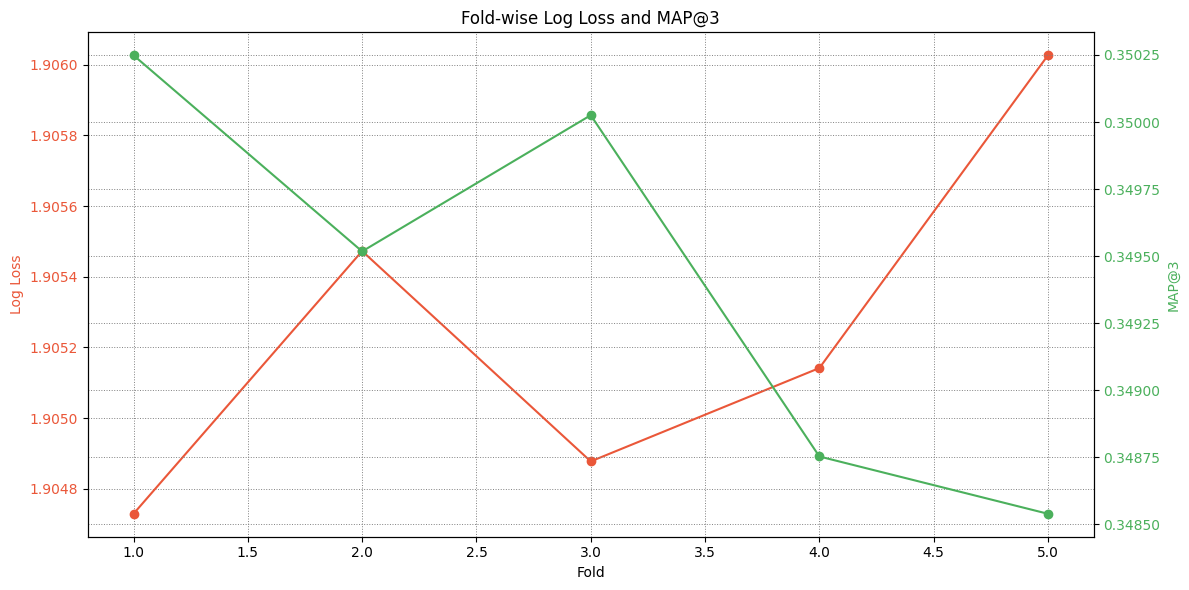

In [43]:
# Fold-wise Log Loss and MAP@3
colors = sns.color_palette('RdYlGn', 5)
folds = list(range(1, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title('Fold-wise Log Loss and MAP@3')
ax1.plot(folds, fold_loglosses, marker='o', color=colors[0], label='Log Loss')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Log Loss', color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])
ax1.grid(color='gray', linestyle=':', linewidth=0.7)

ax2 = ax1.twinx()
ax2.plot(folds, fold_map3s, marker='o', color=colors[4], label='MAP@3')
ax2.set_ylabel('MAP@3', color=colors[4])
ax2.tick_params(axis='y', labelcolor=colors[4])
ax2.grid(color='gray', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()

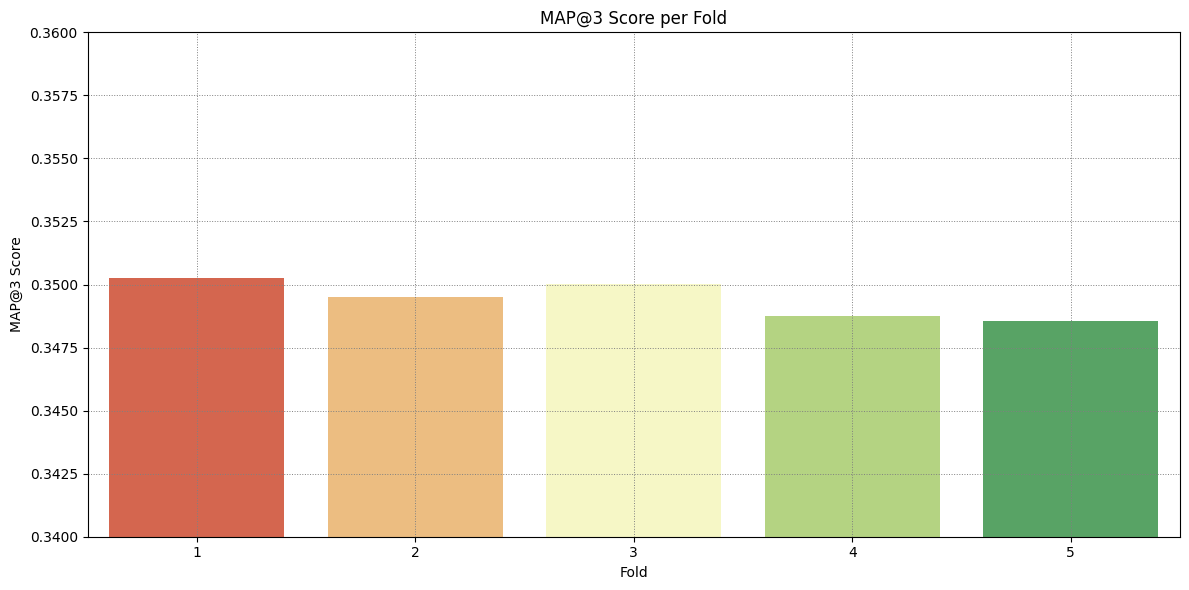

In [44]:
# MAP@3 per Fold Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=folds, y=fold_map3s, palette='RdYlGn')
plt.title('MAP@3 Score per Fold')
plt.xlabel('Fold')
plt.ylabel('MAP@3 Score')
plt.ylim(0.34, 0.36)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()

- Fold-wise log loss values were consistently around **1.90**, indicating stable model convergence.  
- MAP@3 scores per fold ranged narrowly between **0.3485 and 0.3503**, with an overall OOF MAP@3 of approximately **0.3494**.  
- These results demonstrate consistent model performance and reliable top-3 fertilizer prediction accuracy.

## Feature Importance

Feature Importances:
             Feature  Importance
4        Phosphorous    0.135567
3           Nitrogen    0.132121
2           Moisture    0.130652
7  Crop_Type_Encoded    0.126706
5          Potassium    0.124625
1           Humidity    0.119697
0        Temparature    0.116557
6  Soil_Type_Encoded    0.114075


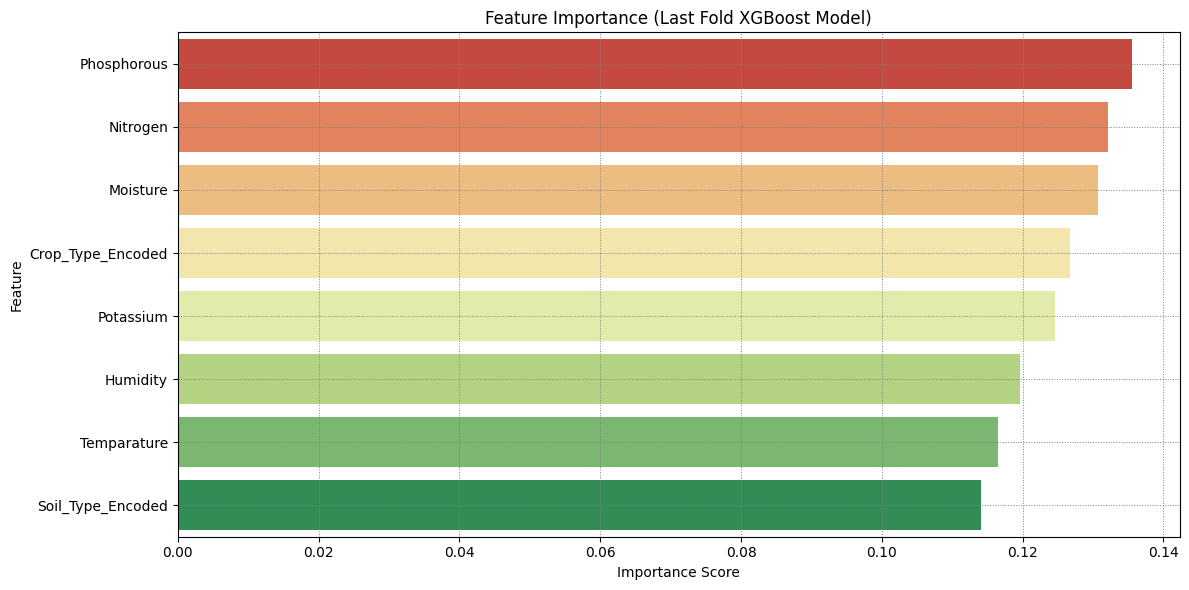

In [45]:
# Extract feature importances from the trained model (last fold)
feature_importance = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df, 
    palette='RdYlGn'
)
plt.title('Feature Importance (Last Fold XGBoost Model)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()


#### Feature Importance Insights from XGBoost Model

**Overview of Feature Importance**

- The feature importance analysis from the final fold of the trained XGBoost model reveals the relative contribution of each feature in predicting the fertilizer class.  
- Understanding feature importance helps interpret the model’s decision-making process and identifies the most influential factors affecting fertilizer recommendations.

**Key Findings**

- **Phosphorous** emerges as the most important feature, contributing approximately 13.56% to the model’s predictive power. This aligns with its critical role in plant development and nutrient uptake.  
- **Nitrogen** and **Moisture** follow closely, with importance scores around 13.21% and 13.07%, respectively, highlighting their vital influence on fertilizer needs and soil-crop interactions.  
- The encoded **Crop Type** feature ranks fourth, indicating that crop-specific nutrient requirements significantly affect fertilizer choice.  
- **Potassium**, **Humidity**, and **Temperature** also have meaningful contributions, reflecting the combined effect of soil nutrients and environmental conditions.  
- The encoded **Soil Type** feature, while slightly less influential, still plays a notable role, capturing soil-specific characteristics that impact fertilizer effectiveness.

**Agronomic and Modeling Implications**

- The prominence of soil nutrients (Phosphorous, Nitrogen, Potassium) as top predictors confirms their fundamental importance in fertilizer recommendation systems, consistent with agronomic knowledge.  
- Environmental factors like moisture, humidity, and temperature also influence fertilizer effectiveness by affecting nutrient availability and crop stress levels.  
- Crop type’s high importance underscores the need for crop-specific fertilization strategies to optimize yield and resource use.  
- Soil type, though less dominant, remains essential for capturing soil heterogeneity and guiding localized fertilizer application.

<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

# <span style="color:transparent;">Prepare Final Submission File</span>

<div style="
    border-radius: 15px; 
    border: 2px solid #8B4513; 
    padding: 10px; 
    background: linear-gradient(135deg, #d73027, #fdae61 40%, #a6d96a 80%, #1a9850); 
    text-align: center; 
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);
">
    <h1 style="
        color: #FFFFFF; 
        text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); 
        font-weight: bold; 
        margin-bottom: 5px; 
        font-size: 28px; 
        font-family: 'Roboto', sans-serif;
        letter-spacing: 1px;
    ">
        Prepare Final Submission File
    </h1>
</div>


In [46]:
# Fertilizer decoder
fertilizer_decoder = dict(zip(target_le.transform(target_le.classes_), target_le.classes_))
test_top3_preds = np.argsort(test_preds, axis=1)[:, -3:][:, ::-1]

submission_labels = []
for row in test_top3_preds:
    labels = [fertilizer_decoder[i] for i in row]
    submission_labels.append(' '.join(labels))

submission_df = pd.DataFrame({
    'id': test_data['id'],
    'Fertilizer Name': submission_labels
})
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file saved!")


Submission file saved!


## Confusion Matrix and Class Distribution 

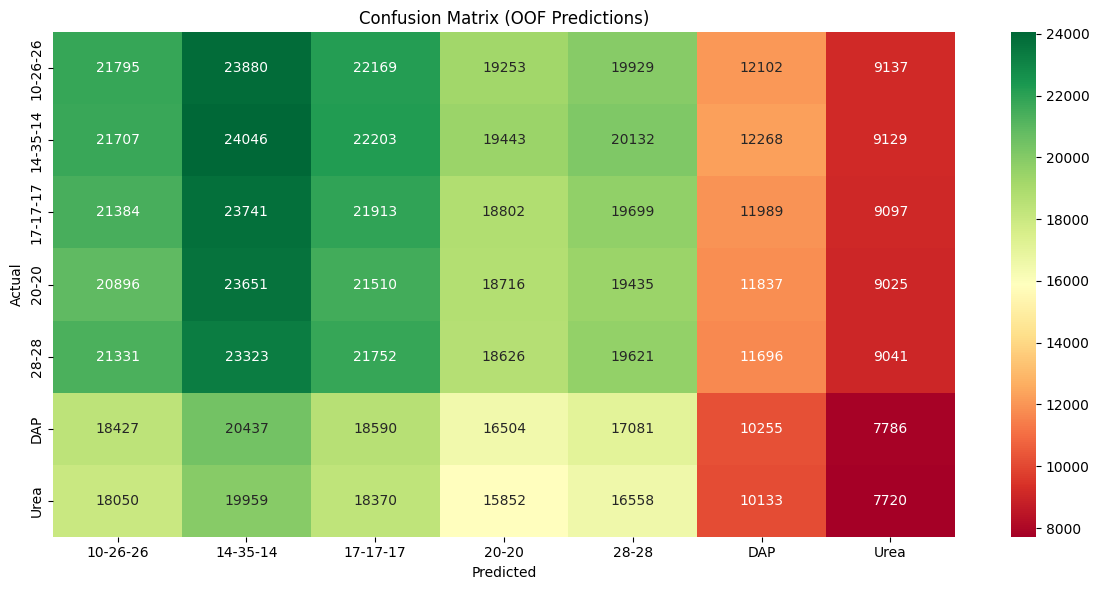

In [47]:
# Confusion Matrix of OOF Predictions
oof_pred_top1 = np.argmax(oof_preds, axis=1)
cm = pd.crosstab(pd.Series(oof_true), pd.Series(oof_pred_top1))
cm.index = [fertilizer_decoder[i] for i in cm.index]
cm.columns = [fertilizer_decoder[i] for i in cm.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn')
plt.title('Confusion Matrix (OOF Predictions)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


#### **Confusion Matrix Analysis of Out-of-Fold Predictions**

- The confusion matrix constructed from out-of-fold (OOF) predictions provides a detailed view of the model’s classification performance across fertilizer classes.  
- The matrix rows represent the actual fertilizer classes, while columns represent the predicted classes, allowing identification of common misclassifications.  
- Diagonal entries indicate correct predictions, with values ranging from approximately 7,700 to 24,000 samples per class, reflecting the model’s strengths.  
- Off-diagonal entries reveal where the model confuses one fertilizer class for another, such as notable misclassifications between `10-26-26`, `14-35-14`, and `17-17-17`, which may share similar nutrient profiles or usage contexts.  
- Lower counts along the diagonal for classes like `DAP` and `Urea` suggest these classes are harder to predict accurately, possibly due to fewer samples or overlapping feature characteristics.


Top-1 Fertilizer Prediction Counts:
  Fertilizer  Count
0   14-35-14  47008
1   17-17-17  43691
2   10-26-26  42491
3      28-28  39099
4      20-20  36929
5        DAP  23686
6       Urea  17096


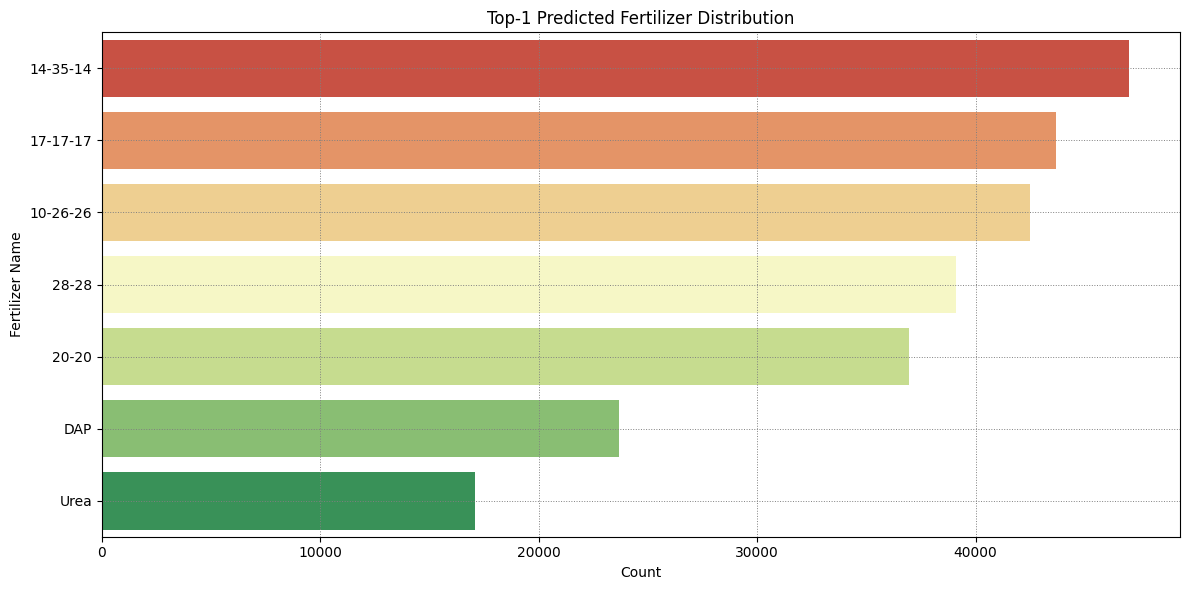

In [48]:
# Top-1 Fertilizer Predictions Count
top1_preds = np.argmax(test_preds, axis=1)

top1_labels = [fertilizer_decoder[i] for i in top1_preds]

top1_counts = pd.Series(top1_labels).value_counts().reset_index()
top1_counts.columns = ['Fertilizer', 'Count']

print("Top-1 Fertilizer Prediction Counts:")
print(top1_counts)

plt.figure(figsize=(12, 6))
sns.barplot(data=top1_counts, x='Count', y='Fertilizer', palette='RdYlGn')
plt.title('Top-1 Predicted Fertilizer Distribution')
plt.xlabel('Count')
plt.ylabel('Fertilizer Name')
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()


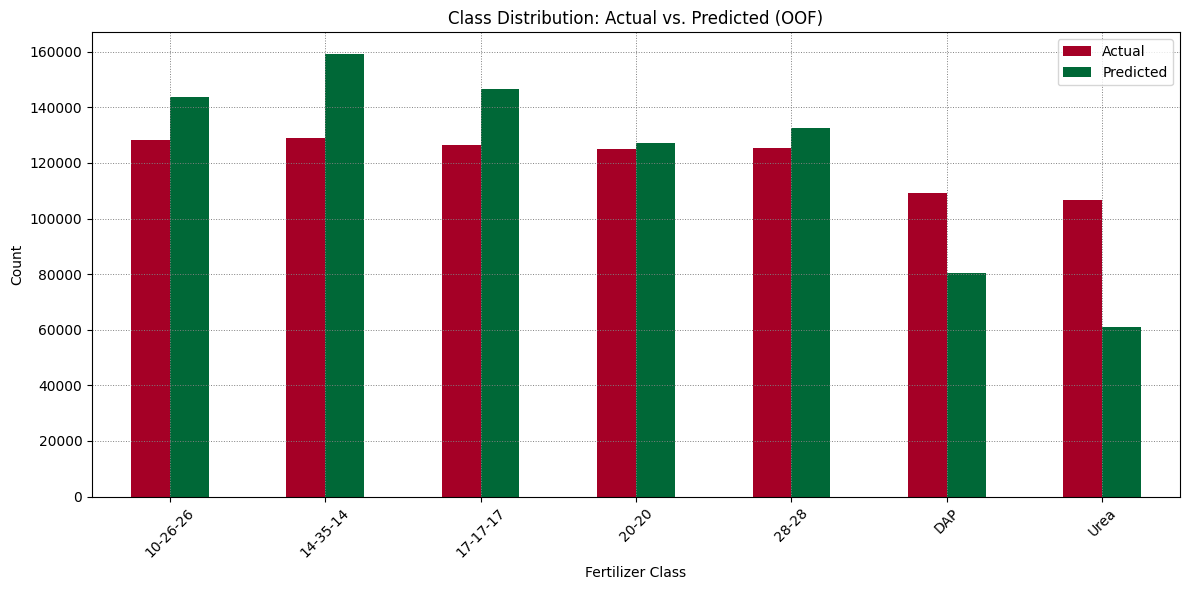

In [49]:
# Class Distribution in Predictions vs. Actual
oof_pred_top1_names = [fertilizer_decoder[i] for i in oof_pred_top1]
oof_true_names = [fertilizer_decoder[i] for i in oof_true]

actual_dist = pd.Series(oof_true_names).value_counts().sort_index()
predicted_dist = pd.Series(oof_pred_top1_names).value_counts().sort_index()

dist_df = pd.DataFrame({
    'Actual': actual_dist,
    'Predicted': predicted_dist
}).fillna(0)

dist_df.plot(kind='bar', figsize=(12, 6), colormap='RdYlGn')
plt.title('Class Distribution: Actual vs. Predicted (OOF)')
plt.xlabel('Fertilizer Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()

#### Insights on Model Predictions and Class Distribution

**Top-1 Fertilizer Predictions Distribution**

- The model’s top-1 predictions on the test dataset reveal the frequency of each fertilizer class being recommended as the most probable choice.  
- The fertilizer **14-35-14** is predicted most frequently, accounting for **47,008** samples, followed closely by **17-17-17** (43,691) and **10-26-26** (42,491).  
- Fertilizers like **DAP** and **Urea** are predicted less often, with counts of **23,686** and **17,096** respectively.  
- This distribution reflects the model’s learned preferences and the underlying data patterns, possibly influenced by the prevalence and agronomic importance of these fertilizers.

**Comparison of Actual vs. Predicted Class Distributions**

- Comparing the out-of-fold (OOF) predictions with the actual fertilizer labels provides insight into model calibration and potential biases.  
- The model tends to **over-predict** certain classes such as **14-35-14**, **17-17-17**, and **10-26-26**, where predicted counts exceed actual counts by a noticeable margin.  
- Conversely, classes like **DAP** and **Urea** are **under-predicted**, with predicted counts significantly lower than actual occurrences.  
- These discrepancies may arise from class imbalance, feature overlap among classes, or model limitations in distinguishing certain fertilizers.


***The analysis of top-1 fertilizer predictions and class distributions demonstrates the model’s strengths in capturing dominant fertilizer classes while revealing areas for refinement in minority classes.  
Continuous evaluation and adjustment based on such insights are essential to develop robust, equitable, and agronomically sound fertilizer recommendation systems.***


In [50]:
# Print Submission preview
print(submission_df.head(10))

       id          Fertilizer Name
0  750000       DAP 10-26-26 28-28
1  750001  17-17-17 20-20 10-26-26
2  750002     20-20 28-28 14-35-14
3  750003        14-35-14 DAP Urea
4  750004     20-20 10-26-26 28-28
5  750005     28-28 20-20 14-35-14
6  750006  28-28 14-35-14 10-26-26
7  750007       DAP 28-28 17-17-17
8  750008  20-20 10-26-26 14-35-14
9  750009  17-17-17 20-20 10-26-26


<!-- Include Google Fonts for a modern font -->
<link href="https://fonts.googleapis.com/css2?family=Roboto:wght@700&display=swap" rel="stylesheet">

<div style="
    border-radius: 15px; 
    border: 2px solid #a63603; /* Darker warm brown to match palette */
    padding: 20px; 
    background: linear-gradient(135deg, #d73027, #fdae61, #a6d96a, #1a9850); 
    text-align: center; 
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);
">
    <h1 style="
        color: #ffffff; 
        text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); 
        font-weight: bold; 
        margin-bottom: 10px; 
        font-size: 28px; 
        font-family: 'Roboto', sans-serif;
    ">
        🙏 Thanks for Reading! 🚀
    </h1>
    <p style="color: #ffffff; font-size: 18px; text-align: center;">
        Happy Coding! 🙌😊
    </p>
</div>
